# NYC Taxi Fares

This study aims at building a machine learning model which predicts the fare taxi amount for a ride in New York City. In order to accomplish this task, we will focus on historical data collected in April 2010.

The performance attained in this problem is highly dependent on our domaing knowledge and hence in uour ability to come up with features that are closely related to the total taxi ride cost.

Since our target is a continuous value, we will develop a **regression model**. Therefore, the best model will be the one which achieves the **lowest RMSE (Root Mean Squared Error)** in this context.

### 1. Libraries & Packages

We import below some libraries and packages that will help us throughout the whole process.

In [85]:
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_absolute_percentage_error, r2_score)

### 2. Importing Data

For the purpose of testing and studying the problem, we will import data from a *csv* file.

In [2]:
df = pd.read_csv("NYCTaxiFares.csv")
df.head()

pickup_datetime  fare_amount  fare_class  pickup_longitude  \
0  2010-04-19 08:17:56 UTC          6.5           0        -73.992365   
1  2010-04-17 15:43:53 UTC          6.9           0        -73.990078   
2  2010-04-17 11:23:26 UTC         10.1           1        -73.994149   
3  2010-04-11 21:25:03 UTC          8.9           0        -73.990485   
4  2010-04-17 02:19:01 UTC         19.7           1        -73.990976   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.730521         -73.975499         40.744746                1  
1        40.740558         -73.974232         40.744114                1  
2        40.751118         -73.960064         40.766235                2  
3        40.756422         -73.971205         40.748192                1  
4        40.734202         -73.905956         40.743115                1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


We can easily see that we have the following fields:

* `pickup_datetime`: Time and date of the pickup. It is important to notice that pandas library has not automatically identified the correct data type, thus we need to convert it. Moreover, we need to account for any timezone issue that may arise.

* `fare_amount`: Our target value - that is, the total amount due to the taxi ride.

* `fare_class`: Just a binary label according to our target value. If a ride costs more than $10, then it belong to class `1`, otherwise `0`.

* `pickup_longitude`: Longitude with respect to pickup's geographic location.

* `pickup_latitude`: Latitude with respect to pickup's geographic location.

* `dropoff_longitude`: Longitude with respect to dropoff's geographic location.

* `dropoff_latitude`: Latitude with respect to dropoff's geographic location.

* `passenger_count`: How many passengers are being transported in the ride.


Once our main goal is to the predict the final price of the taxi ride, we can drop `fare_class` from our dataset before we proceed to any further study.

In [4]:
df = df.drop(columns=["fare_class"])

#### Checking for missing values

From the cell below we notice that it is not necessary to account for missing values, since our dataset is complete.

In [5]:
df.isnull().sum()

pickup_datetime      0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### 3. Feature Engineering

The success of any machine learning model is highly dependent on the features that are fed to it. Hence, feature engineering is a crucial step before we dive into model's development.

In this context, domain knowledge is very important in order to extract rich information from the raw data made available.


#### 3.1 Geolocation

In this problem we are only looking at a specific city - i.e. NYC. This means that there will not be that much of a difference between latitudes and longitudes.

Intuitively we know that the higher the **distance**, the higher the taxi fare amount. Hence, it makes sense to convert these two tuples - $(lat, long)_{dropoff}$ and $(lat, long)_{pickup}$ - into a single value.

A simple euclidean distance could the job, however it would be better to use an equation that takes into account Earth's curvature. This equation is called **Haversine Distance**:

$d = (2R)\arcsin{\sqrt{sin^{2}(\frac{\phi_{2}-\phi_{1}}{2})+cos(\phi_{1})cos(\phi_{2})sin^{2}(\frac{\lambda_{2}-\lambda_{1}}{2})}}$

where $R$ is the Earth's radius (6.371km), $\phi_{1}$ and $\phi_{2}$ are the latitudes of pickup and dropoff locations, and $\lambda_{1}$ and $\lambda_{2}$ are the longitudes of pickup and dropoff locations.

In [6]:
def haversine(pickup: Tuple[float], dropoff: Tuple[float], R: float = 6371) -> float:
    """
    Method which calculates the distance between (lat, lon) pairs on Earth.
    
    Args: 
        pickup (tuple of float): pickup (lat, lon)
        dropoff (tuple of float): dropoff (lat, lon)
    
    Returns: 
        A float number representing the distance, in km.
    """
    phi1, lambda1 = [np.radians(v) for v in pickup]
    phi2, lambda2 = [np.radians(v) for v in dropoff]
    
    delta_lambda = lambda2 - lambda1
    delta_phi = phi2 - phi1
        
    d = 2*R*np.arcsin( np.sqrt(np.sin(delta_phi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2) )

    return d


def calculate_distance(pickup_lat: str, pickup_long: str,
                       dropoff_lat: str, dropoff_long: str) -> np.array:
    """
    Method encapsulates a function to be applied in a pandas DF.
    
    Args: 
        pickup_lat (str): pickup latitude column name
        pickup_long (str): pickup longitude column name
        dropoff_lat (str): dropoff latitude column name
        dropoff_long (str): dropoff longitude column name
    
    Returns: 
        A wrapped function that applies Haversine Distance to a Pandas dataframe.
    """
    def wrapper_calculate_distance(df: pd.DataFrame):
        pickup = (df[pickup_lat], df[pickup_long])
        dropoff = (df[dropoff_lat], df[dropoff_long])
        return haversine(pickup, dropoff)
    
    return wrapper_calculate_distance

In [7]:
df.loc[:, "distance_ride"] = df.apply(
    calculate_distance("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"),
    axis=1
)

In [8]:
df.head()

pickup_datetime  fare_amount  pickup_longitude  pickup_latitude  \
0  2010-04-19 08:17:56 UTC          6.5        -73.992365        40.730521   
1  2010-04-17 15:43:53 UTC          6.9        -73.990078        40.740558   
2  2010-04-17 11:23:26 UTC         10.1        -73.994149        40.751118   
3  2010-04-11 21:25:03 UTC          8.9        -73.990485        40.756422   
4  2010-04-17 02:19:01 UTC         19.7        -73.990976        40.734202   

   dropoff_longitude  dropoff_latitude  passenger_count  distance_ride  
0         -73.975499         40.744746                1       2.126312  
1         -73.974232         40.744114                1       1.392307  
2         -73.960064         40.766235                2       3.326763  
3         -73.971205         40.748192                1       1.864129  
4         -73.905956         40.743115                1       7.231321

#### 3.2 Time and Date

The vast majority of Machine Learning algorithms accept only numeric data. Hence, we need to extract useful features from the pickup datetime, once we cannot feed a timestamp to our model.

Domain knowledge plays a large role here again. Our intuition tells us that the **hour of the day** has a great impact on the taxi fare amount, because during rush hour prices will be higher with a higher demand. Similarly, the **day of week** will be an important factor, since there will likely be more people riding taxis on Friday and Saturday late at night in comparison to normal workdays.

Before we proceed to these features, we need to convert `pickup_datetime` into a compatible format.

In [9]:
df.loc[:, "pickup_datetime"] = pd.to_datetime(df.loc[:, "pickup_datetime"])
df.loc[:, "pickup_datetime"].dtype

datetime64[ns, UTC]

If we take a closer look at this field, there is an UTC attached to it. UTC is the standard time, which is based on GMT timezone. However, NYC is located within Eastern Time Zone (UTC-05:00) - that is, 5h before the UTC timestamp. Additionally, in April NYC is under daylight saving, which means that we must **subtract 4 hours from the UTC datetime**.

In [10]:
df.loc[:, "pickup_datetime_nyc"] = df.loc[:, "pickup_datetime"] - pd.Timedelta(hours=4)

In [11]:
df.head()

pickup_datetime  fare_amount  pickup_longitude  pickup_latitude  \
0 2010-04-19 08:17:56+00:00          6.5        -73.992365        40.730521   
1 2010-04-17 15:43:53+00:00          6.9        -73.990078        40.740558   
2 2010-04-17 11:23:26+00:00         10.1        -73.994149        40.751118   
3 2010-04-11 21:25:03+00:00          8.9        -73.990485        40.756422   
4 2010-04-17 02:19:01+00:00         19.7        -73.990976        40.734202   

   dropoff_longitude  dropoff_latitude  passenger_count  distance_ride  \
0         -73.975499         40.744746                1       2.126312   
1         -73.974232         40.744114                1       1.392307   
2         -73.960064         40.766235                2       3.326763   
3         -73.971205         40.748192                1       1.864129   
4         -73.905956         40.743115                1       7.231321   

        pickup_datetime_nyc  
0 2010-04-19 04:17:56+00:00  
1 2010-04-17 11:43:53+00:00  
2 2010-04-17 07:23:26+00:00  
3 2010-04-11 17:25:03+00:00  
4 2010-04-16 22:19:01+00:00

Then we can generate the new features.

In [12]:
df.loc[:, "hour_ride"] = df.loc[:, "pickup_datetime_nyc"].dt.hour
df.loc[:, "period_ride"] = df.loc[:, "hour_ride"].apply(lambda x: "AM" if x < 12 else "PM")
df.loc[:, "day_ride"] = df.loc[:, "pickup_datetime_nyc"].dt.strftime("%A")

However, we do not want to treat them as `object` or `int64` pandas types. So, the last step is to convert them into a categorical format.

In [13]:
df.loc[:, "hour_ride"] = df.loc[:, "hour_ride"].astype("category")
df.loc[:, "period_ride"] = df.loc[:, "period_ride"].astype("category")
df.loc[:, "day_ride"] = df.loc[:, "day_ride"].astype("category")

In [14]:
df.head()

pickup_datetime  fare_amount  pickup_longitude  pickup_latitude  \
0 2010-04-19 08:17:56+00:00          6.5        -73.992365        40.730521   
1 2010-04-17 15:43:53+00:00          6.9        -73.990078        40.740558   
2 2010-04-17 11:23:26+00:00         10.1        -73.994149        40.751118   
3 2010-04-11 21:25:03+00:00          8.9        -73.990485        40.756422   
4 2010-04-17 02:19:01+00:00         19.7        -73.990976        40.734202   

   dropoff_longitude  dropoff_latitude  passenger_count  distance_ride  \
0         -73.975499         40.744746                1       2.126312   
1         -73.974232         40.744114                1       1.392307   
2         -73.960064         40.766235                2       3.326763   
3         -73.971205         40.748192                1       1.864129   
4         -73.905956         40.743115                1       7.231321   

        pickup_datetime_nyc hour_ride period_ride  day_ride  
0 2010-04-19 04:17:56+00:00         4          AM    Monday  
1 2010-04-17 11:43:53+00:00        11          AM  Saturday  
2 2010-04-17 07:23:26+00:00         7          AM  Saturday  
3 2010-04-11 17:25:03+00:00        17          PM    Sunday  
4 2010-04-16 22:19:01+00:00        22          PM    Friday

### 4. EDA: Exploratory Data Analysis

The next step in our development lifecycle is the study of each variable in the problem. So, we are going to compute each feature's basic statistics as well as display useful visualizations regarding their characteristics. Moreover, we will evaluate how the features are related to eache other and to the target value.

This will help us identify not only any transformations we need to perform but also the most valuable features in this context.

##### Features according to data types

In [15]:
TARGET_NAME = ["fare_amount"]
CONTINUOUS_FEATURES = [
    "distance_ride", "pickup_latitude", "pickup_longitude", 
    "dropoff_latitude", "dropoff_longitude"
]
INTEGER_FEATURES = ["passenger_count"]
CATEGORICAL_FEATURES = [
    "hour_ride", "period_ride", "day_ride"
]

In [16]:
def boxplot(data: pd.DataFrame, num_cols: List[str], by: str = None, hue: str = None):
    """
    Function to plot boxplots for either univariate or bivariate statistical analysis.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        num_cols (list of str): numerical columns whose boxplots will be displayed
        by (str): optional categorical column to group the data
        hue (str): optional categorical column to discriminate the data further
    
    Returns: 
        None
    """
    plt.figure(figsize=(12, 4*len(num_cols)))
    for i, num_col in enumerate(num_cols):
        ax = plt.subplot(len(num_cols), 1, i+1)
        if by is not None:
            sns.boxplot(y=num_col, x=by, hue=hue, data=data, ax=ax)
        else:
            sns.boxplot(x=num_col, data=data, ax=ax)
    plt.tight_layout()
    plt.show()
    
    
def histogram(data: pd.DataFrame, num_cols: List[str]):
    """
    Function to plot histograms for statistical analysis.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        num_cols (list of str): numerical columns whose histograms will be displayed
    
    Returns: 
        None
    """
    plt.figure(figsize=(12, 4*len(num_cols)))
    for i, num_col in enumerate(num_cols):
        ax = plt.subplot(len(num_cols), 1, i+1)
        data.loc[:, num_col].hist(ax=ax)
        ax.set_xlabel(num_col)
    plt.tight_layout()
    plt.show()
    
    
def regression_plot(data: pd.DataFrame, y_col: str, x_cols: List[str]):
    """
    Function to plot regression plots between two numerical variables.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        y_col (str): reference variable against which plots will be displayed
        x_cols (list of str): variables to plot against the reference one
    
    Returns: 
        None
    """
    plt.figure(figsize=(12, 4*len(x_cols)))
    for i, x_col in enumerate(x_cols):
        ax = plt.subplot(len(x_cols), 1, i+1)
        sns.regplot(data=data, x=x_col, y=y_col, 
                    marker="+", scatter_kws={"alpha": 0.2}, line_kws={"color": "red"})
    plt.tight_layout()
    plt.show()


def correlation_heatmap(data: pd.DataFrame, ref_col: str = None):
    """
    Function to display a correlation heatmap between numerical variables.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        ref_col (str): optional column name to display single row.
    
    Returns: 
        None
    """
    corr = data.corr()
    if ref_col is not None:
        corr = corr.loc[:, [ref_col]]
    mask = np.zeros_like(corr).astype(bool)
    mask[np.triu_indices_from(corr, k=1)] = True
    plt.figure(figsize=(8, 4))
    sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, mask=mask, cmap="coolwarm")
    plt.show()
    
    
def countplot(data: pd.DataFrame, cat_cols: List[str], hue: str = None):
    """
    Function to plot countplots for either univariate or bivariate statistical analysis.
    
    Args: 
        data (pandas dataframe): dataframe containing the actual data
        cat_cols (list of str): categorical columns whose boxplots will be displayed
        hue (str): optional categorical column to discriminate the data further
    
    Returns: 
        None
    """
    multiplier = 4
    if hue is not None:
        multiplier = max([4, df.loc[:, hue].nunique()])
    plt.figure(figsize=(12, multiplier*len(cat_cols)))
    for i, cat_col in enumerate(cat_cols):
        ax = plt.subplot(len(cat_cols), 1, i+1)
        if hue is not None:
            sns.countplot(y=cat_col, hue=hue, data=data, ax=ax)
        else:
            sns.countplot(x=cat_col, data=data, ax=ax)
    plt.tight_layout()
    plt.show()

#### 4.1 Target Values

First, we need to take a closer look at our target variable, since we can understand better its relationship with the features of this task. Moreover, some machine learning algorithms work better if the target value is actually normally distributed, thus it could be necessary to perform a transformation to the original data.

##### Univariate

+ Bulk Statistics

We can easily notice that the values are left skewed, since the mean value finds itself around the 70th percentile. Additionally, there are a few extreme values that are not of great concern.

In [17]:
df.loc[:, TARGET_NAME].describe(percentiles=np.round(np.linspace(0.25, 0.95, 15), 2)).T

count       mean       std  min  25%  30%  35%  40%  45%  50%  \
fare_amount  120000.0  10.040326  7.500134  2.5  5.7  6.1  6.5  6.9  7.3  7.7   

             55%  60%  65%   70%   75%   80%   85%   90%   95%   max  
fare_amount  8.1  8.9  9.7  10.5  11.3  12.5  14.5  17.7  25.7  49.9

+ Boxplots

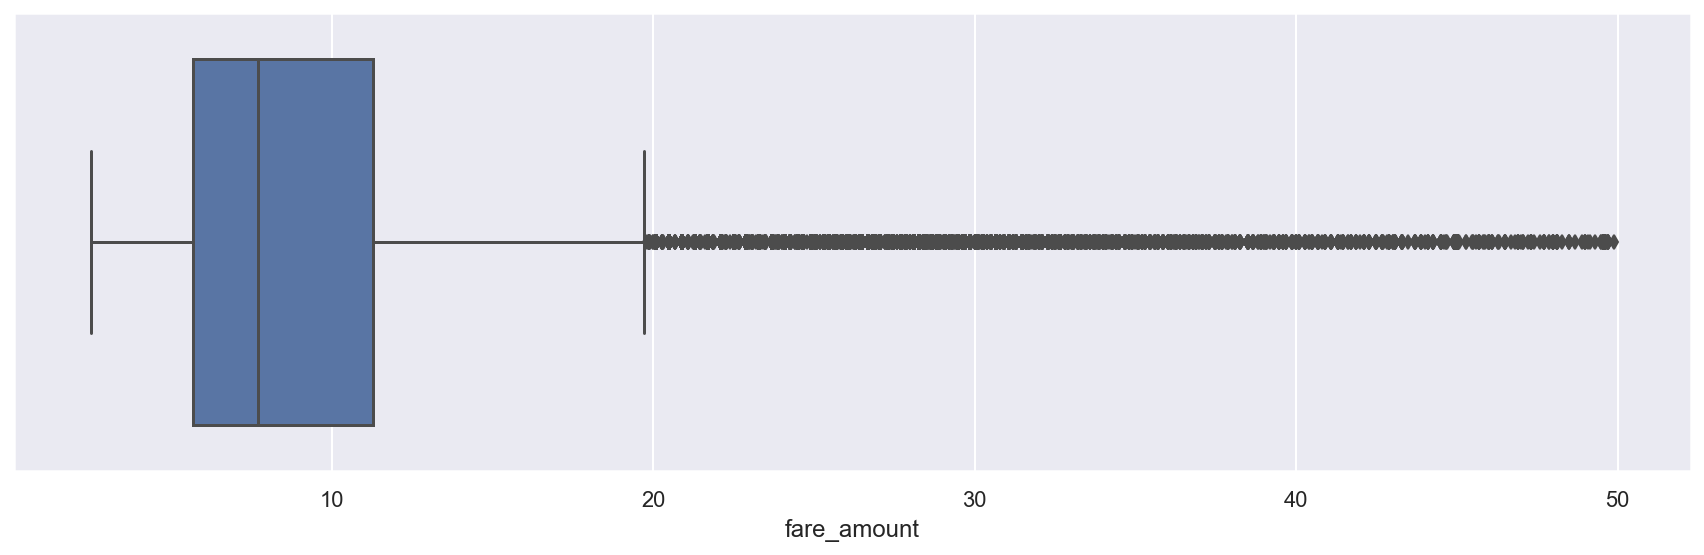

In [18]:
boxplot(
    data=df,
    num_cols=TARGET_NAME
)

+ Distributions

We can now visually conclude that the distribution is left skewed,a s mentioned above.

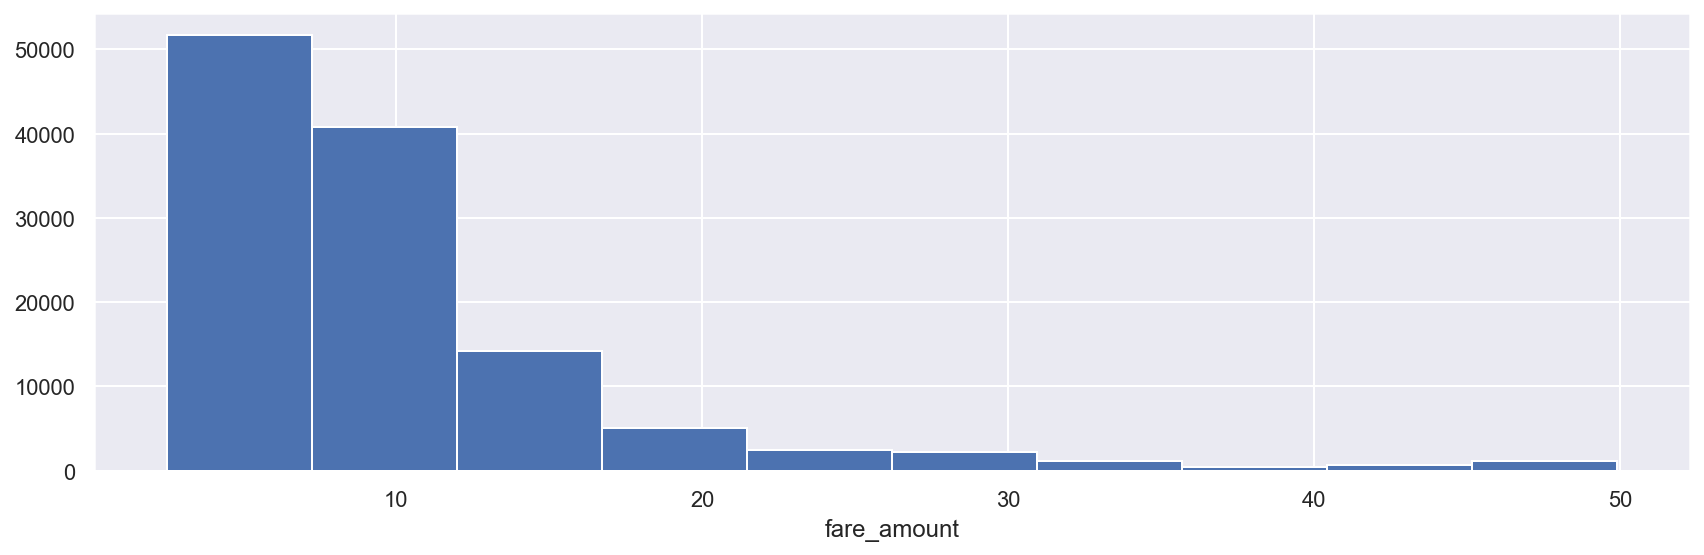

In [19]:
histogram(
    data=df,
    num_cols=TARGET_NAME
)

Some machine learning models perform better when the underlying distribution of the target values is normal. Therefore, we could try to approximate such behavior by computing the logarithm of our target:

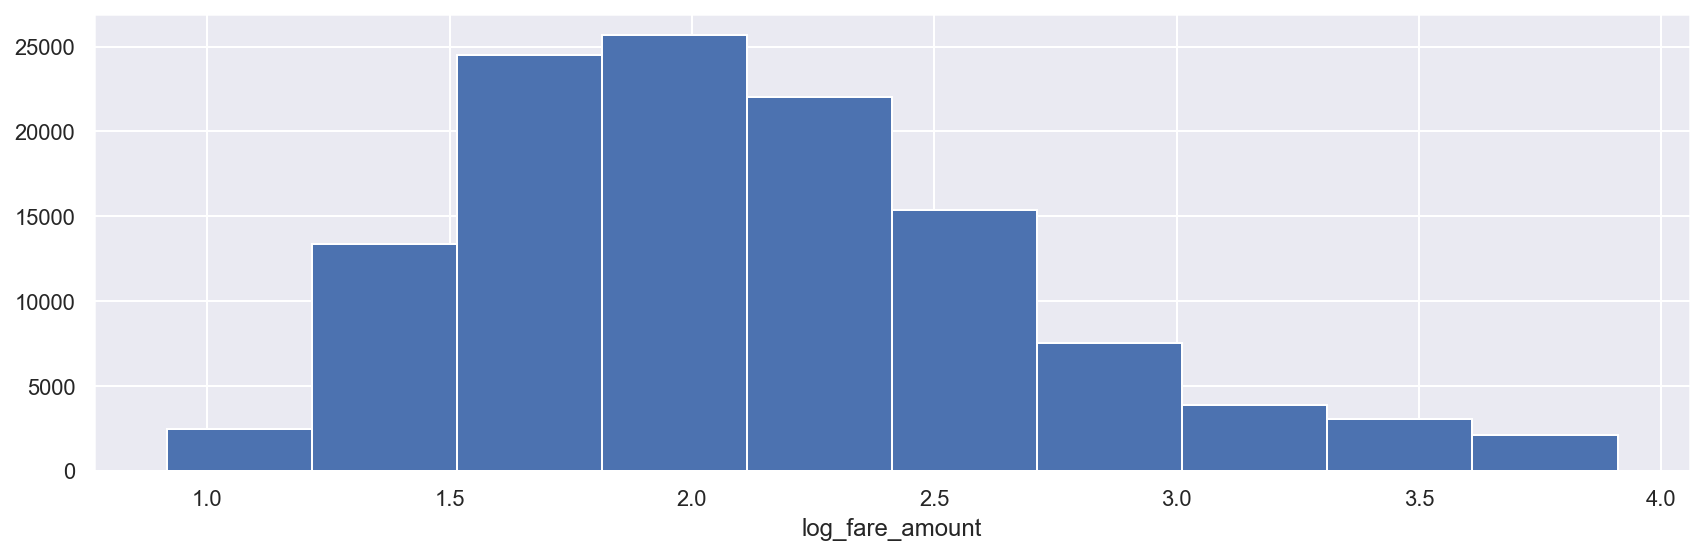

In [20]:
df.loc[:, "log_fare_amount"] = df.loc[:, "fare_amount"].apply(np.log)
histogram(
    data=df,
    num_cols=["log_fare_amount"]
)

Now we have something that looks like a normal distribution and does not suffer from extreme values. For the model development stage, we are going to adopt this `log_fare_amount` as our target value.

In [21]:
NEW_TARGET_NAME = ["fare_amount"]

##### Bivariate

+ Boxplots

From the visualizations below, we can easily notice that:

    - taxi rides are more costly late at night or very early in the morning;
    - there is not so much diffence across different weekdays, even though it is possible to see a little increase as we get closer to the end of the week (Friday, Saturday and Sunday);
    - the taxi fare amount is higher for rides with more than only one pasenger, however for 2+ passenger no big difference is detectable.

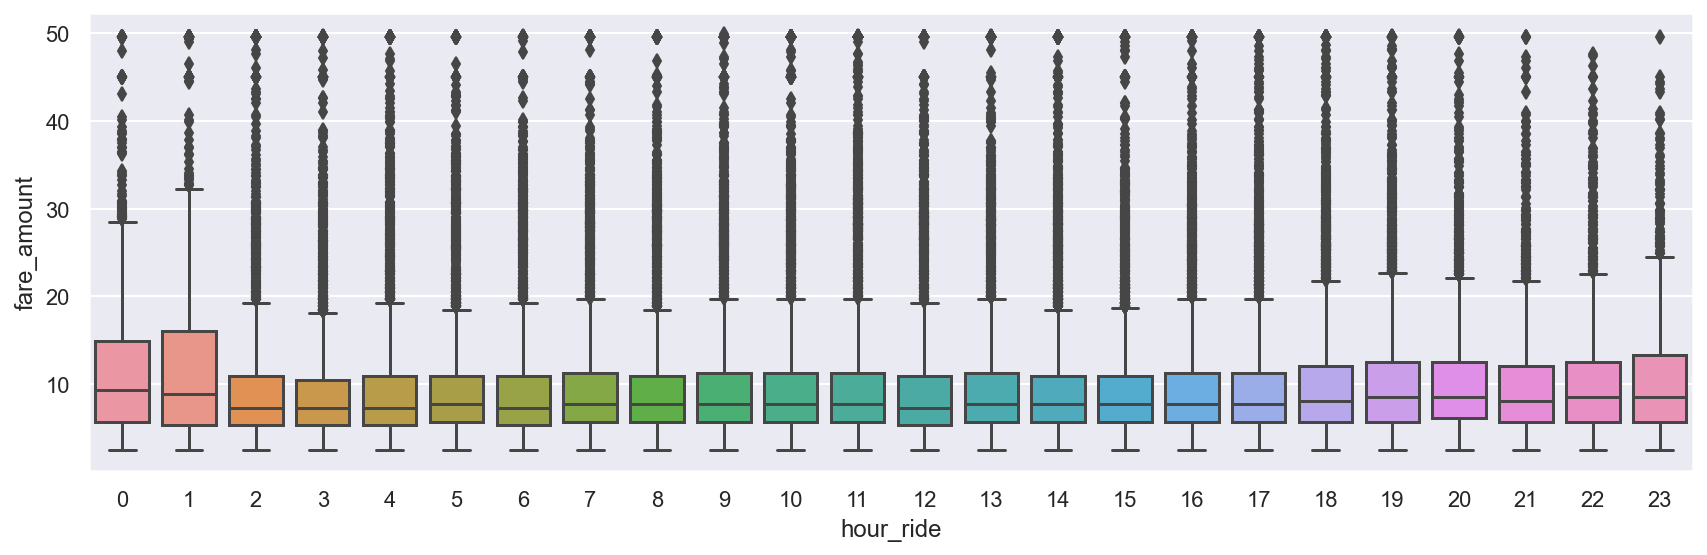

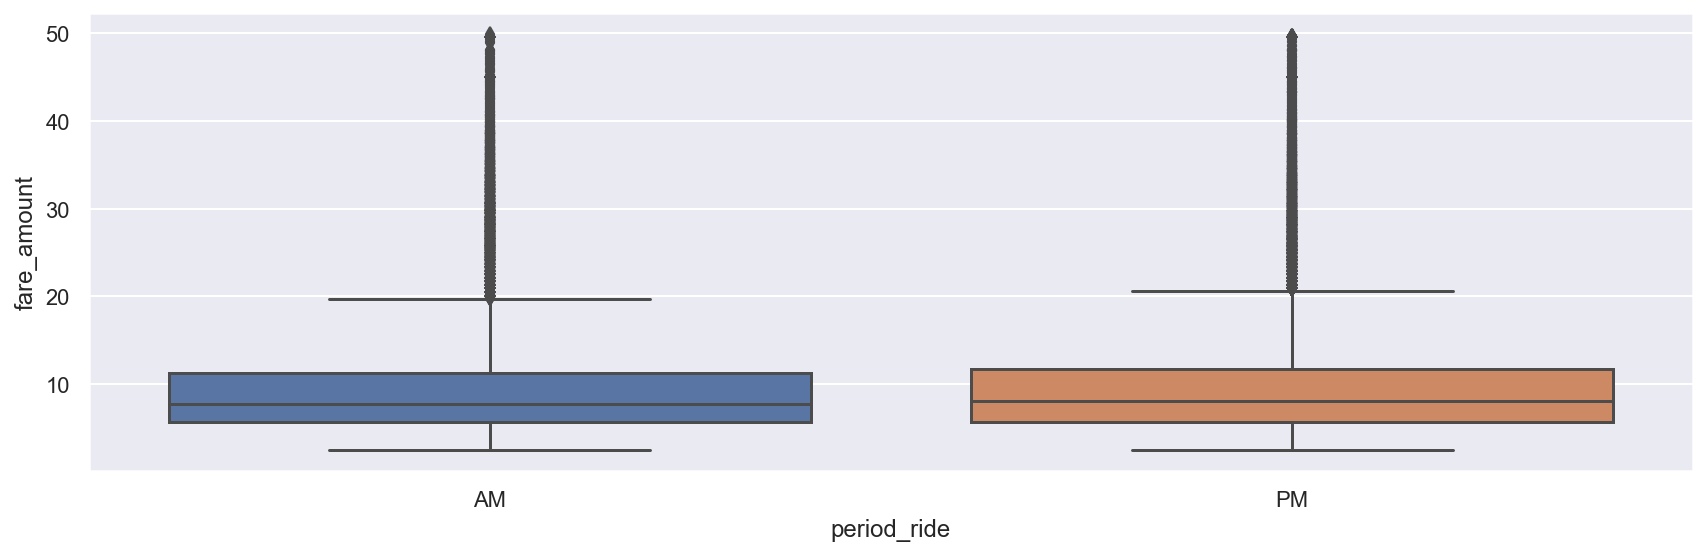

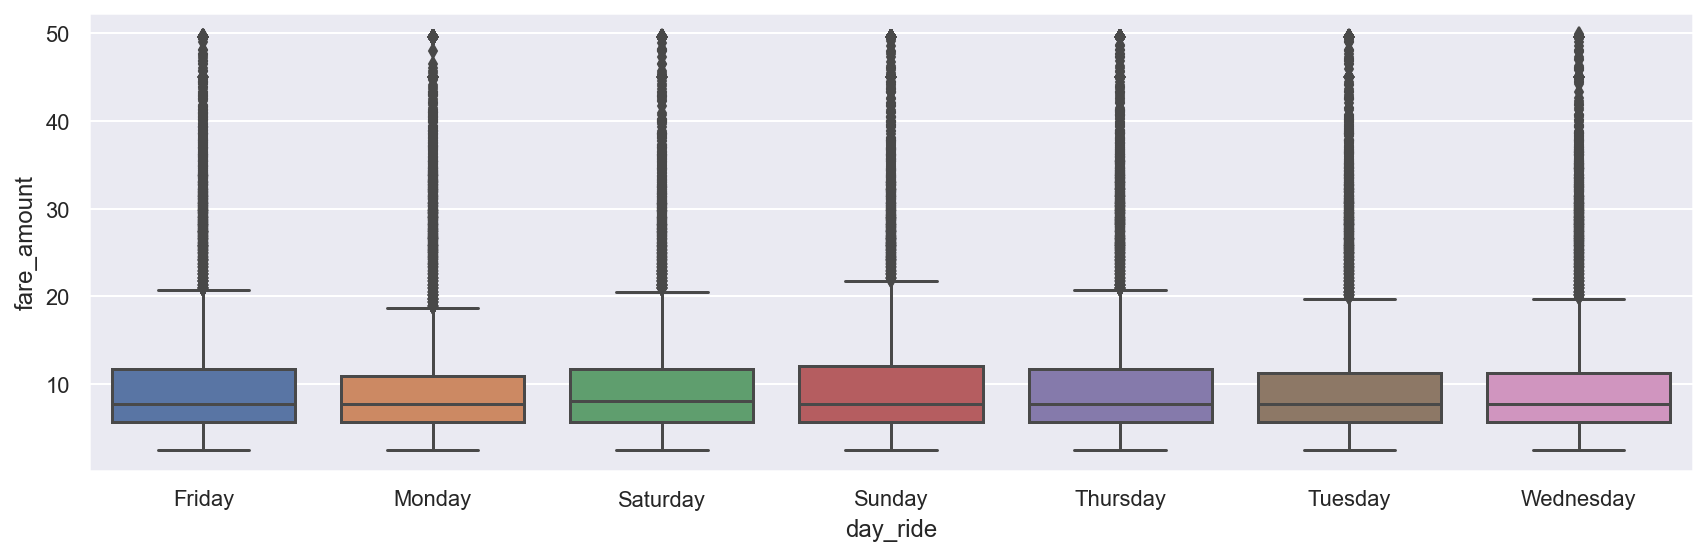

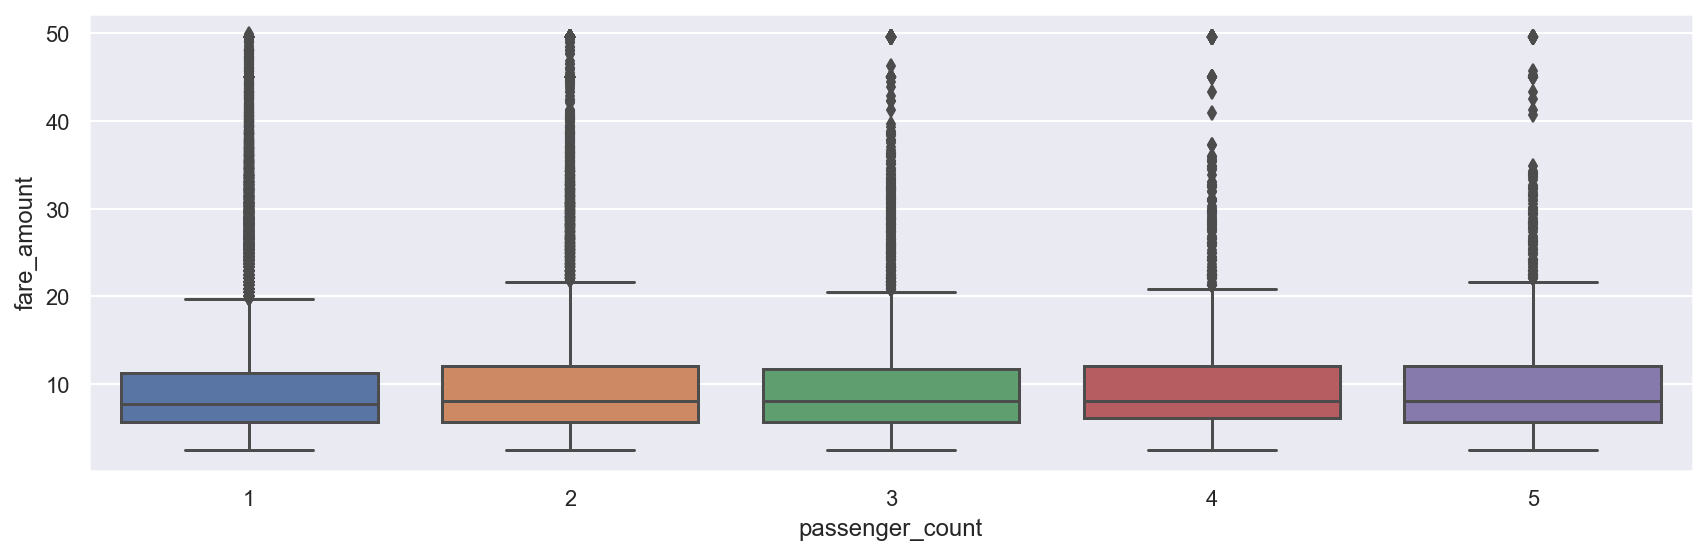

In [22]:
for cat_col in CATEGORICAL_FEATURES+INTEGER_FEATURES:
    boxplot(
        data=df,
        num_cols=TARGET_NAME,
        by=cat_col
    )

Rides after noon tend to present higher fare amounts in comparison to earlier rides.

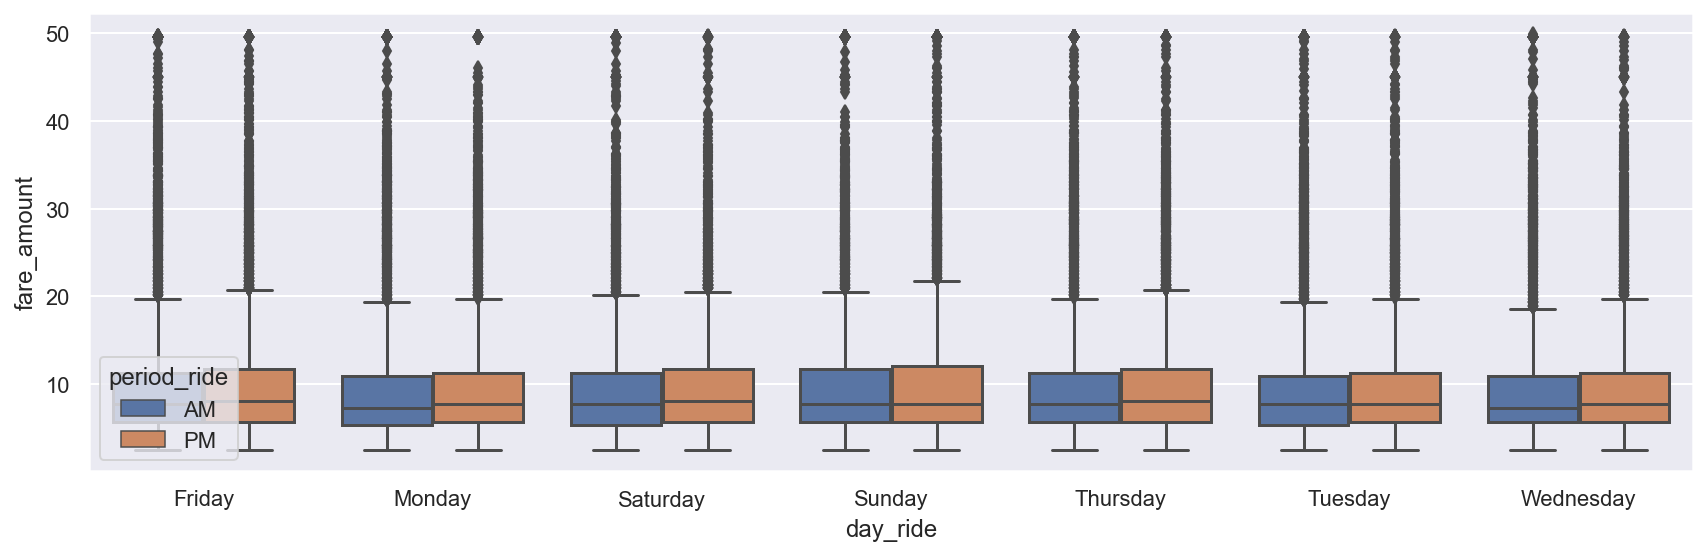

In [23]:
boxplot(
    data=df,
    num_cols=TARGET_NAME,
    by="day_ride",
    hue="period_ride",
)

Fare amounts do not seem to vary according to the number of passengers during weekdays. However, on weekends we can visualize that more expensive rides are related to more passengers in the ride. 

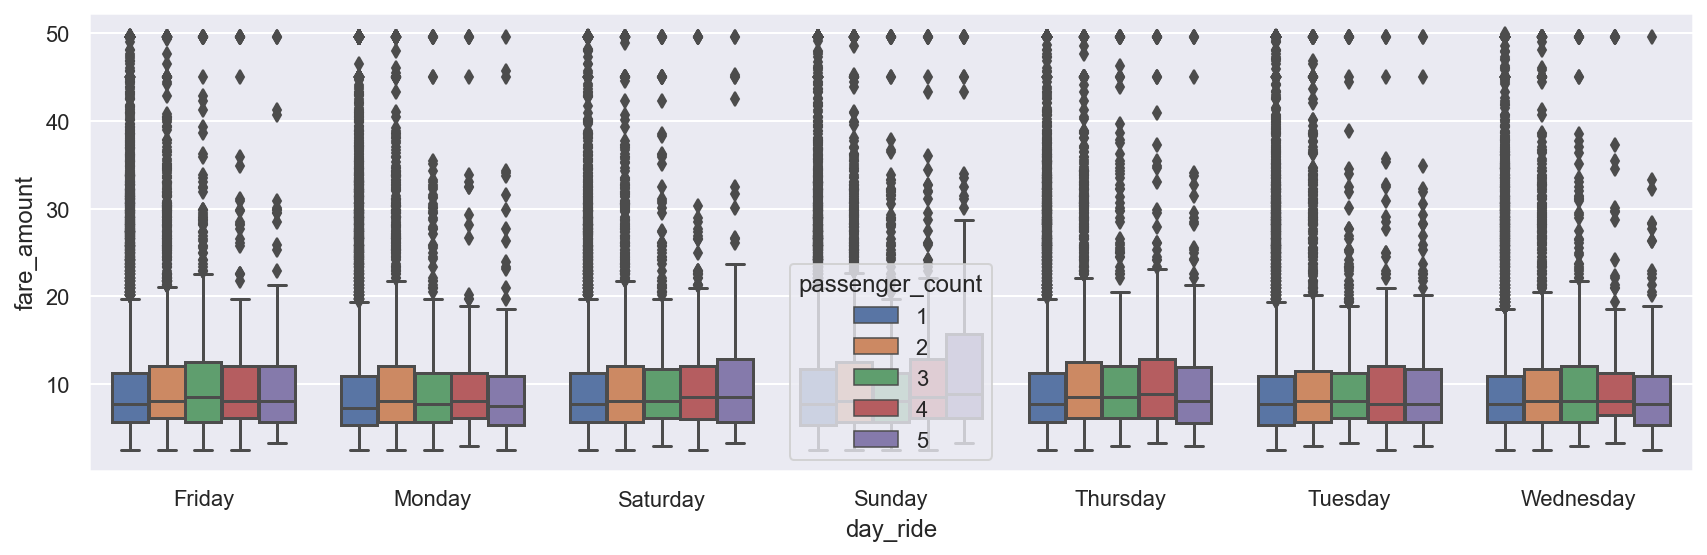

In [24]:
boxplot(
    data=df,
    num_cols=TARGET_NAME,
    by="day_ride",
    hue="passenger_count",
)

When we bring day of week and hour together into the picture, we can see more variability in the fare amounts. This could give as a hint to apply **feature cross** to these features. In this scenario, we would come up with a categorical feature that has 168 (24 x 7) unique values.

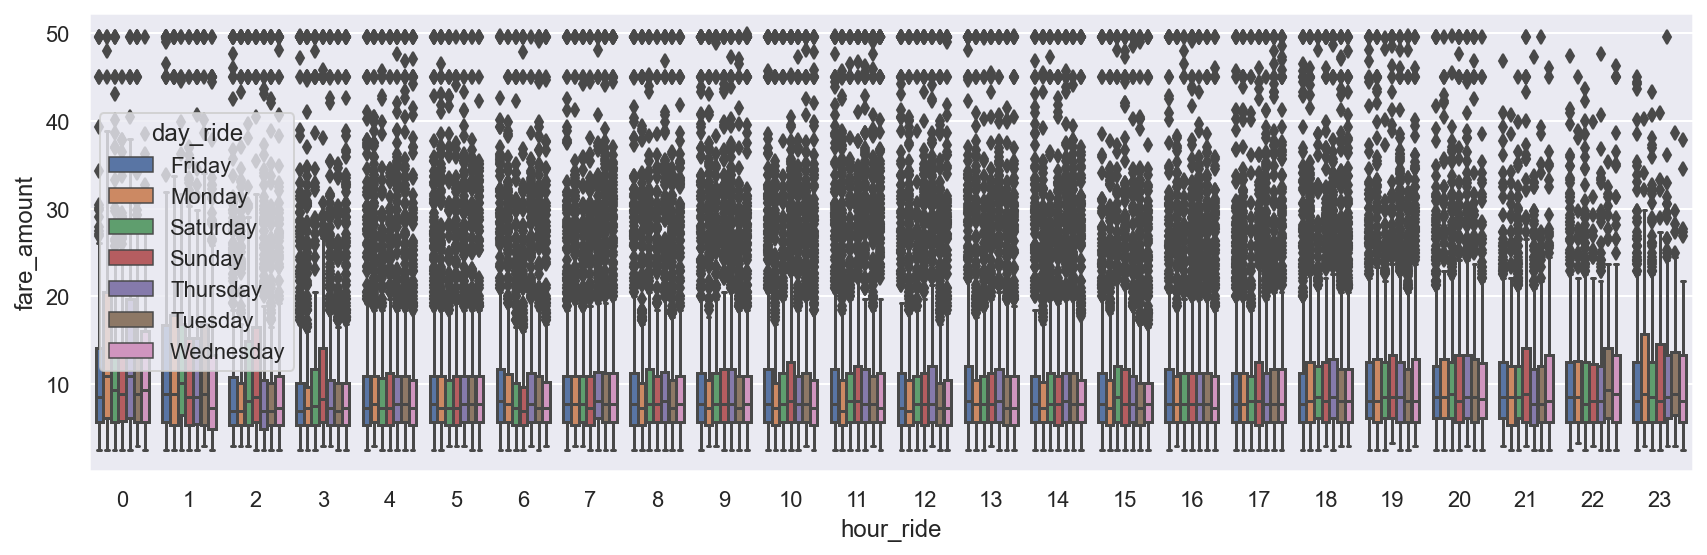

In [25]:
boxplot(
    data=df,
    num_cols=TARGET_NAME,
    by="hour_ride",
    hue="day_ride",
)

+ Regression Plots

It is also useful to visually inspect how the target values are related to the numerical features.

From the visualizations below, we can conclude that we were richt about our intuition that the higher the distance, the more expensive the ride - `fare_amount` and `distance_ride` have almost a perfect correlation between them. Regarding the other features, there is no detectable relationship at all and we notice that our initial assumption that latitudes and longitudes do not add that much information by themselves were correct.

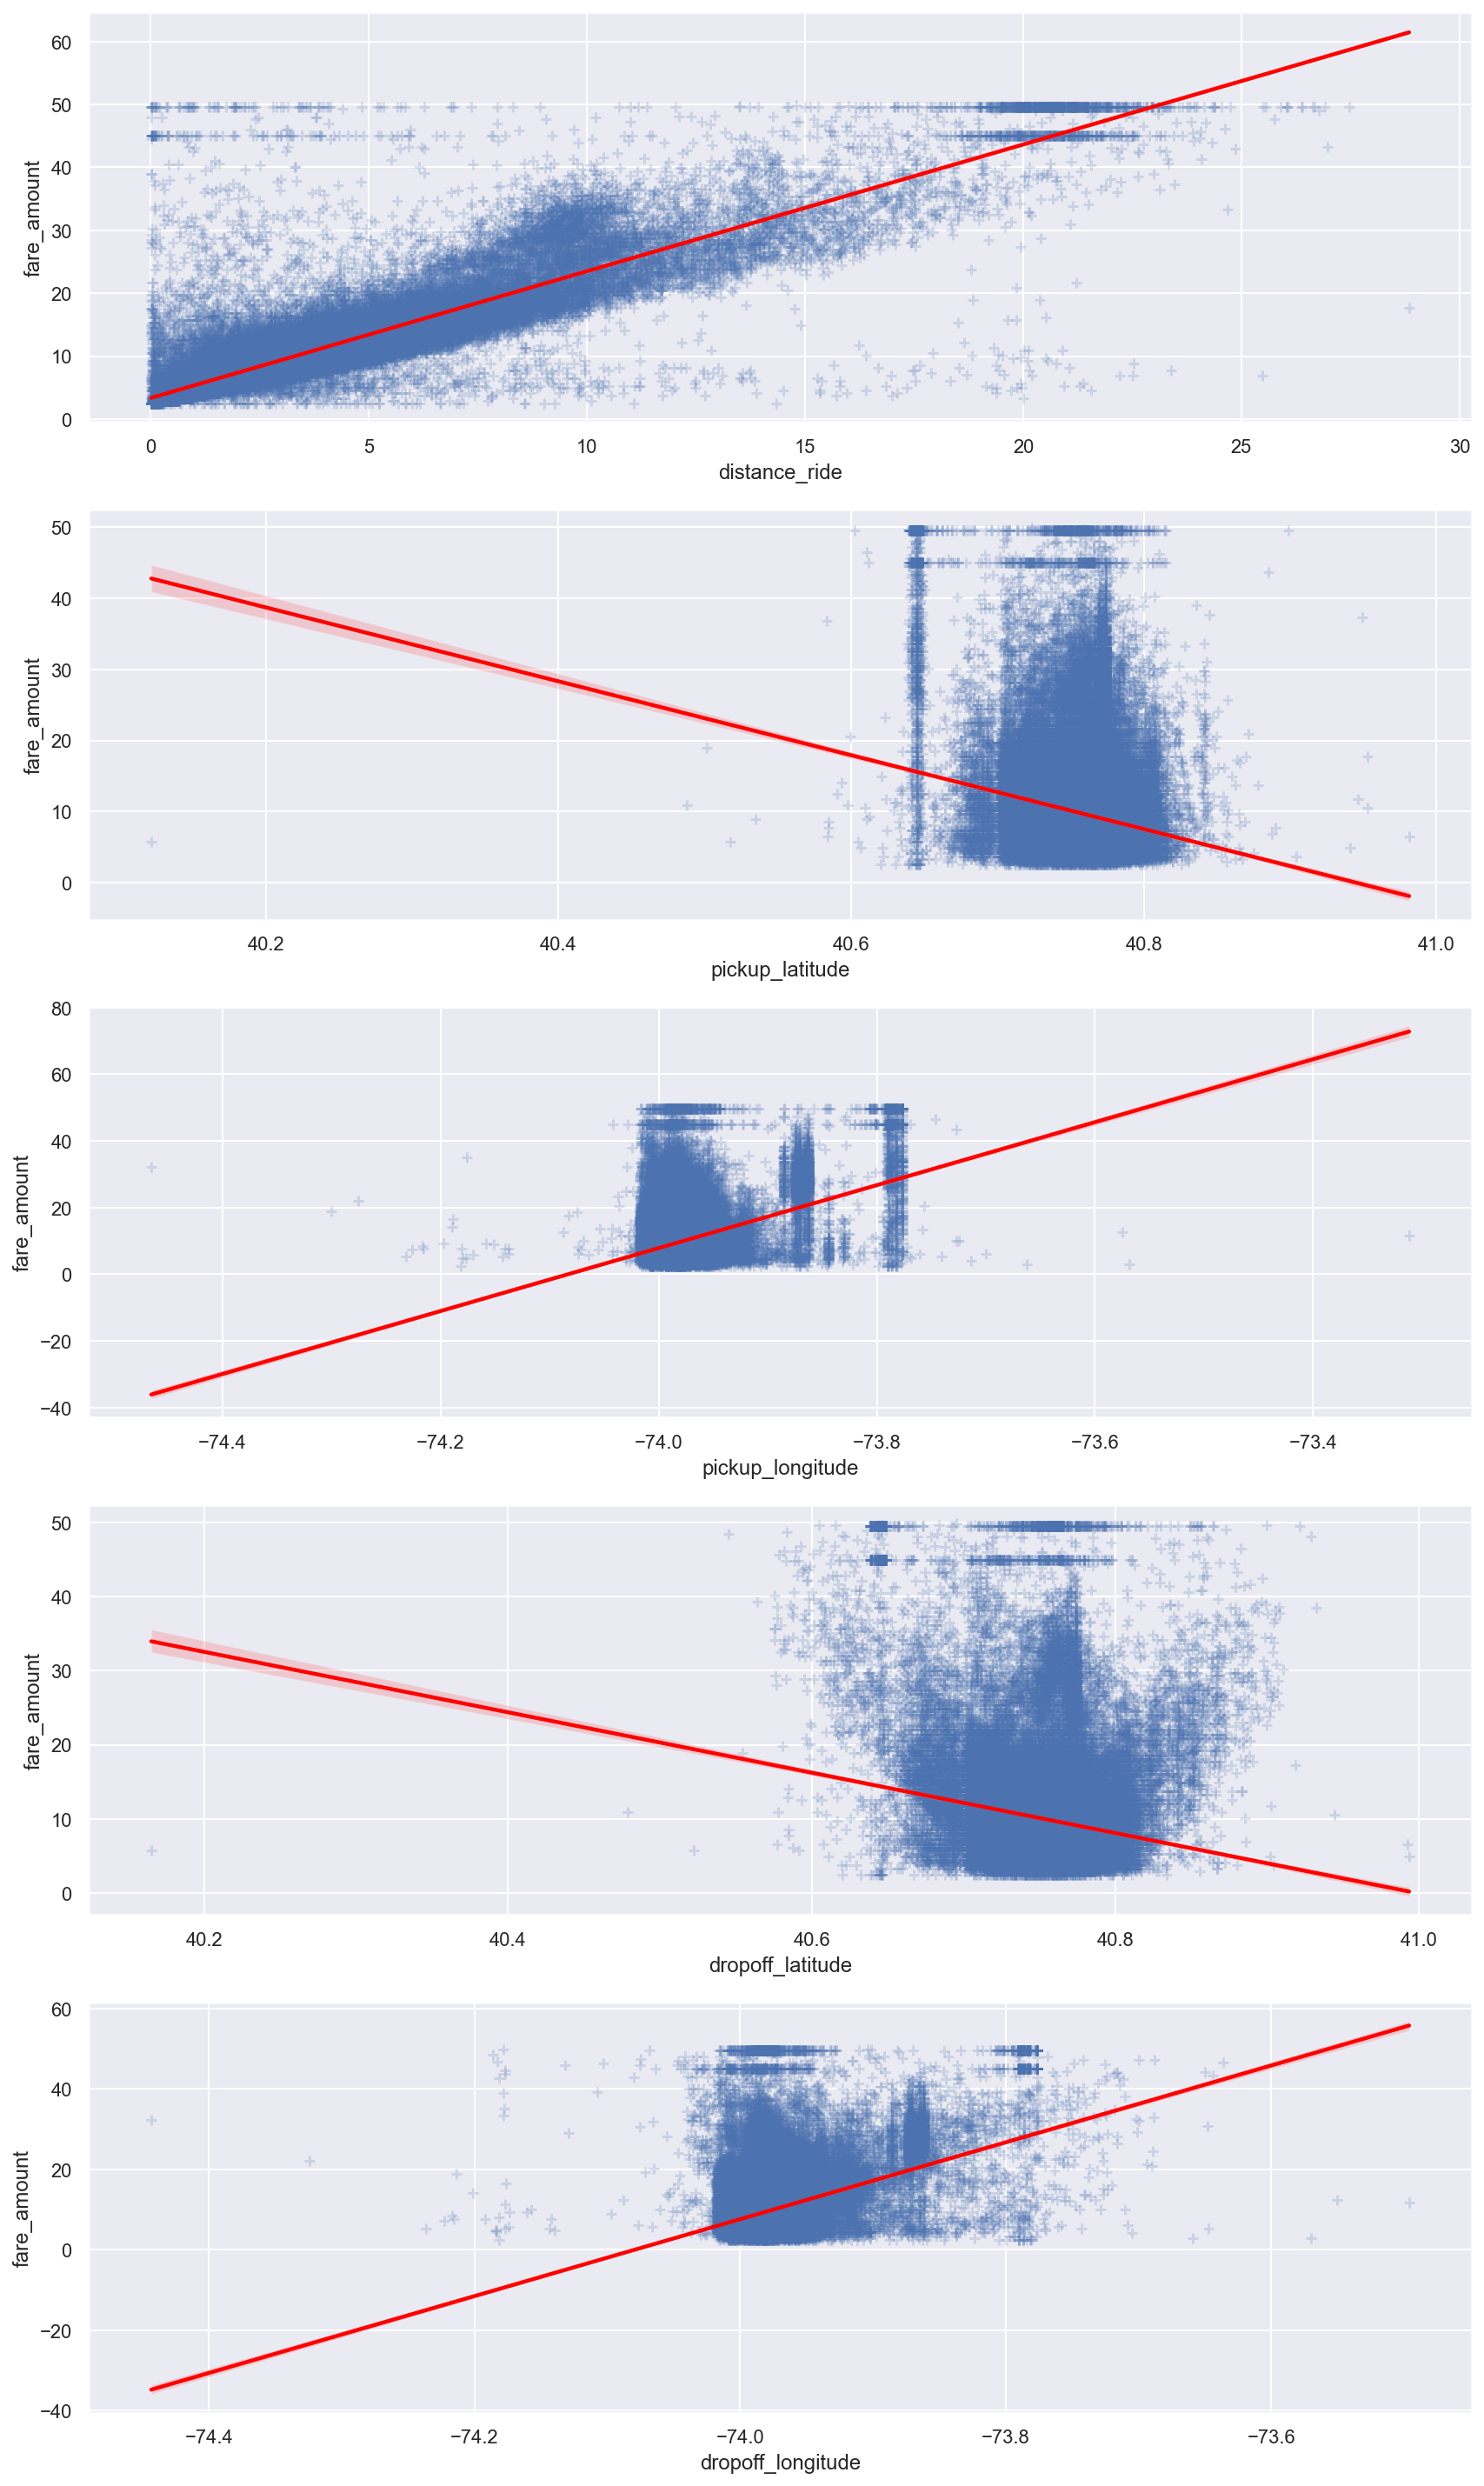

In [26]:
regression_plot(
    data=df,
    y_col=TARGET_NAME[0],
    x_cols=CONTINUOUS_FEATURES
)

+ Correlation Heatmap

The following correlation heatmap reinforces our previous conclusion: `fare_amount` and `distance_ride` have a high correlation between them, which is very positive for any further algorithm development.

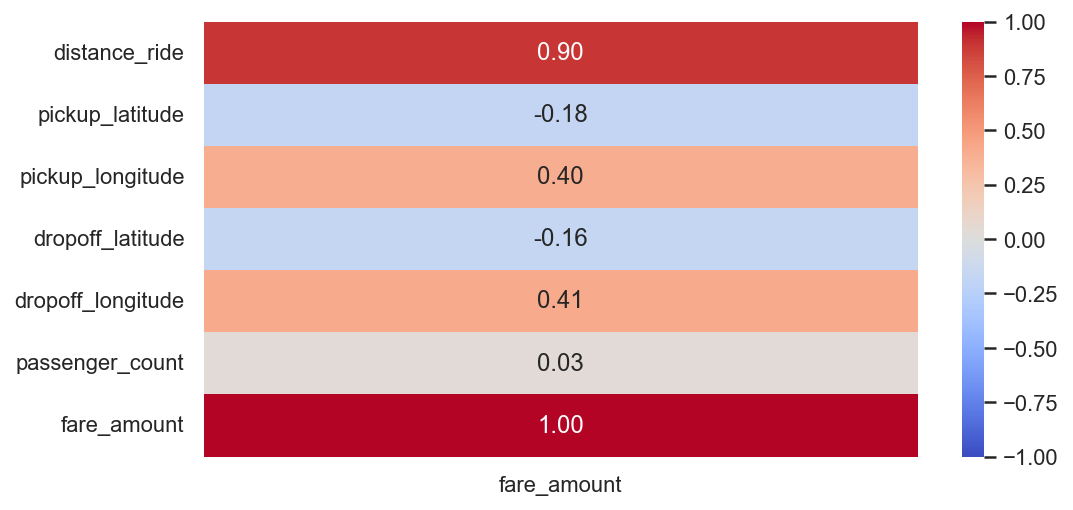

In [27]:
correlation_heatmap(df.loc[:, CONTINUOUS_FEATURES+INTEGER_FEATURES+TARGET_NAME], ref_col=TARGET_NAME[0])

#### 4.2 Numerical Features

Now, let's take a look at numerical features. We will evaluate their basic statistics and generate visualizations such as histograms, boxplots and correlation heatmaps.

##### Univariate

+ Bulk Statistics

We can again conclude that latitudes and longitudes do not add any extra predictive power due to ther limited range. On the other hand, the distance presents a wider interval and some outliers, which is likely due to its skewed distribution.

In [28]:
df.loc[:, CONTINUOUS_FEATURES].describe(percentiles=np.round(np.linspace(0.1, 0.95, 18), 2))

distance_ride  pickup_latitude  pickup_longitude  dropoff_latitude  \
count  120000.000000    120000.000000     120000.000000     120000.000000   
mean        3.322160        40.751443        -73.976626         40.751695   
std         3.337004         0.025821          0.031497          0.030279   
min         0.010208        40.121653        -74.465447         40.164927   
10%         0.844472        40.721355        -74.002984         40.717451   
15%         1.009735        40.726721        -73.998848         40.724384   
20%         1.160679        40.731903        -73.994947         40.730404   
25%         1.316428        40.736594        -73.992386         40.735914   
30%         1.472986        40.740434        -73.990413         40.740475   
35%         1.642091        40.744014        -73.988334         40.744391   
40%         1.822150        40.747751        -73.986218         40.748556   
45%         2.020733        40.750703        -73.984013         40.751279   
50%         2.237084        40.753661        -73.982084         40.754441   
55%         2.481690        40.756669        -73.980178         40.757201   
60%         2.773483        40.759471        -73.977917         40.760011   
65%         3.117124        40.762048        -73.975287         40.762498   
70%         3.531372        40.764424        -73.972460         40.765112   
75%         4.034564        40.768020        -73.968710         40.768880   
80%         4.675026        40.771605        -73.964363         40.773358   
85%         5.576323        40.775220        -73.959401         40.777608   
90%         6.944880        40.780187        -73.954213         40.783247   
95%         9.646471        40.787868        -73.945333         40.793686   
max        28.846365        40.981292        -73.311845         40.993498   

       dropoff_longitude  
count      120000.000000  
mean          -73.974501  
std             0.032419  
min           -74.443323  
10%           -74.003012  
15%           -73.998166  
20%           -73.994160  
25%           -73.991478  
30%           -73.989249  
35%           -73.986897  
40%           -73.984502  
45%           -73.982330  
50%           -73.980411  
55%           -73.978238  
60%           -73.975853  
65%           -73.973246  
70%           -73.969907  
75%           -73.965500  
80%           -73.960600  
85%           -73.955607  
90%           -73.950147  
95%           -73.926855  
max           -73.496140

+ Boxplots

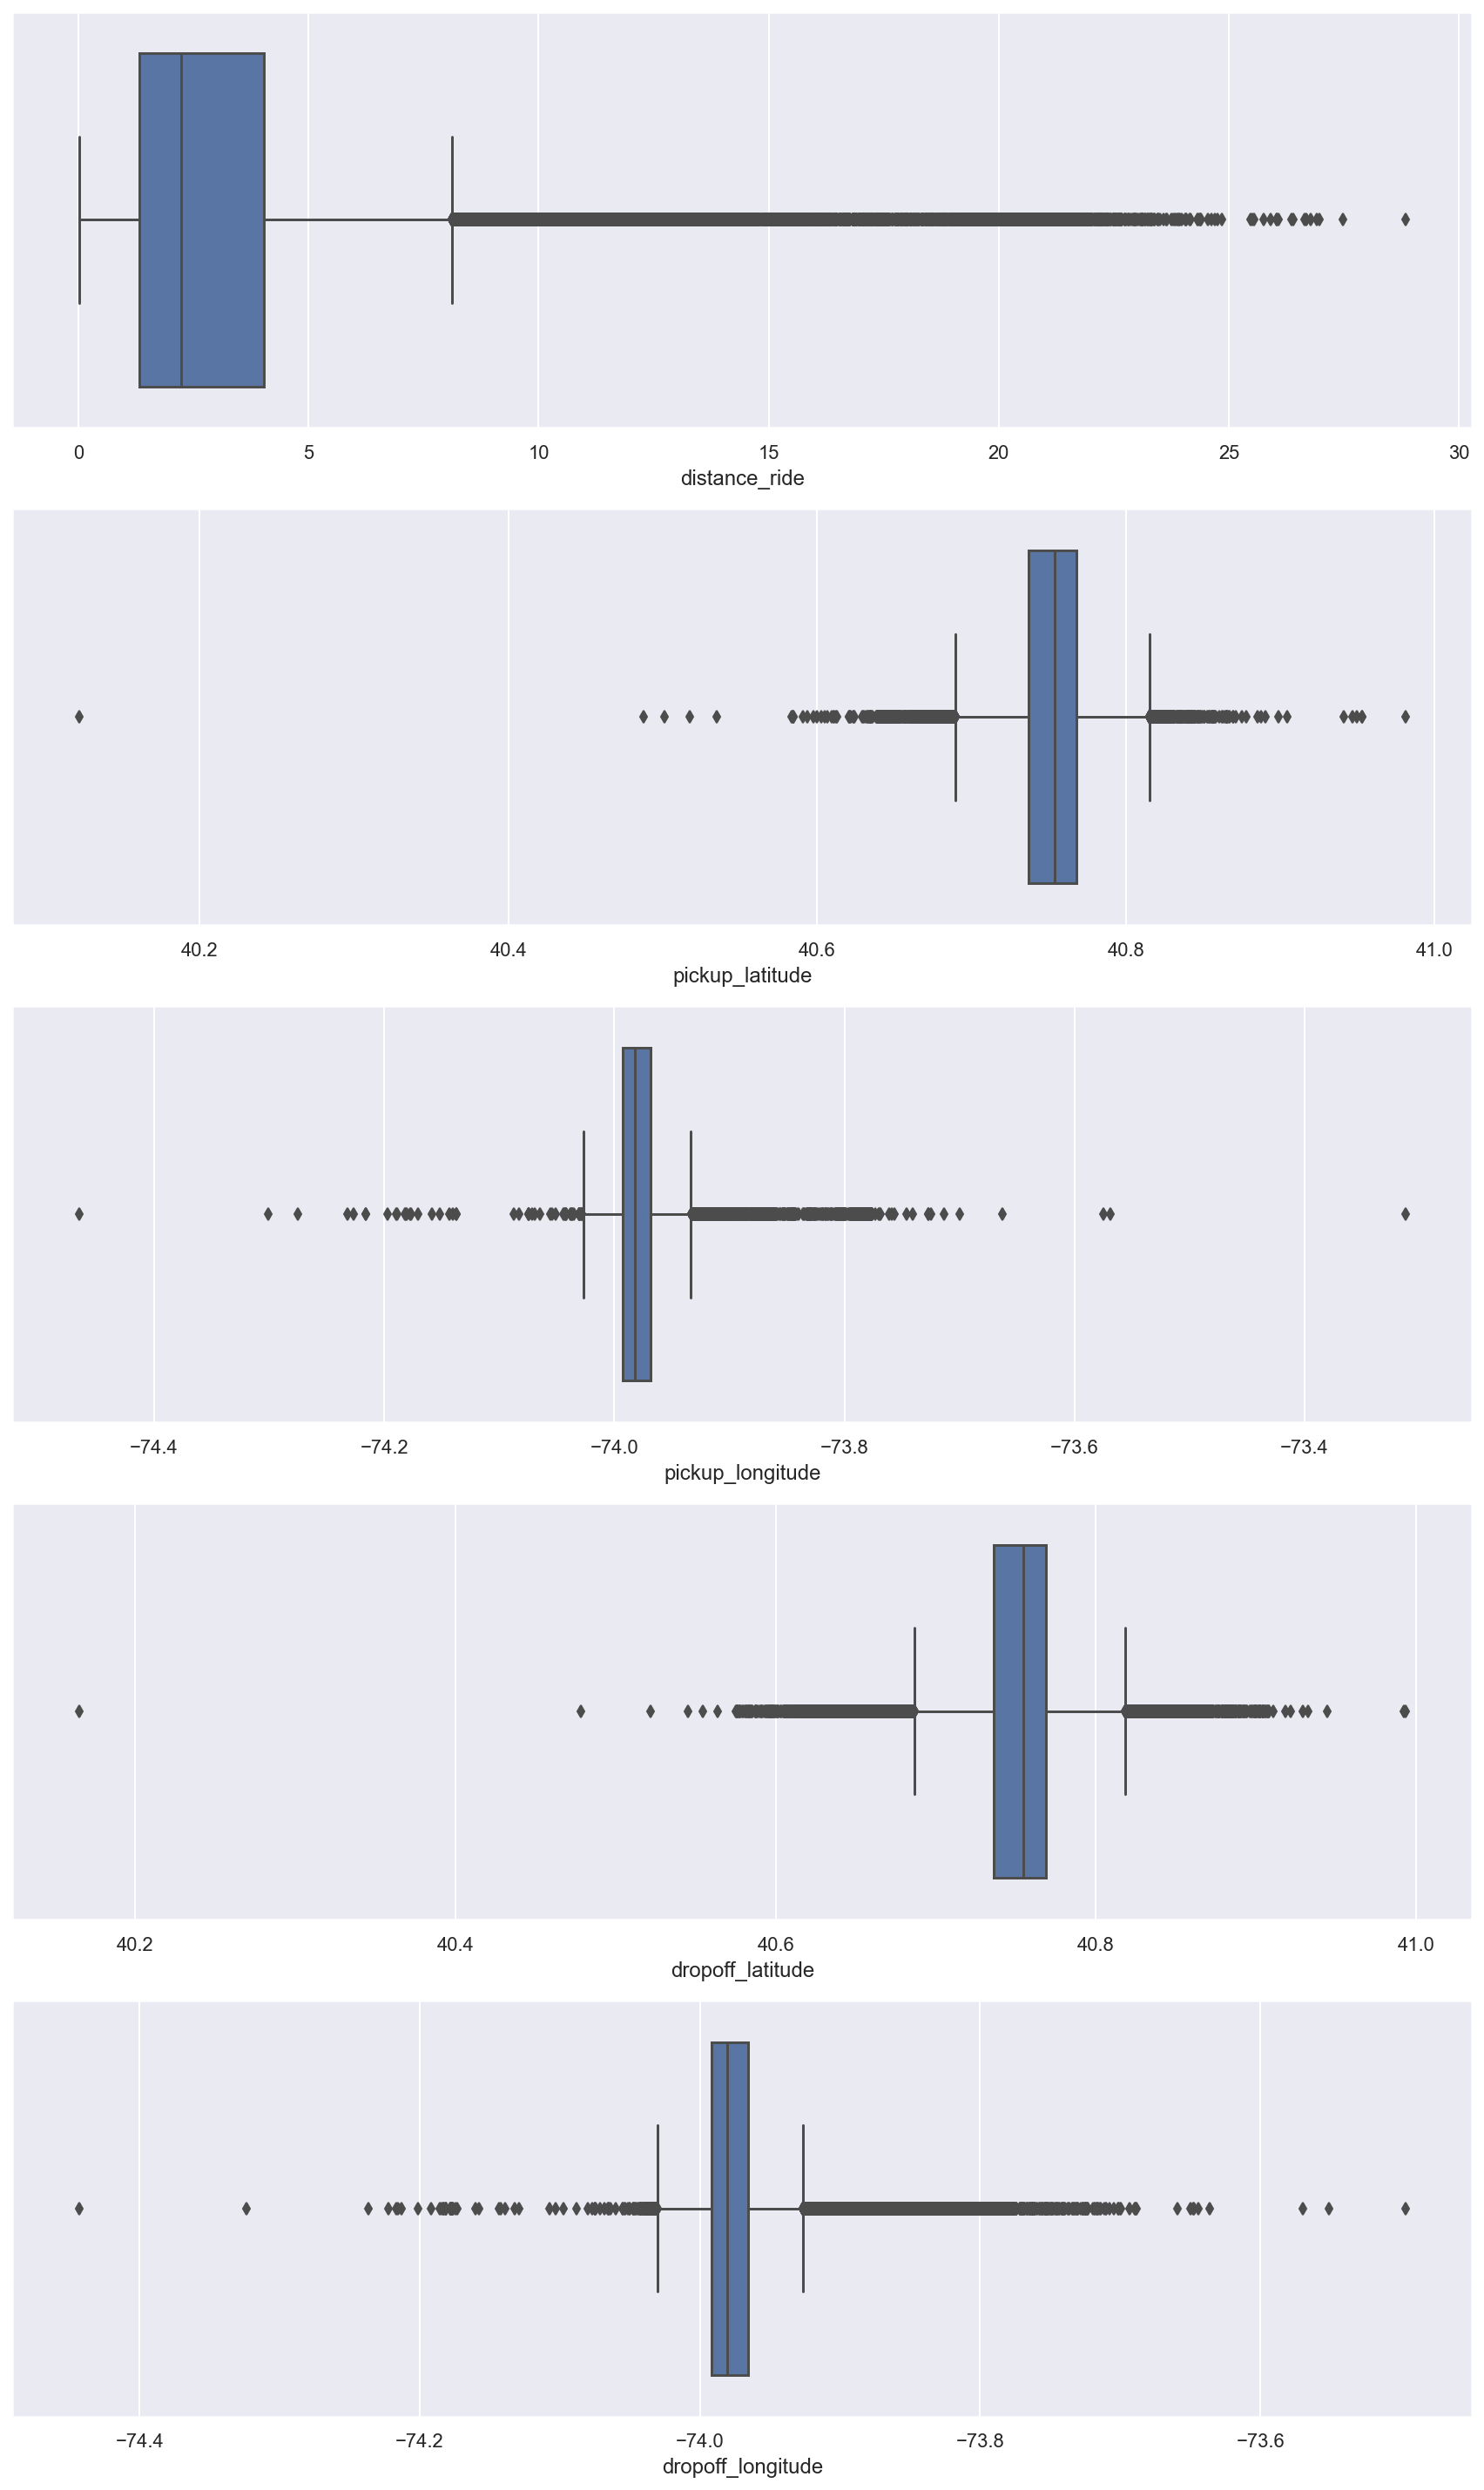

In [29]:
boxplot(
    data=df,
    num_cols=CONTINUOUS_FEATURES
)

+ Distributions

Regarding `distance_ride` it is easily noticeable that the distribution is left skewed - in the same way `fare_amount` has its own distribution. Hence, seeking normally distributed features as well, it may be advisable to compute the logarithm of this feature as well.

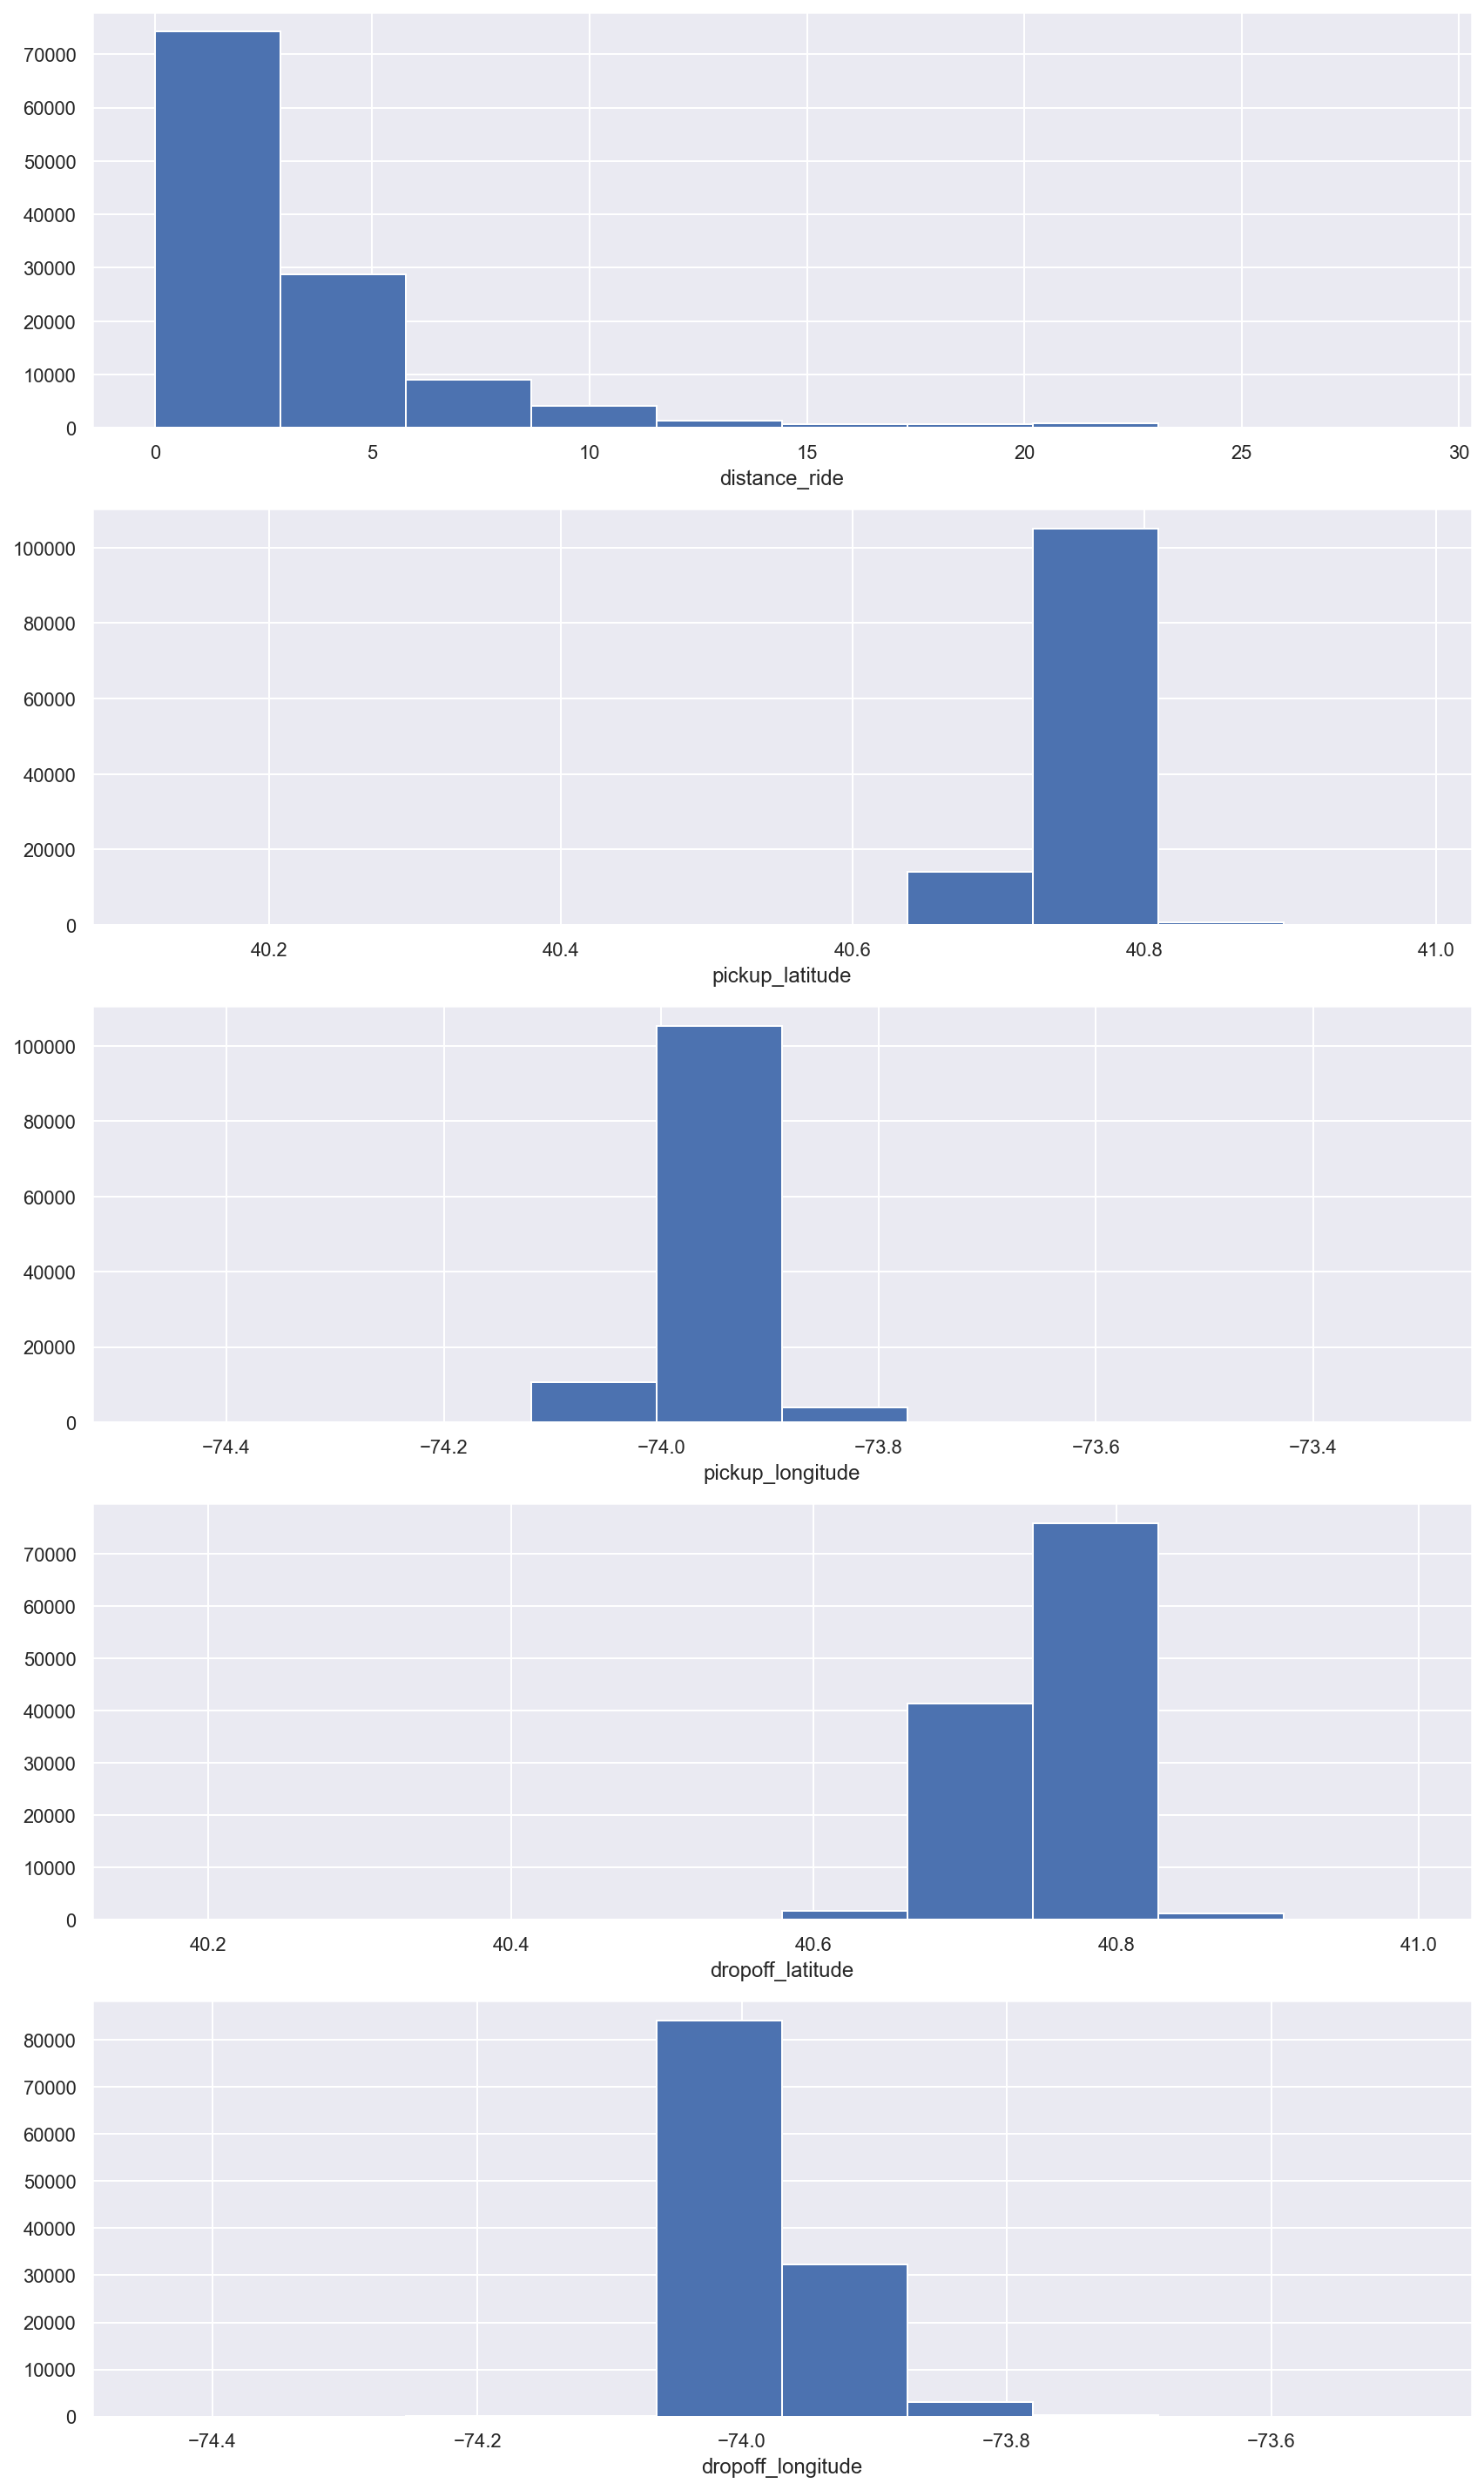

In [30]:
histogram(
    data=df,
    num_cols=CONTINUOUS_FEATURES
)

Below we have a clear evidence of how `distance_ride` is easily converted into a normal distribution by simply applying the logarithm.

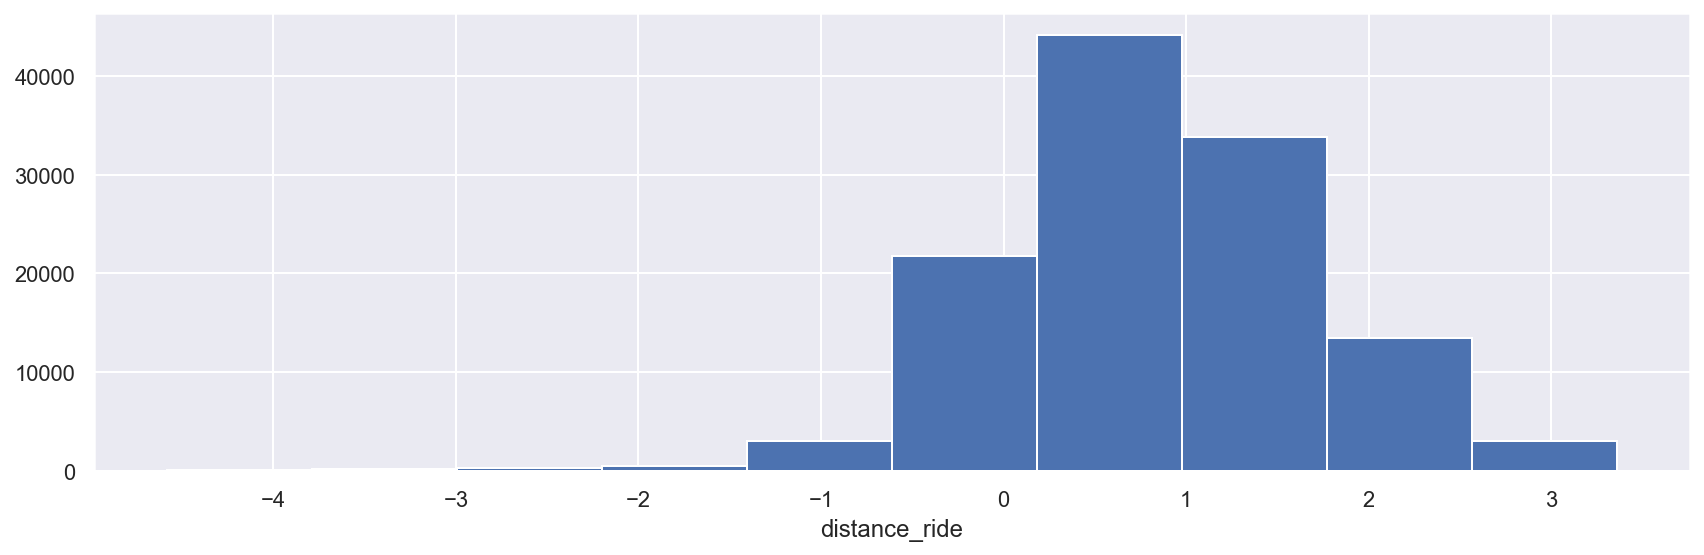

In [31]:
histogram(
    data=np.log(df.loc[:, ["distance_ride"]]),
    num_cols=["distance_ride"]
)

##### Bivariate

+ Numerical Columns according to `hour_ride`:

The distance shows a different behavior according to each hour of the day. Rides late at night or very early in the morning tend to have also higher distances, which intutively makes sense: people feel safer to get home in such periods by taking a taxi.

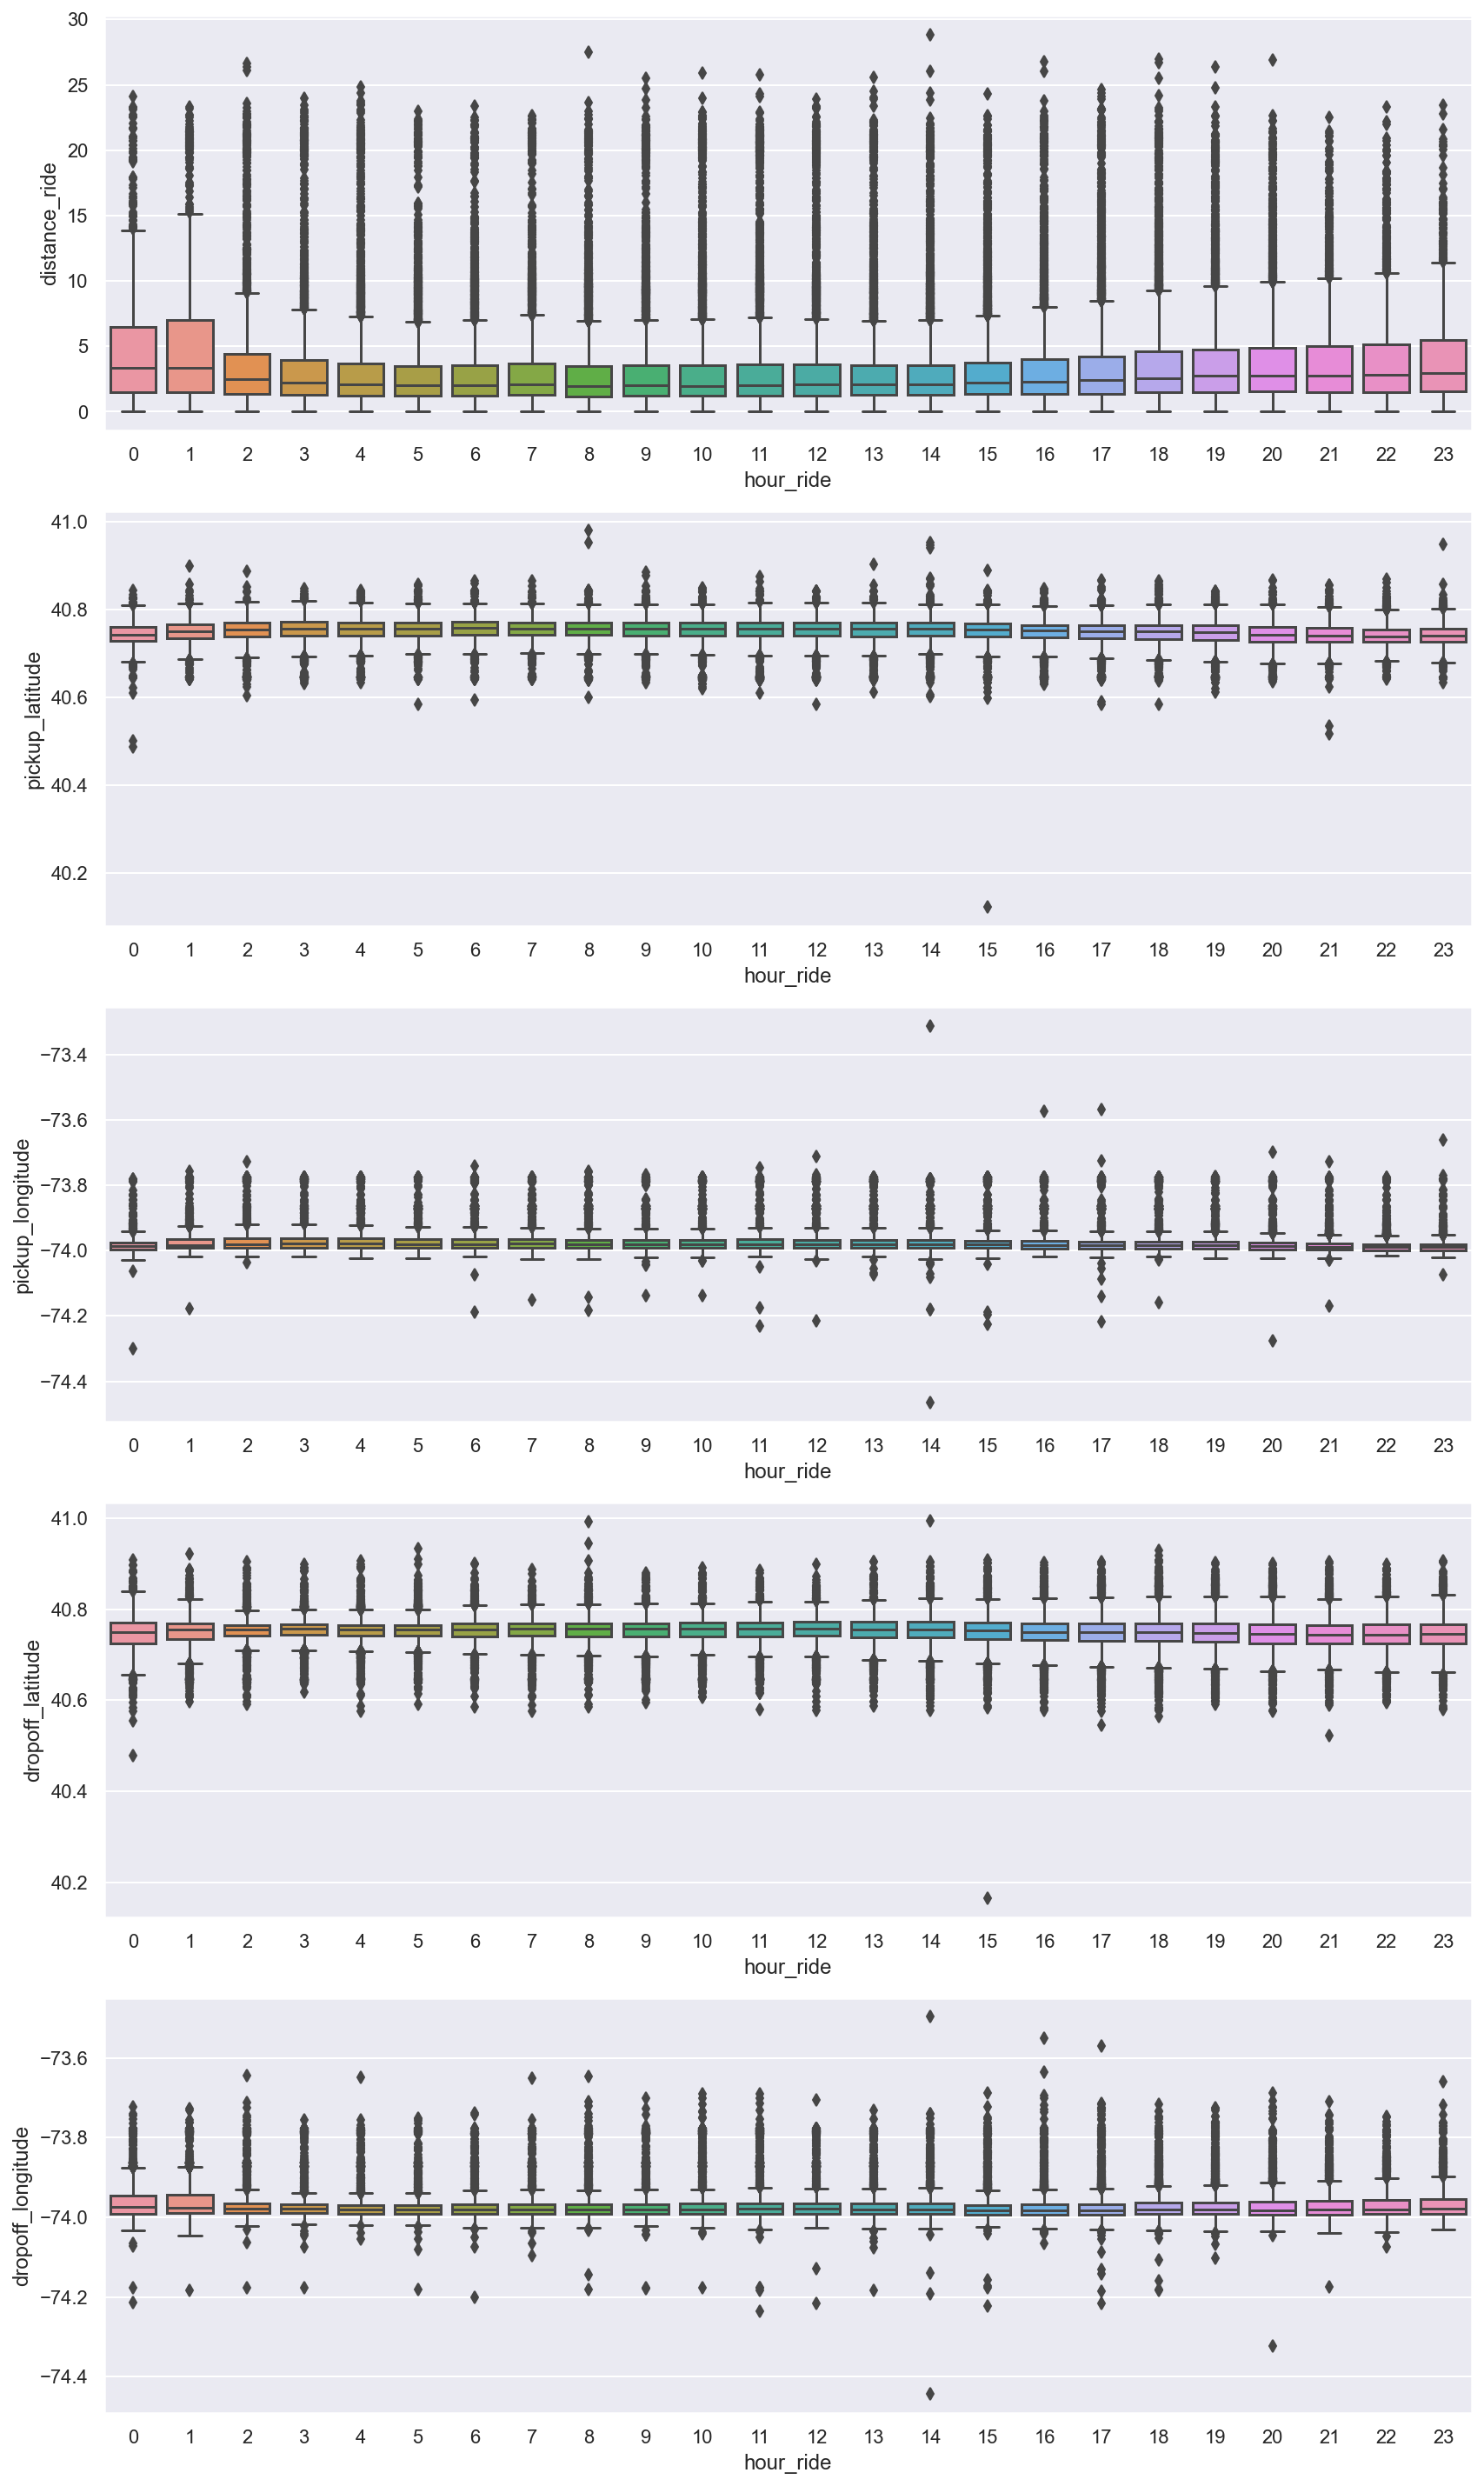

In [32]:
boxplot(
    data=df,
    num_cols=CONTINUOUS_FEATURES,
    by="hour_ride"
)

+ Numerical Columns according to `period_ride`:

There is no remarkable behavior here.

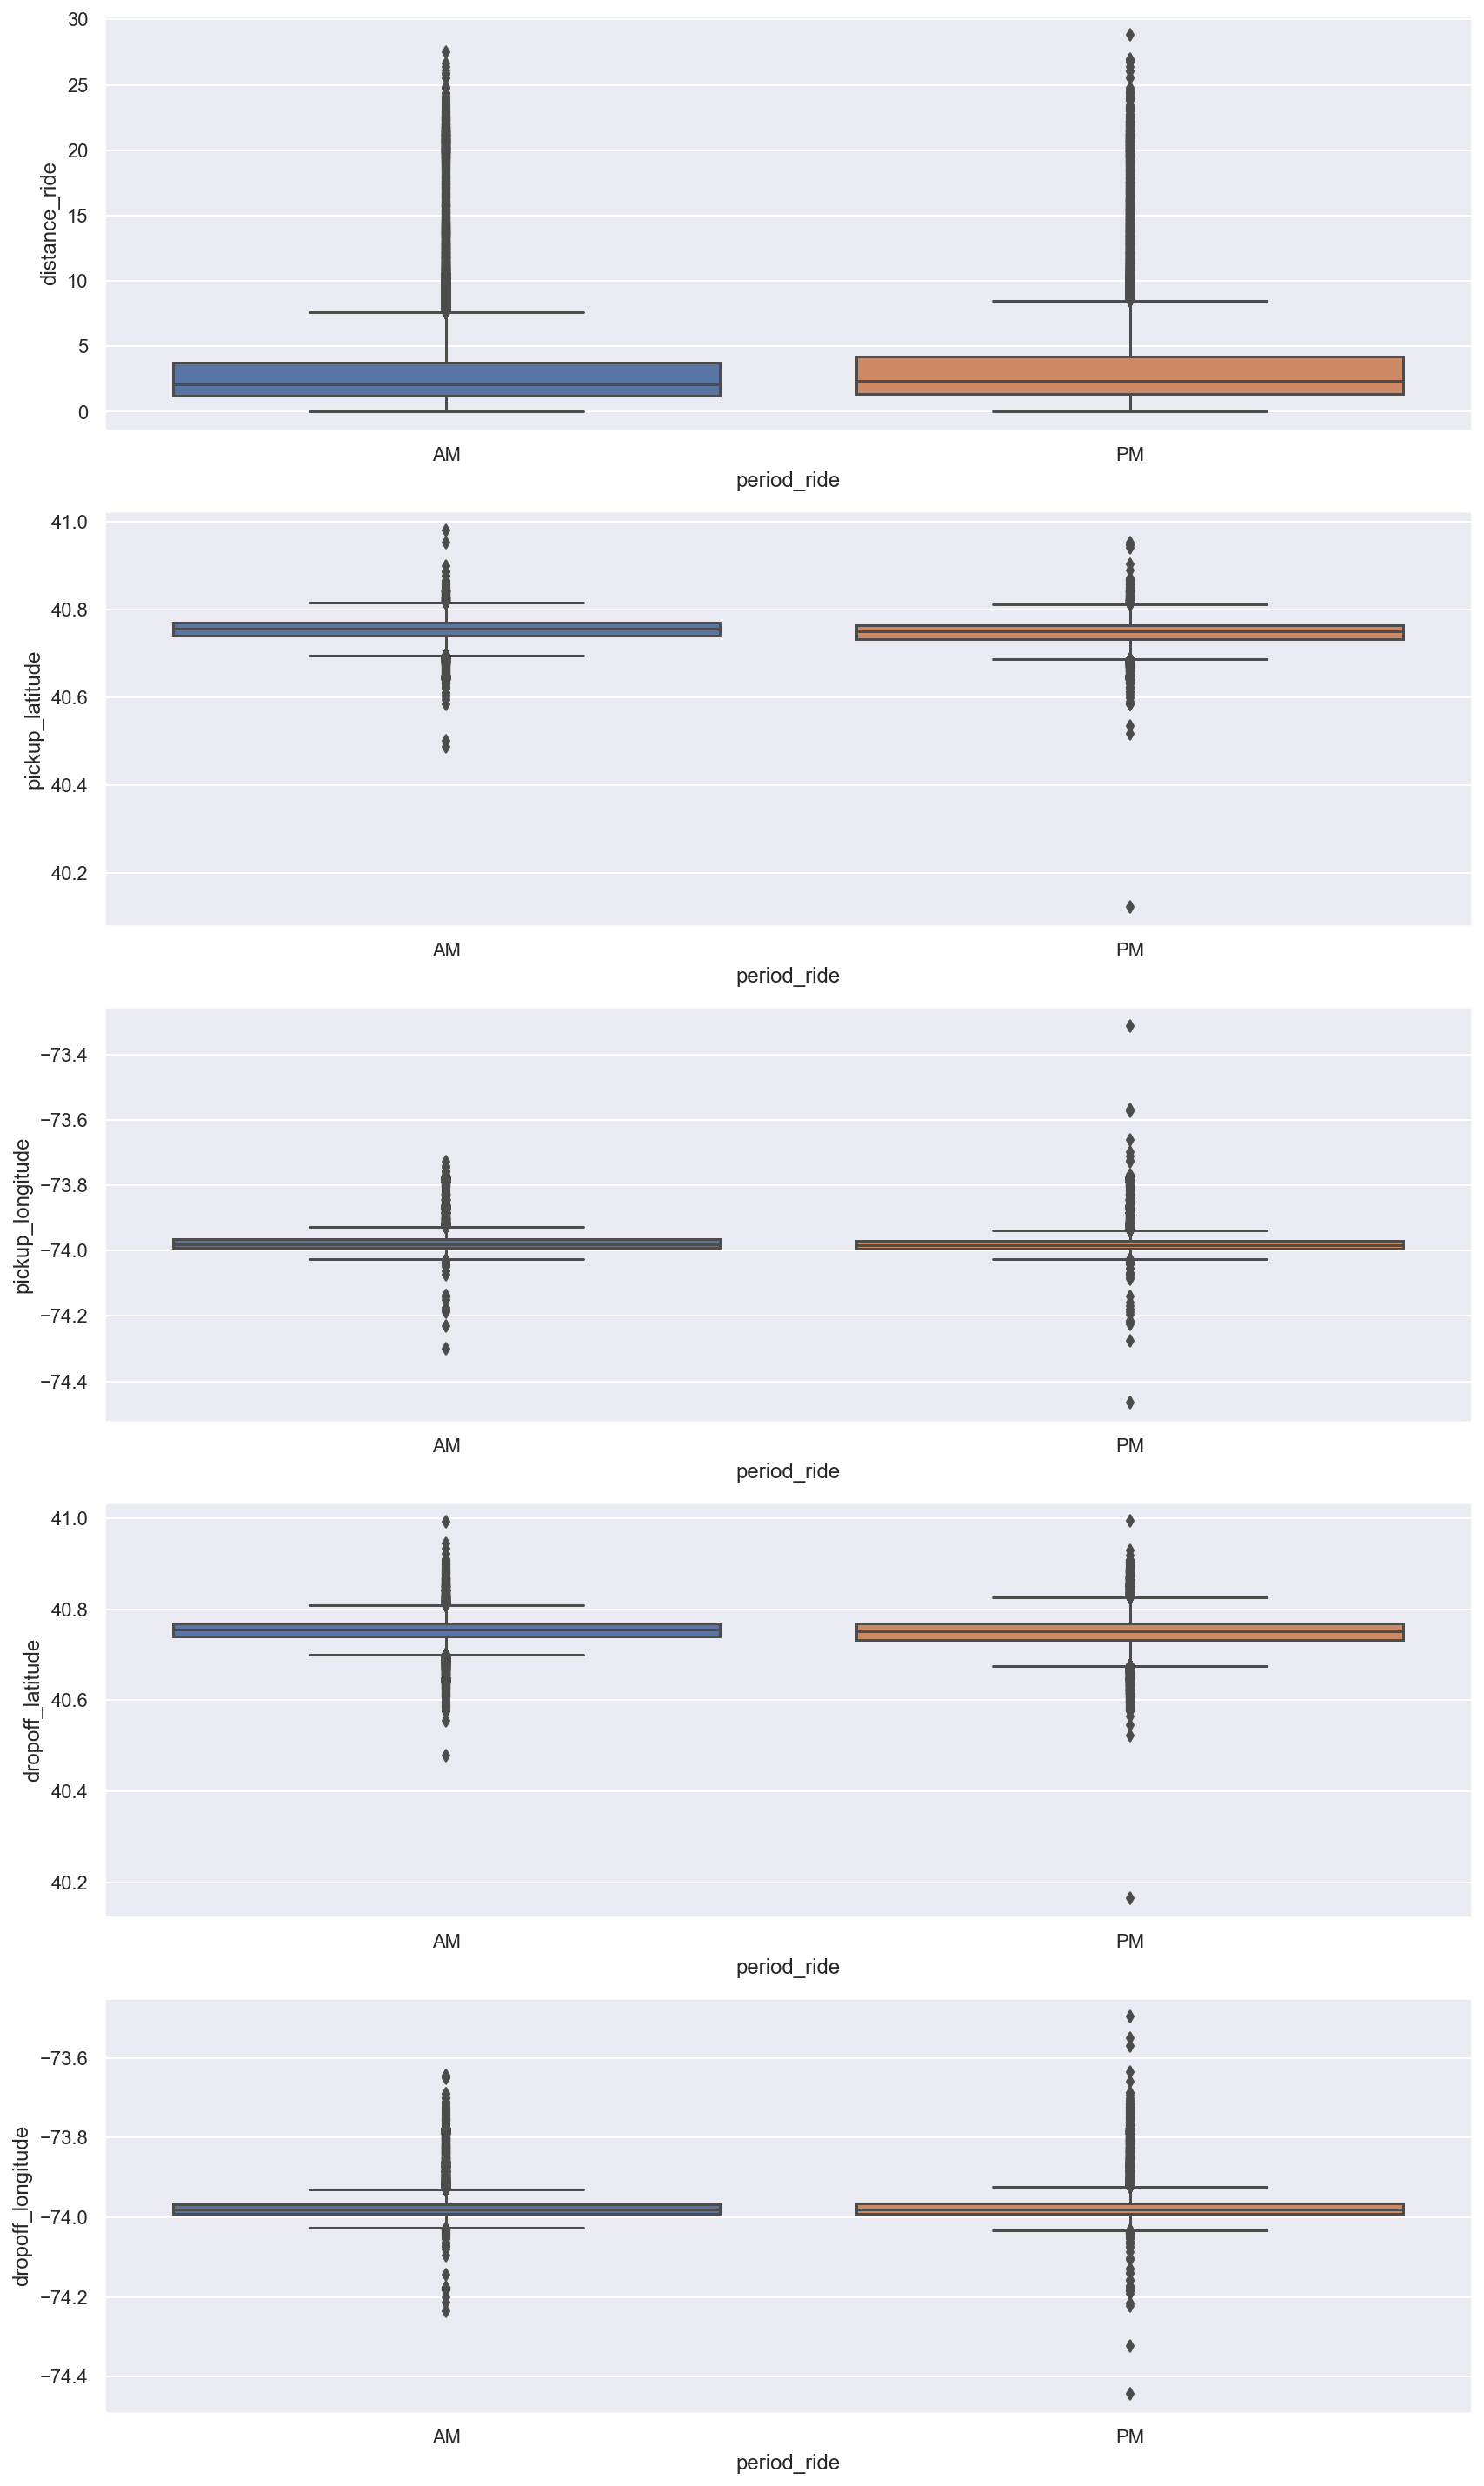

In [33]:
boxplot(
    data=df,
    num_cols=CONTINUOUS_FEATURES,
    by="period_ride"
)

+ Numerical Columns according to `day_ride`:

Distances are slightly higher on Sundays, which could be a consequence of people visting distant relatives and/or friends. This is an important factor, since distance is highly correlated to the price.

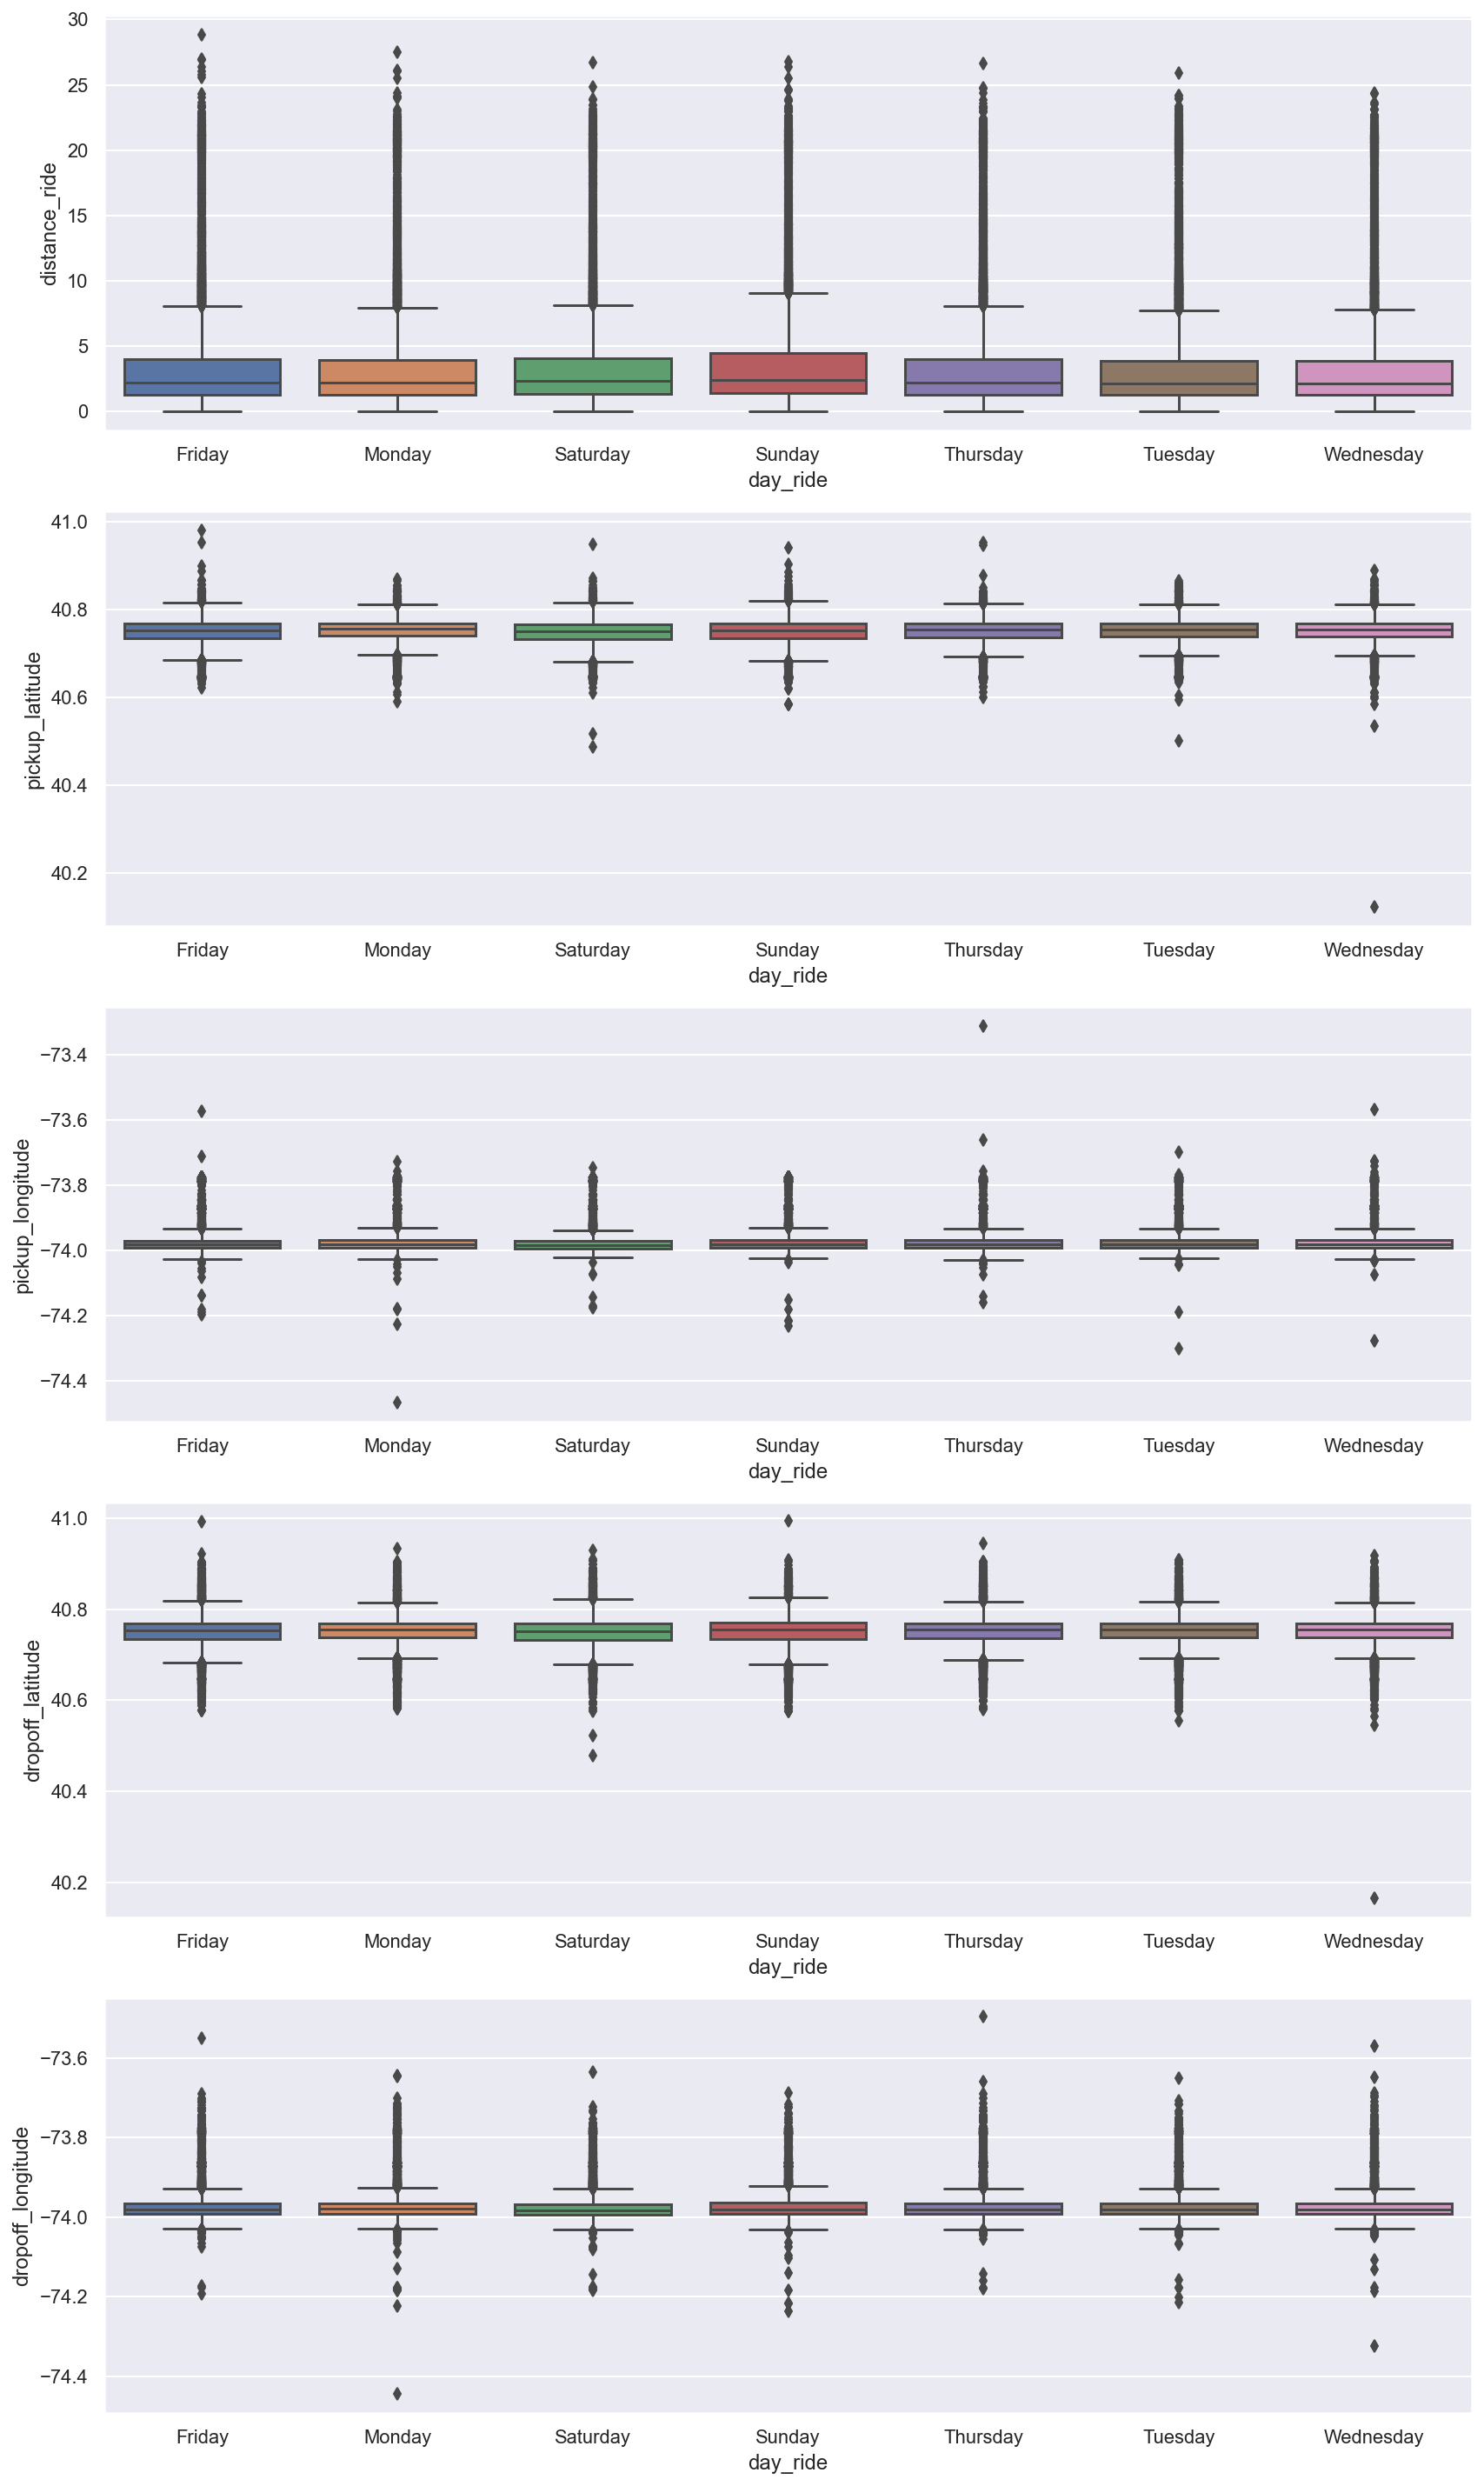

In [34]:
boxplot(
    data=df,
    num_cols=CONTINUOUS_FEATURES,
    by="day_ride"
)

+ Correlation Heatmap:

There are no features high correlated with each other, which is positive for any further model development. We want to preferrably deal with features that are independent from one another.

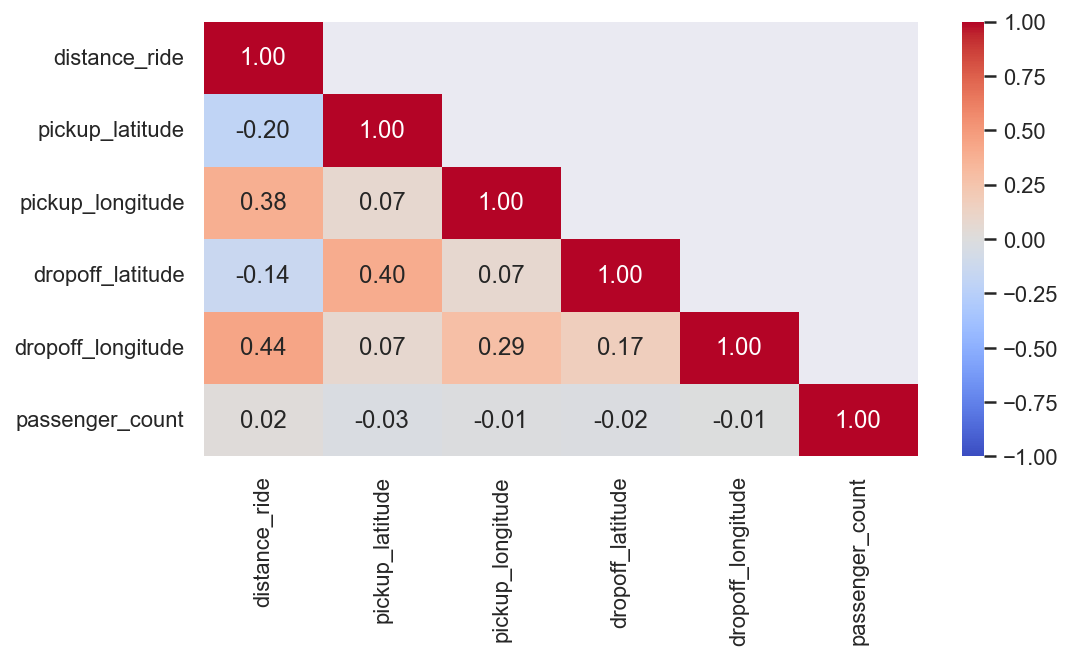

In [35]:
correlation_heatmap(
    data=df.loc[:, CONTINUOUS_FEATURES+INTEGER_FEATURES]
)

#### 4.3 Categorical Features

Now, let's take a look at categorical features. We will evaluate their basic statistics and generate visualizations such as countplots.

##### Univariate

+ Bulk Statistics

Regarding the number of unique categories, here is not any new knowledge here, since we are already aware that there are 7 days in a week, 24 hours in a day and only to periods as well (AM/PM).

However, it is quite interesting that taxi rides are more frequently on Fridays around 3pm. Supposedly we are talking about people that are leaving work and going out to have some deserved fun.

In [36]:
df.loc[:, CATEGORICAL_FEATURES].describe()

hour_ride period_ride day_ride
count      120000      120000   120000
unique         24           2        7
top            15          PM   Friday
freq         7100       63797    19720

+ Count Plots

Here we can see that taxi rides occur with the same frequency regardless of which day of week or period (AM/PM) we are talking about. On the other hand, taxi rides are more frequent during rush hours and rarer very late at night or very early in the morning. There are usually only singler riders.

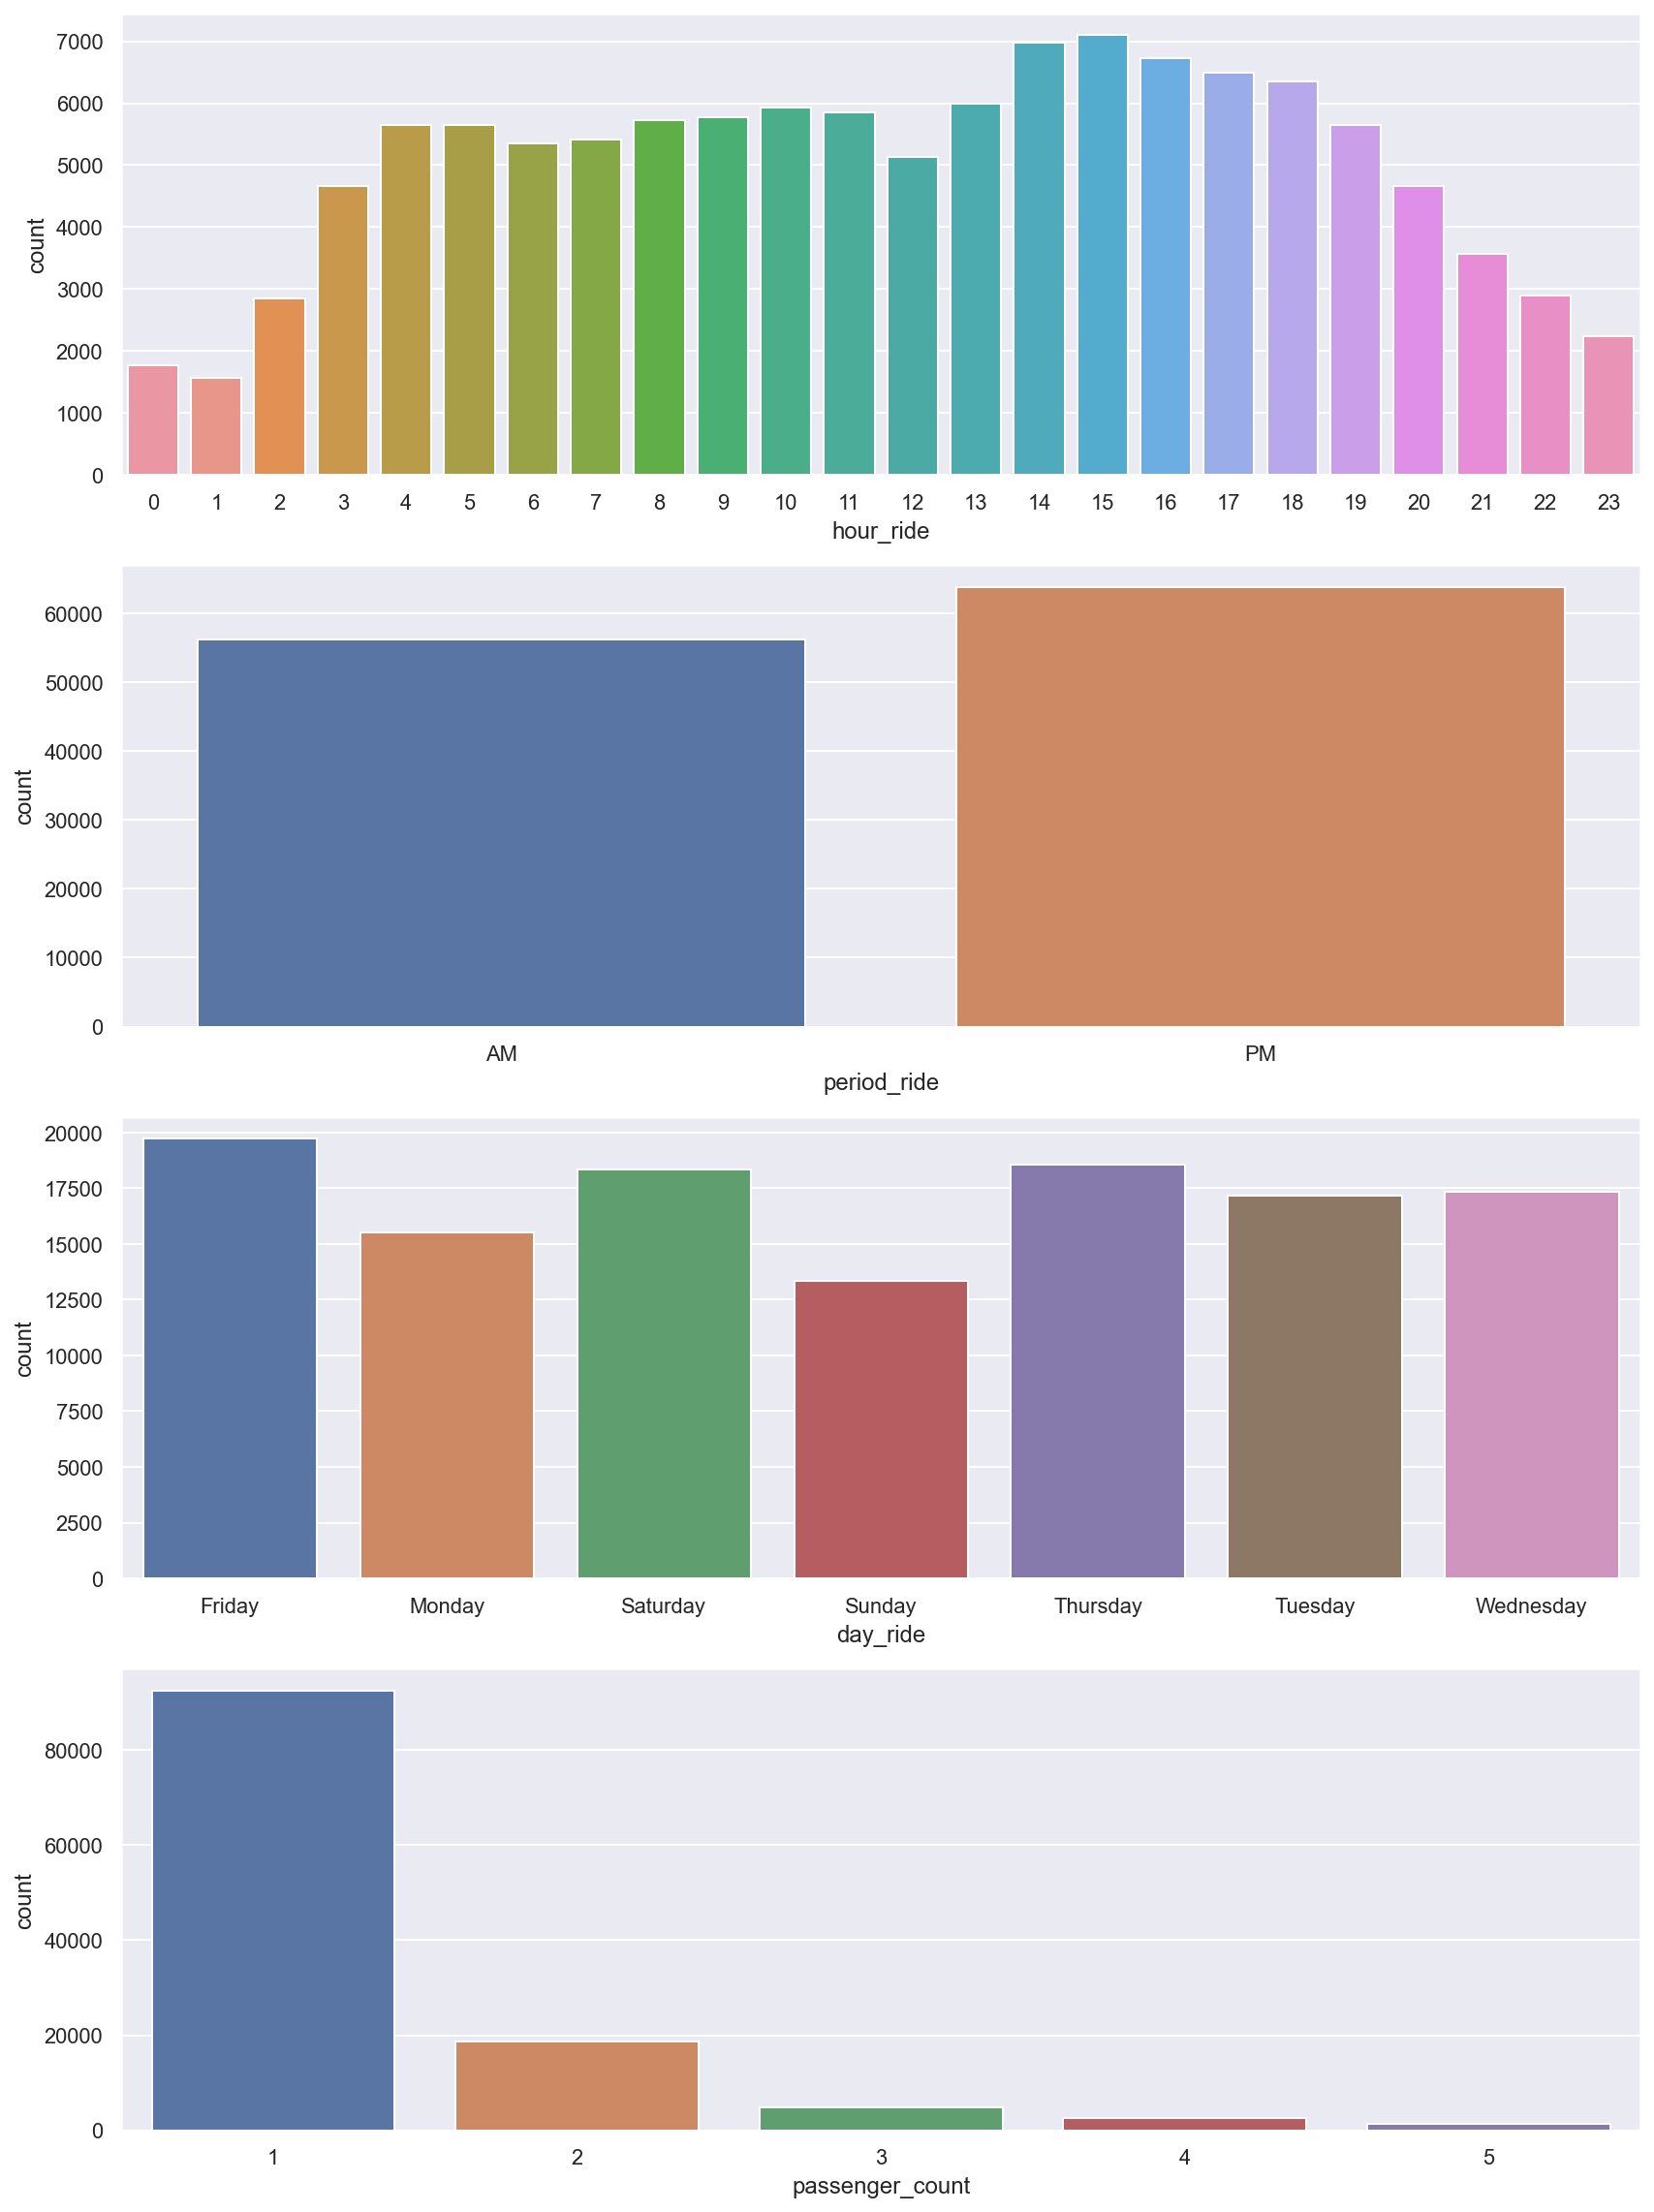

In [37]:
countplot(
    data=df,
    cat_cols=CATEGORICAL_FEATURES+INTEGER_FEATURES
)

##### Bivariate

+ Count Plots

In general, taxi rides show the same distribution regarding hour of the day. However, the distribution changes a little bit on weekends (Saturday and Sunday), when rides late at night or very early in the morning are more frequent, which is likely due to the fact that people are going out to bars, parties, and so forth.

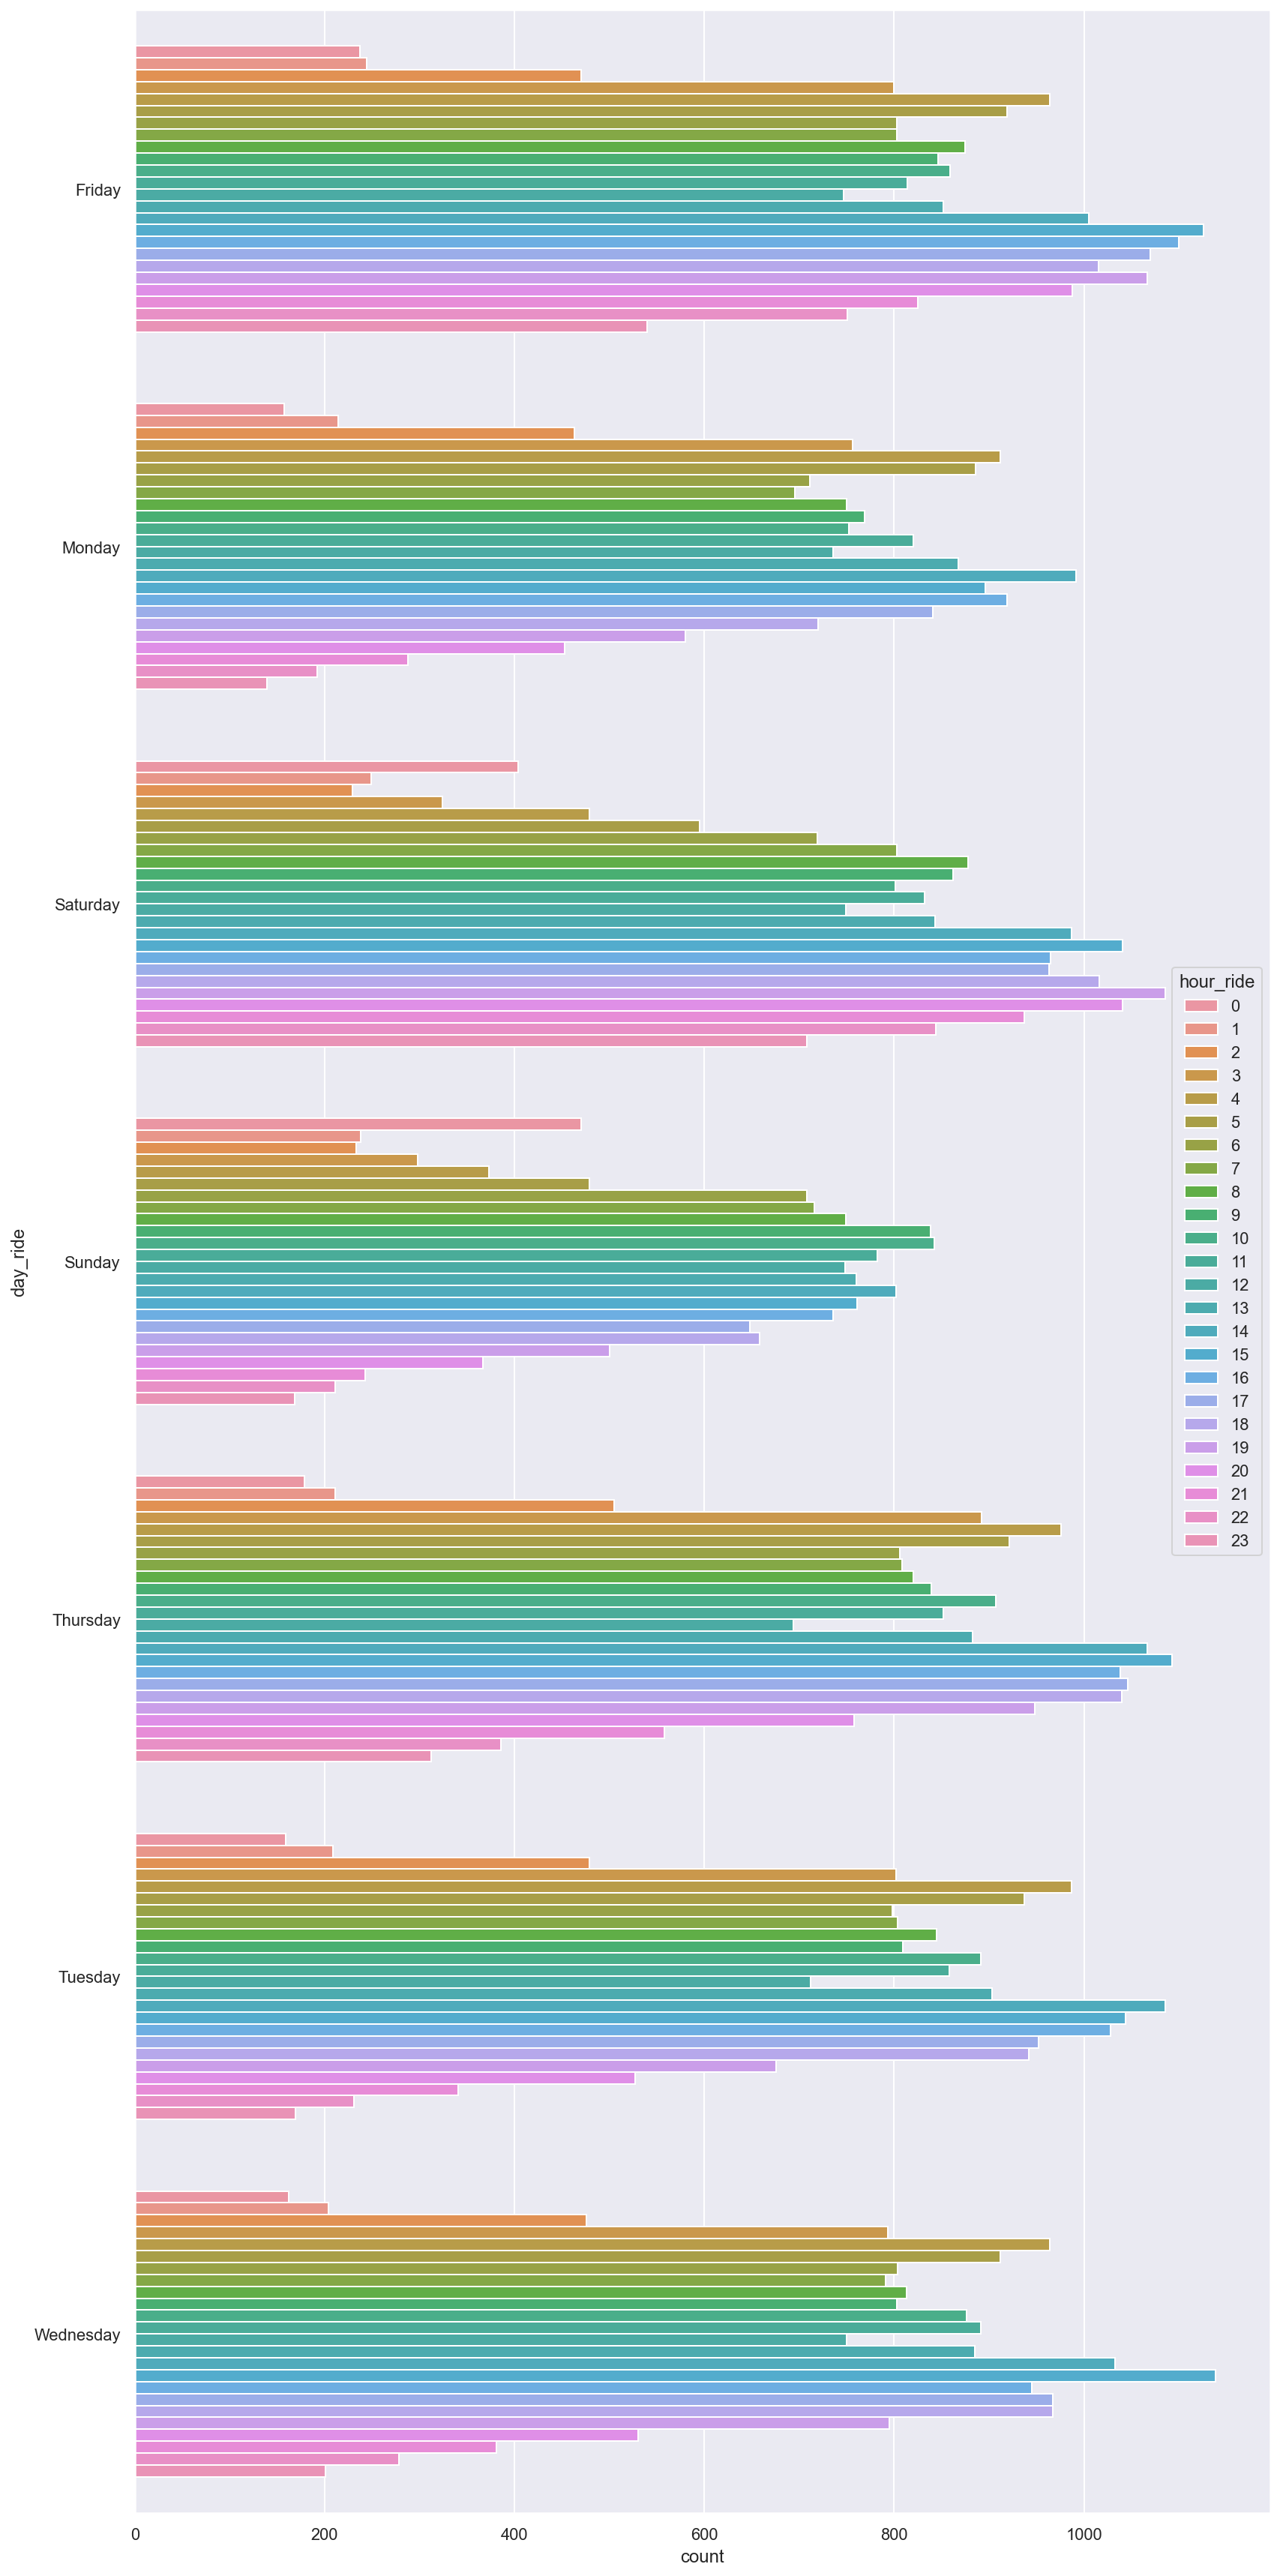

In [38]:
countplot(
    data=df,
    cat_cols=CATEGORICAL_FEATURES[2:],
    hue="hour_ride"
)

On Friday and Saturday, rides after noon are more frequent.

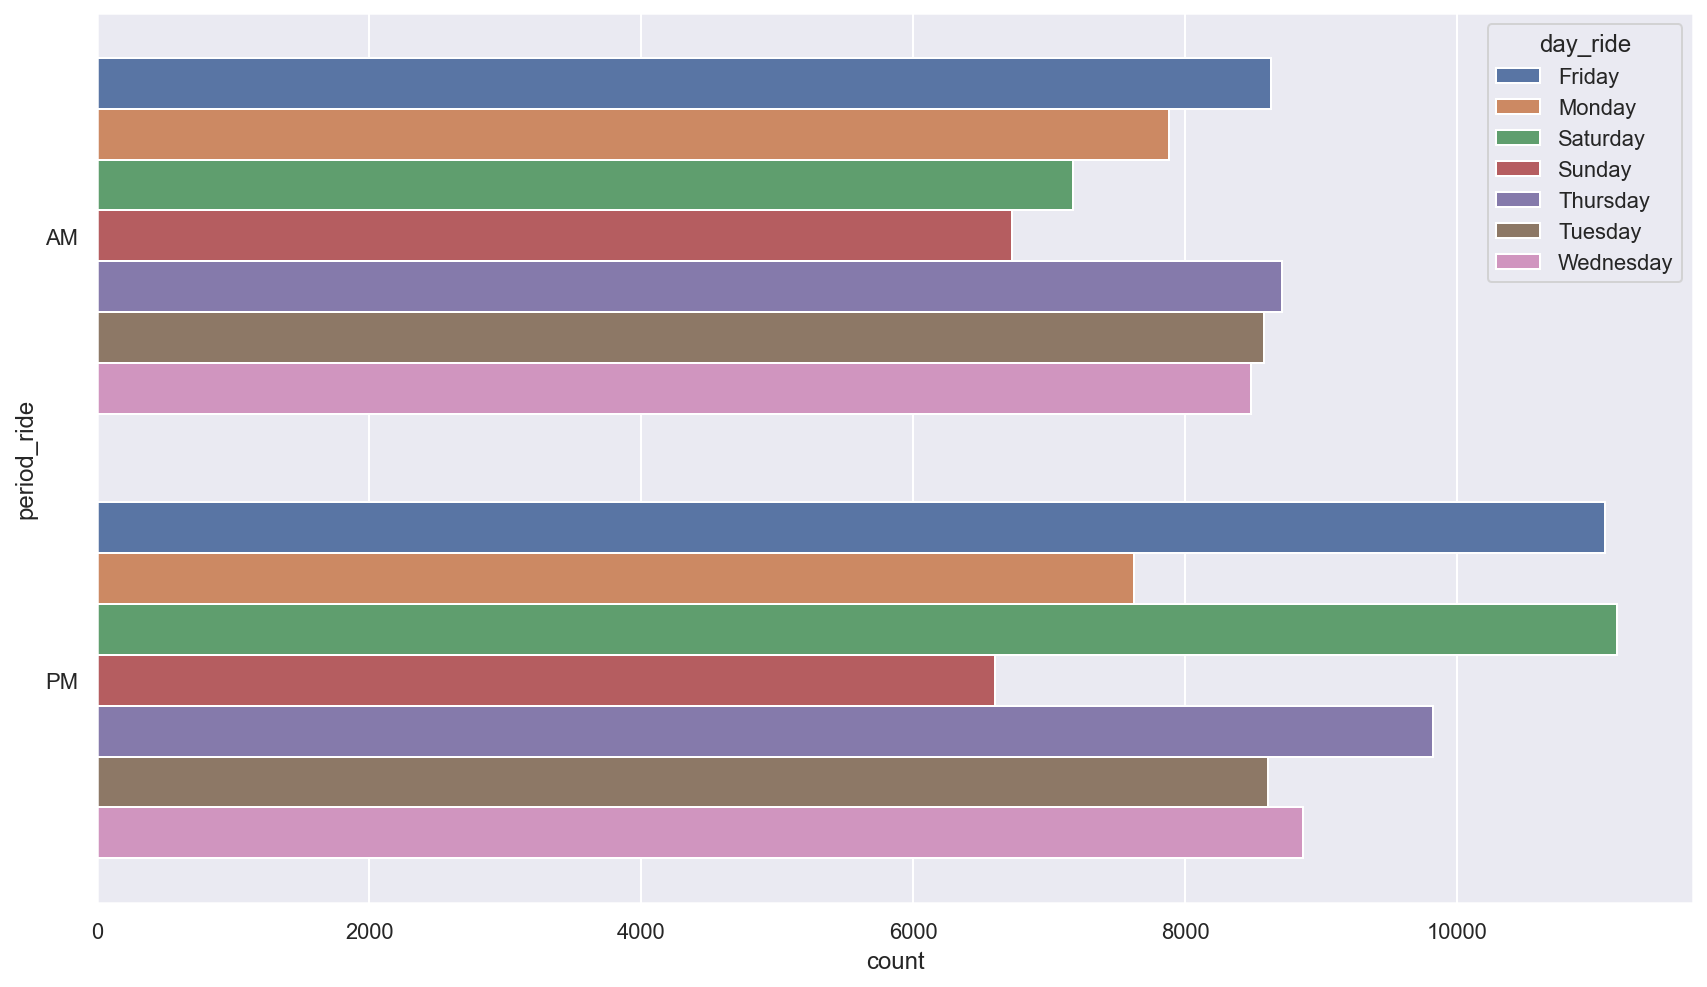

In [39]:
countplot(
    data=df,
    cat_cols=CATEGORICAL_FEATURES[1:2],
    hue="day_ride"
)

On weekends and after noon we observe a higher number of rides with more than one passenger.

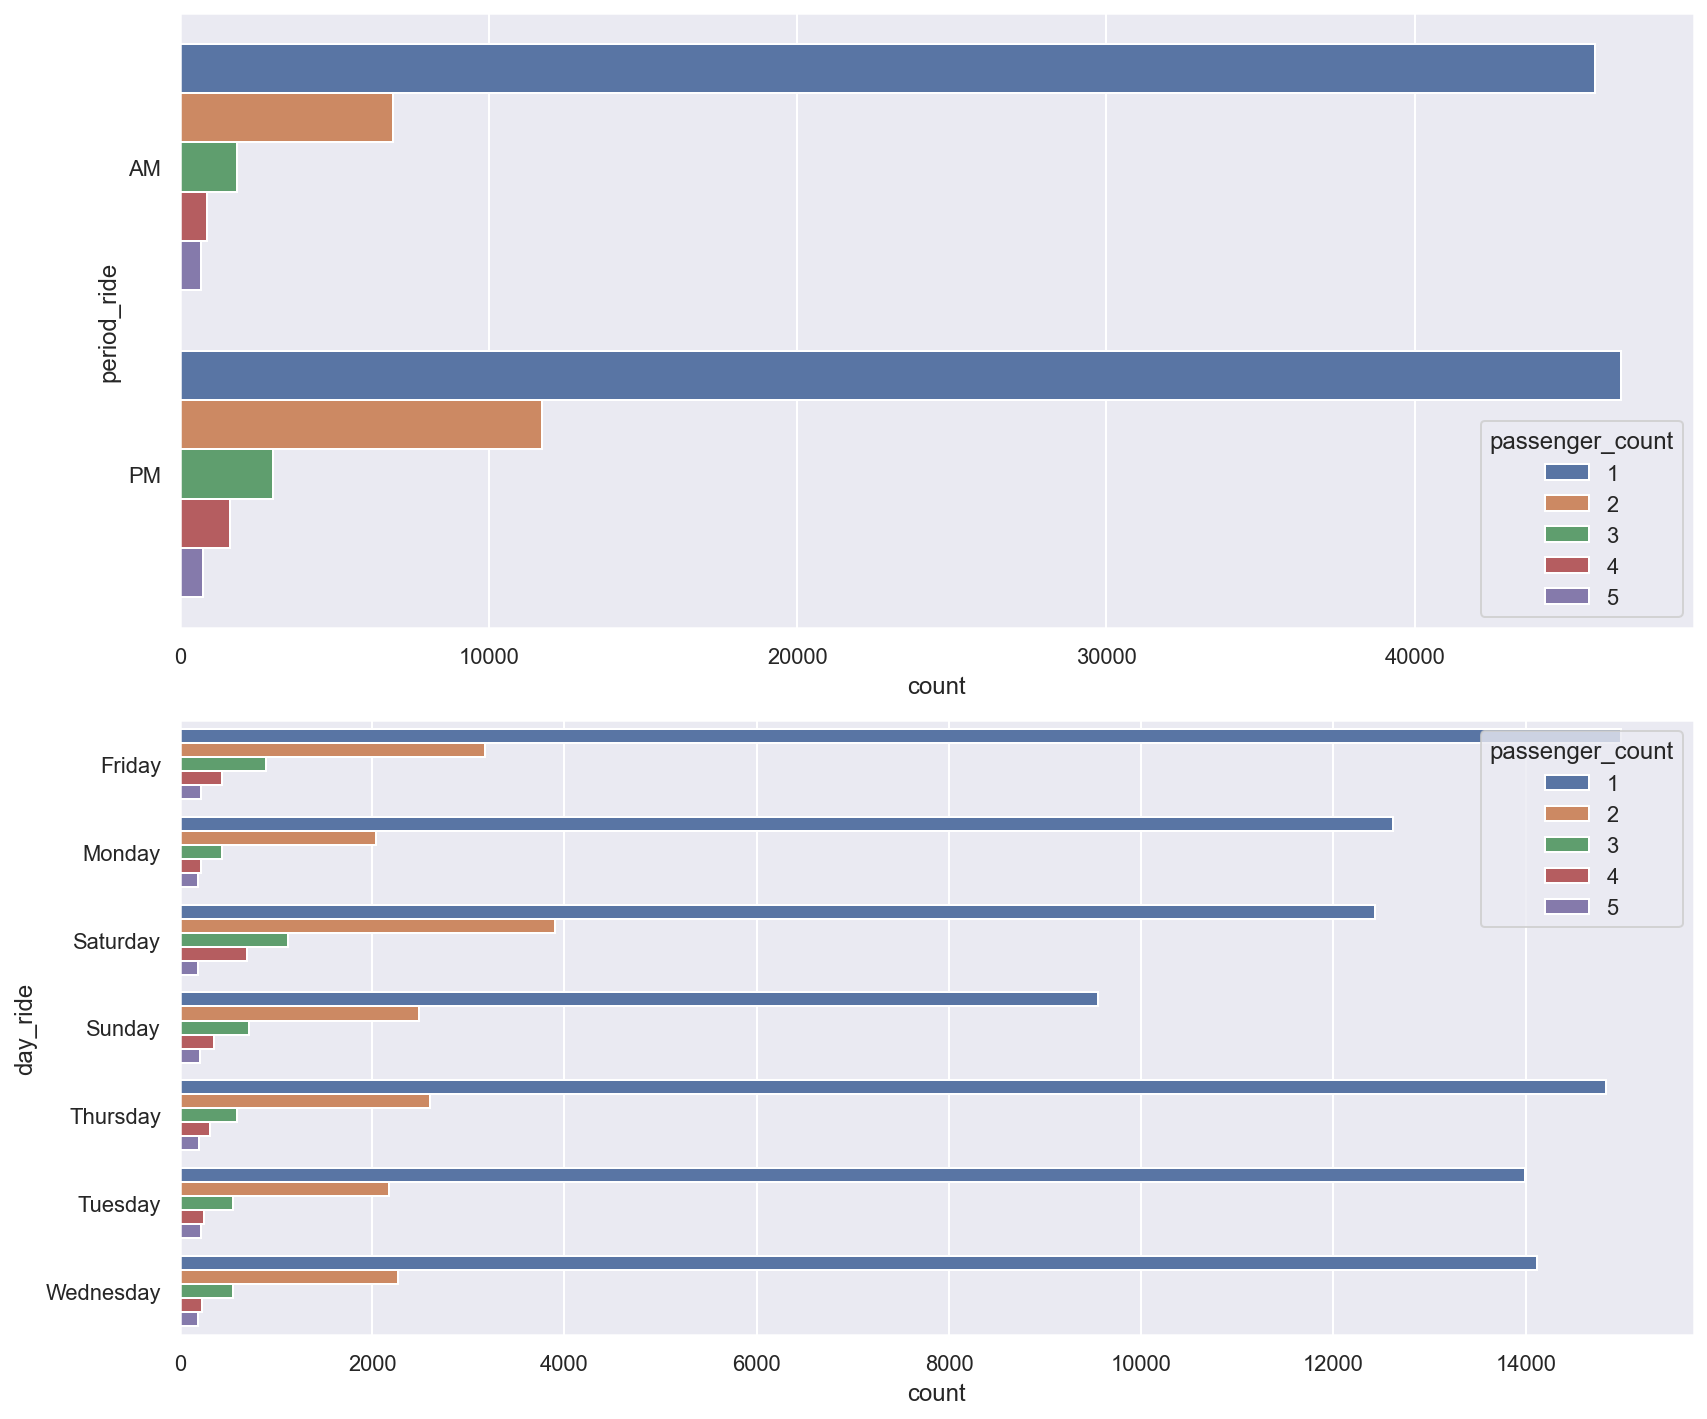

In [40]:
countplot(
    data=df,
    cat_cols=CATEGORICAL_FEATURES[1:],
    hue=INTEGER_FEATURES[0]
)

### 5. Model Development

Here we will develop our pipelines with data transformations and the downstream machine learning algorithm. It is worth noticing that each machine learning model might have different preprocessing steps according to its underlying characteristics.

We will build the following models and then compare performance between them in order to select the most performing one:

+ Simple Linear Regression;
+ Linear Regression with L1-Regularization (LASSO);
+ Random Forest;
+ Gradient Boosting Regressor.

However, before we start, it is necessary to perform some adjustments. 

##### 5.1 Importing data and Performing Feature Engineering

Let's import our dataset again and compute the new engineered features, just to guarantee that everything is in order and that there is no data leakage at all.

In [41]:
def engineer_features(data: pd.DataFrame, feature_cross: bool = True) -> pd.DataFrame:
    """
    Function that performs feature engineering to enrich a dataset.
    Transformations include haversine distance between (lat, lon) pairs and datetime information extraction.
    
    Args: 
        data (pandas dataframe): original dataset
        feature_cross (bool): True, if feature cross should be applied to day of week and 
        hour of day.
    
    Returns: 
        Dataset including new features
    """
    data.loc[:, "distance_ride"] = data.apply(
        calculate_distance("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"),
        axis=1
    )
    data.loc[:, "pickup_datetime"] = pd.to_datetime(data.loc[:, "pickup_datetime"])
    data.loc[:, "pickup_datetime_nyc"] = data.loc[:, "pickup_datetime"] - pd.Timedelta(hours=4)
    data.loc[:, "hour_ride"] = data.loc[:, "pickup_datetime_nyc"].dt.hour.astype("category")
    data.loc[:, "period_ride"] = (data.loc[:, "hour_ride"]
                                      .apply(lambda x: "AM" if x < 12 else "PM")
                                      .astype("category")
                                 )
    data.loc[:, "day_ride"] = data.loc[:, "pickup_datetime_nyc"].dt.strftime("%A").astype("category")
    if feature_cross:
        data.loc[:, "hour_day_ride"] = (
            data.loc[:, "day_ride"].astype(str) + "_" + data.loc[:, "hour_ride"].astype(str)
        )
        data = data.drop(columns=["day_ride", "hour_ride"])
        data.loc[:, "hour_day_ride"] = data.loc[:, "hour_day_ride"]
    return data


def prepare_data(data: pd.DataFrame, feature_engineering: bool = True, 
                 drop_columns: List[str] = None) -> pd.DataFrame:
    """
    Function that prepares data for the downstream prediction pipeline.
    Feature engineering and column removal can both be performed.
    
    Args: 
        data (pandas dataframe): original dataset
        feature_engineering (bool): True, if feature engineering shall be performed
        drop_columns (list of str): columns that are to be dropped
    
    Returns: 
        Dataset including new features
    """
    output = data.copy()
    if feature_engineering:
        output = engineer_features(output)
    if drop_columns is not None:
        output = output.drop(columns=drop_columns)
    return output

In [42]:
df = pd.read_csv("NYCTaxiFares.csv")
df = prepare_data(
    data=df,
    feature_engineering=True,
    drop_columns=["fare_class"]
)
df.head()

pickup_datetime  fare_amount  pickup_longitude  pickup_latitude  \
0 2010-04-19 08:17:56+00:00          6.5        -73.992365        40.730521   
1 2010-04-17 15:43:53+00:00          6.9        -73.990078        40.740558   
2 2010-04-17 11:23:26+00:00         10.1        -73.994149        40.751118   
3 2010-04-11 21:25:03+00:00          8.9        -73.990485        40.756422   
4 2010-04-17 02:19:01+00:00         19.7        -73.990976        40.734202   

   dropoff_longitude  dropoff_latitude  passenger_count  distance_ride  \
0         -73.975499         40.744746                1       2.126312   
1         -73.974232         40.744114                1       1.392307   
2         -73.960064         40.766235                2       3.326763   
3         -73.971205         40.748192                1       1.864129   
4         -73.905956         40.743115                1       7.231321   

        pickup_datetime_nyc period_ride hour_day_ride  
0 2010-04-19 04:17:56+00:00          AM      Monday_4  
1 2010-04-17 11:43:53+00:00          AM   Saturday_11  
2 2010-04-17 07:23:26+00:00          AM    Saturday_7  
3 2010-04-11 17:25:03+00:00          PM     Sunday_17  
4 2010-04-16 22:19:01+00:00          PM     Friday_22

##### 5.2 Data Splits

Then, we need to split our dataset into two sets:

+ **training set**: dataset which we will use to train the algorithms (further it will be split into an actual training set and a validation one to tune the hyperparameters);
+ **test set**: dataset containing new, previously unseen data in which we will evaluate the final models. This gives us a rouglhy estimate on how well any model will generalize to new data when it is deployed into a prodution environment.

In [43]:
SEED = 99
TEST_SIZE = 0.25

In [44]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=SEED)

Let's define lists containing features' column names, so we can facilitate data preprocessing and any transformations later on.

In [45]:
TARGET_COLUMN = ["fare_amount"]
CONTINUOUS_FEATURES_LOG = [
    "distance_ride"
]
CONTINUOUS_FEATURES = [
    "pickup_latitude", "pickup_longitude", 
    "dropoff_latitude", "dropoff_longitude"
]
INTEGER_FEATURES = ["passenger_count"]
CATEGORICAL_FEATURES = [
    "period_ride", "hour_day_ride"
]

Finally, we can define our features and target sets.

In [46]:
FEATS = CONTINUOUS_FEATURES_LOG + CONTINUOUS_FEATURES + INTEGER_FEATURES + CATEGORICAL_FEATURES

X_train, y_train = train_df.loc[:, FEATS], train_df.loc[:, TARGET_COLUMN]
X_test, y_test = test_df.loc[:, FEATS], test_df.loc[:, TARGET_COLUMN]

##### 5.3 Preprocessing/Transformations Steps

Now it is time to build extra functionality that might be useful for us in order to transform the data in ways that are beneficial to a machine learning algorithm.

In [47]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns: List[str]):
        """Custom sklearn transformer to select specific columns in a pandas dataframe.

        Attributes:
            columns (list of str) representing the names of columns to be selected
                
        """
        self.__columns = columns
        self.__df = pd.DataFrame
        
    @property
    def columns(self):
        return self.__columns
    
    def fit(self, X, y=None):
        assert isinstance(X, self.__df), \
            "X must be a pandas DataFrame"
        return self
    
    def transform(self, X):
        assert isinstance(X, self.__df), \
            "X must be a pandas DataFrame"
        return X.loc[:, self.__columns]


class NumericalPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, apply_log: bool = False, scaling: str = "min_max"):
        """Custom sklearn transformer to perform transformations to numerical features.

        Attributes:
            apply_log (bool) representing whether or not logarithm should be applied
            scaling (str) representing the scaling method (either `min_max` or `standard`)
                
        """
        self.__apply_log = apply_log
        assert scaling in ["min_max", "standard"], \
            "`scaling` should be either 'min_max' or 'standard'"
        self.__scaling = scaling
        if self.__scaling == "min_max":
            self.__scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            self.__scaler = StandardScaler()
        self.__log = np.log
        self.__exp = np.exp
        
    @property
    def scaling(self):
        return self.__scaling
    
    @property
    def apply_log(self):
        return self.__apply_log
    
    def fit(self, X, y=None):
        X_ = X.copy()
        if self.__apply_log:
            X_ = self.__log(X_)
        self.__scaler.fit(X_, y)
        return self
    
    def transform(self, X):
        X_ = X.copy()
        if self.__apply_log:
            X_ = self.__log(X_)
        return self.__scaler.transform(X_)
    
    def inverse_transform(self, X):
        X_ = X.copy()
        X_ = self.__scaler.inverse_transform(X_)
        if self.__apply_log:
            X_ = self.__exp(X_)
        return X_

It is also important to think about **feature selection**, since our final dataset will have a high dimensionality after one hot encoding the categorical features. Lasso, Random Forest and Gradient Boosting already perform feature selection by design, since they have adjustable hyperparameters that neglects unimportant features. However, for simpler models like simple linear regression, we need to come up with an algorithm that can help us select the most important features for our problem.

Here we will use **Boruta**, an empirical approach to select the best features that is based on features and their associated shadow features - i.e., original features in a random order. The main idea is to fit a decision tree on the whole set, and then keep the features that present an importance greater than all shadow features.

In [48]:
class BorutaFeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, trials: int, percentile: float = 0.005,
                 keep_only_tail: bool = False, random_state: int = 99):
        """Custom sklearn transformer to perform feature selection according to Boruta method.

        Attributes:
            trials (int) representing the number of trials to be performed
            percentile (float) representing the percentile to exclude irrelevant features
            keep_only_tail (bool) representing whether or not to discard intermediate features
            random_state (int) representing the seed
                
        """
        self.__PROBABILITY_BINOMIAL = 0.5
        self.__trials = trials
        self.__percentile = percentile
        self.__keep_only_tail = keep_only_tail
        self.__random_state = random_state
        self.__feature_importance_results = dict()
        self.__dt = DecisionTreeRegressor(max_depth=5, random_state=random_state)
        self.__selected_features = None
        
    @property
    def trials(self):
        return self.__trials
    
    @property
    def percentile(self):
        return self.__percentile
    
    @property
    def keep_only_tail(self):
        return self.__keep_only_tail
    
    @property
    def random_state(self):
        return self.__random_state
    
    @property
    def selected_features(self):
        return self.__selected_features
    
    @property
    def feature_importance_results(self):
        return self.__feature_importance_results
    
    def __get_shadow_features(self, X):
        X_boruta = X.copy()
        for i in range(X.shape[1]):
            X_boruta = np.append(X_boruta, np.random.permutation(X_boruta[:, i:i+1]), axis=1)
        return X_boruta
    
    def __get_binomial_distribution(self, only_percentiles: bool = False):
        x = np.arange(self.__trials + 1)
        pmf = [sp.stats.binom.pmf(x, self.__trials, self.__PROBABILITY_BINOMIAL) \
               for x in range(self.__trials + 1)]
        lower_x = int(sp.stats.binom.ppf(self.__percentile, self.__trials, self.__PROBABILITY_BINOMIAL))
        upper_x = int(sp.stats.binom.ppf(1-self.__percentile, self.__trials, self.__PROBABILITY_BINOMIAL))
        if only_percentiles:
            return (lower_x, upper_x)
        return (x, pmf), (lower_x, upper_x)
    
    def summary(self, ):
        assert self.__selected_features is not None, "Transformer not fitted yet!"
        
        features_to_drop = []
        features_to_tentatively_keep = []
        features_to_keep = []
        
        lower_x, upper_x = self.__get_binomial_distribution(only_percentiles=True)
        
        for col, hits in self.__feature_importance_results.items():
            to_print = f"[hits: {hits}]"
            if hits <= lower_x:
                features_to_drop.append(f"{col:20} {to_print}")
            elif hits < upper_x:
                features_to_tentatively_keep.append(f"{col:20} {to_print}")
            else:
                features_to_keep.append(f"{col:20} {to_print}")
        
        length = 50
        print("*"*length)
        title = "SUMMARY"
        length_blank = (length-len(title)-2)//2
        print("*"+" "*length_blank+title+" "*(length_blank+(length-len(title)-2)%2)+"*")
        print("*"*length, end="\n\n")
        
        print(f">> Features to drop (<= {lower_x}):", end="\n\t")
        text = ""
        if len(features_to_drop) > 0:
            text = "* "+"\n\t* ".join(features_to_drop)
        print(text, end="\n\n")
        
        print(f">> Features to tentatively keep ({lower_x} < hits < {upper_x}):", end="\n\t")
        text = ""
        if len(features_to_tentatively_keep) > 0:
            text = "* "+"\n\t* ".join(features_to_tentatively_keep)
        print(text, end="\n\n")
        
        print(f">> Features to drop (>= {upper_x}):", end="\n\t")
        text = ""
        if len(features_to_keep) > 0:
            text = "* "+"\n\t* ".join(features_to_keep)
        print(text, end="\n\n")
        
    
    def show_decision_regions(self, show_features: bool = False):
        assert self.__selected_features is not None, "Transformer not fitted yet!"
        
        colors = ["red", "blue", "green"]
        alpha = 0.25
        (x, pmf), (lower_x, upper_x) = self.__get_binomial_distribution()
        
        plt.figure(figsize=(12,6))
        
        plt.fill_between(x[:lower_x+1], pmf[:lower_x+1], alpha=alpha, color=colors[0])
        sns.scatterplot(y=pmf[:lower_x+1], x=x[:lower_x+1], color=colors[0], label="drop")

        plt.fill_between(x[lower_x:upper_x+1], pmf[lower_x:upper_x+1], alpha=alpha, color=colors[1])
        sns.scatterplot(y=pmf[lower_x:upper_x+1], x=x[lower_x:upper_x+1], 
                        color=colors[1], label="tentatively keep")

        plt.fill_between(x[upper_x:], pmf[upper_x:], alpha=alpha, color=colors[2])
        sns.scatterplot(y=pmf[upper_x:], x=x[upper_x:], color=colors[2], label="keep")
        
        if show_features:
            for col, hits in self.__feature_importance_results.items():
                plt.annotate(col, (hits, sp.stats.binom.pmf(hits, self.__trials, self.__PROBABILITY_BINOMIAL)), 
                             arrowprops=dict(arrowstyle="->"), textcoords="offset points",
                             xytext=(np.random.randint(-50, 50), np.random.randint(50, 200)))

        plt.title("Boruta | Decision Zones")
        plt.ylabel(f"Binomial Distribution pmf | n = {self.__trials}, p = {self.__PROBABILITY_BINOMIAL}")
        plt.xlabel(f"Number of hits for {self.__trials} trials")

        plt.legend()
        plt.show()
    
    def fit(self, X, y=None):
        X_ = X.copy()
        original_features = np.arange(X_.shape[1])
        hits = np.zeros(len(original_features), dtype=np.int32)
        for _ in range(self.__trials):
            X_concat = self.__get_shadow_features(X_)
            self.__dt.fit(X_concat, y)
            feature_importance = self.__dt.feature_importances_
            feature_importance_original = feature_importance[:X_.shape[1]]
            max_importance_shadow = np.max(feature_importance[X_.shape[1]:])
            hits += (feature_importance_original > max_importance_shadow)
        
        lower_x, upper_x = self.__get_binomial_distribution(only_percentiles=True)
        self.__feature_importance_results = {c: hit for c, hit in zip(original_features, hits)}
        filter_value = lower_x
        if self.__keep_only_tail:
            filter_value = upper_x
        self.__selected_features = [col for col, imp in self.__feature_importance_results.items() \
                                            if imp > filter_value]
        return self
        
    def transform(self, X):
        assert self.__selected_features is not None, "Transformer not fitted yet!"
        return X[:, self.__selected_features]

##### 5.4 Adjusting Target Variable

As we have previously noticed, it is pretty useful to apply logarithm and then scale our target variable, since simple algorithms especially prodfit from this.

In [49]:
target_transformer = NumericalPreprocessor(apply_log=True, scaling="standard")

y_train_adj = target_transformer.fit_transform(y_train).reshape(-1)
y_test_adj = target_transformer.transform(y_test).reshape(-1)

##### 5.5 Defining preprocessing steps and candidate models

Now it is time to look at the core of any machine learning pipeline: preprocessing features and training alogrithms to which those features are fed. Since we will study more than one algorithm, we need to build these candidate models.

In [50]:
def define_preprocessing_pipeline(continuous_features_log: List[str],
                                  continuous_features: List[str],
                                  integer_features: List[str],
                                  categorical_features: List[str]) -> Pipeline:
    """
    Function that builds the preprocessing pipeline.
    
    Args: 
        continuous_features_log (list of str): numerical columns to apply logarithm and normalization
        continuous_features (list of str): numerical columns to apply normalization
        integer_features (list of str): integer columns to apply min-max scaling
        categorical_features (list of str): categorical columns to one-hot encode
        
    Returns: 
        Pipeline object to preprocess the input features.
    """
    
    continuous_log_preprocessing = Pipeline(steps=[
        ("continuous_log_feats_selector", ColumnSelector(columns=continuous_features_log)),
        ("log_scaling", NumericalPreprocessor(apply_log=True, scaling="standard"))
    ])
    continuous_preprocessing = Pipeline(steps=[
        ("continuous_feats_selector", ColumnSelector(columns=continuous_features)),
        ("scaling", NumericalPreprocessor(apply_log=False, scaling="standard"))
    ])
    integer_preprocessing = Pipeline(steps=[
        ("integer_feats_selector", ColumnSelector(columns=integer_features)),
        ("scaling", NumericalPreprocessor(apply_log=False, scaling="min_max"))
    ])
    categorical_preprocessing = Pipeline(steps=[
        ("categorical_feats_selector", ColumnSelector(columns=categorical_features)),
        ("oh_encoding", OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])
    
    preprocessing = FeatureUnion(transformer_list=[
        ("continuous_log_preprocessing", continuous_log_preprocessing),
        ("continuous_preprocessing", continuous_preprocessing),
        ("integer_preprocessing", integer_preprocessing),
        ("categorical_preprocessing", categorical_preprocessing),
    ])
    
    return preprocessing


def define_candidate_models() -> List[Tuple]:
    """
    Function that returns candidate models.
    
    Args: 
        None
        
    Returns: 
        List of tuples containing: model name, model object itself and parameters search hyperspace.
    """
    models_names = [
        "linear_regression", "lasso",
        "random_forest", "gradient_boosting"
    ]
    
    lr = LinearRegression()
    lasso = Lasso(random_state=SEED)
    rf = RandomForestRegressor(random_state=SEED)
    gbc = GradientBoostingRegressor(random_state=SEED)
    models =[lr, lasso, rf, gbc]
    
    lr_params = dict()
    lasso_params = {
        "lasso__alpha": np.logspace(-2, 2, 9)
    }
    rf_params = {
        "random_forest__n_estimators": np.arange(50, 110, 25),
        "random_forest__max_depth": np.arange(3, 7, 1),
    }
    gbc_params = {
        "gradient_boosting__n_estimators": np.arange(10, 110, 30),
        "gradient_boosting__max_depth": np.arange(3, 7, 1),
        "gradient_boosting__learning_rate": np.logspace(-3, -1, 3)
    }
    models_params = [lr_params, lasso_params, rf_params, gbc_params]
    
    return list(zip(models_names, models, models_params))

Now that we have suitable functions to build our preprocessor and our candidate models, we are going to tune their hyperparameters by using **GridSearch**.

In [51]:
def run_grid_search(models_candidates: List[Tuple], preprocessor: Pipeline,
                    feature_selection: List[bool], X_train: pd.DataFrame, y_train: pd.DataFrame,
                    scoring: str = "neg_mean_squared_error", cv: int = 3,
                    verbose: bool = False) -> dict:
    
    """
    Function that runs hyperparameter tuning for each candidate model using GridSearch.
    
    Args: 
        models_candidates (list of tuple): model name, model object itself and parameters search hyperspace
        preprocessor (sklearn Pipeline): Pipeline object to preprocess the input features.
        feature_selection (list of bool): Whether or not to apply feature selection
        X_train (pandas DataFrame): input features
        y_train (numpy array): transformed target
        scoring (str): scoring metric for which we will optimize
        cv (int): number of CV folds
        verbose (bool): if True, status is displayed on screen
        
    Returns: 
        List of best models after having found best hyperparameters.
    """

    best_models = dict()
    for (model_name, model, model_params), feat_selection in zip(models_candidates, feature_selection):
        if verbose:
            print(f"[{model_name.upper()}]")
        if feat_selection:
            pipeline = Pipeline(steps=[
                ("preprocessor", preprocessor),
                ("feature_selection", BorutaFeatureSelector(trials=10, random_state=SEED)),
                (model_name, model)
            ])
        else:
            pipeline = Pipeline(steps=[
                ("preprocessor", preprocessor),
                (model_name, model)
            ])
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=model_params,
            scoring=scoring,
            refit=True,
            return_train_score=True,
            cv=cv
        )
        
        grid_search = grid_search.fit(X_train, y_train)
        
        mse_train = -1*grid_search.cv_results_["mean_train_score"][grid_search.best_index_]
        mse_train_std = grid_search.cv_results_["std_train_score"][grid_search.best_index_]
        mse_val = -1*grid_search.cv_results_["mean_test_score"][grid_search.best_index_]
        mse_val_std = grid_search.cv_results_["std_test_score"][grid_search.best_index_]
        best_params = "\n\t\t- ".join([f'{k.split("__")[-1]} = {v:.4f}' \
                                       for k, v in grid_search.best_params_.items()])
        
        if verbose:
            print(f"\tBest parameters:\n\t\t- {best_params}")
            print(f"\tTrain MSE: {mse_train:.4f} ± {mse_train_std:.4f}")
            print(f"\t  Val MSE: {mse_val:.4f} ± {mse_val_std:.4f}", end="\n\n")

        best_models[model_name] = grid_search.best_estimator_
        
    return best_models

##### 5.6 Running Grid Search to fine tune each one of the candidate models

Below we run our hyperparameter tuning step, in order to find the best performing models for each candidate.

In [52]:
CV_FOLDS = 3

In [53]:
preprocessor = define_preprocessing_pipeline(
    continuous_features_log=CONTINUOUS_FEATURES_LOG,
    continuous_features=CONTINUOUS_FEATURES,
    integer_features=INTEGER_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
)
candidate_models = define_candidate_models()

best_models = run_grid_search(
    models_candidates=candidate_models,
    preprocessor=preprocessor,
    feature_selection=[True] + [False]*(len(candidate_models)-1),
    X_train=X_train,
    y_train=y_train_adj,
    scoring="neg_mean_squared_error",
    cv=CV_FOLDS,
    verbose=True,
)

[LINEAR_REGRESSION]
	Best parameters:
		- 
	Train MSE: 0.2665 ± 0.0030
	  Val MSE: 0.2667 ± 0.0060

[LASSO]
	Best parameters:
		- alpha = 0.0100
	Train MSE: 0.2659 ± 0.0030
	  Val MSE: 0.2661 ± 0.0062

[RANDOM_FOREST]
	Best parameters:
		- max_depth = 6.0000
		- n_estimators = 100.0000
	Train MSE: 0.1897 ± 0.0019
	  Val MSE: 0.1971 ± 0.0043

[GRADIENT_BOOSTING]
	Best parameters:
		- learning_rate = 0.1000
		- max_depth = 6.0000
		- n_estimators = 100.0000
	Train MSE: 0.1553 ± 0.0017
	  Val MSE: 0.1867 ± 0.0035



From the results above, we can clearly notice how more complex models - such as random forest and gradient boosting - have better performance than simpler ones. Gradient boosting performs slightly better than random forest, even though there is a little bit of overfitting.

Lasso performs not so much better than linear regression, which is a little bit of a surprise, since it was expected to eliminate unimportant features.

### 6. Model Evaluation

Once we have all models properly fine-tuned, we can proceed to the last step of this simple machine learning workflow and evaluate performance on new, previously unseen data. In this context, we are going to make predictions on our test set.

In order to have a better understanding of the business problem, we are going to transform our log-scaled predictin values into original taxi fare amounts.

#### 6.1 Regression Metrics

First, let's compute some simple and common regression metrics:

* __MSE__: Mean Squared Error;
* __RMSE__: Root Mean Squared Error;
* __MAE__: Mean Absolute Error;
* __MAPE__: Mean Absolute Percentage Error;
* __R2-Score__: Goodness of fit.

In [86]:
def compute_regression_metrics(models: Dict[str, Pipeline], post_processing: BaseEstimator,
                               X_test: pd.DataFrame, y_test: np.array) -> pd.DataFrame:
    """Function to display important regression metrics for each one of our models:
    MSE, RMSE, MAE, MAPE, R2-Score.
    
    Args: 
        models (dict of str, sklearn.Pipeline): name and model pipeline
        post_processing (sklearn.Pipeline): transformer to convert log-scaled predictions to original scale
        X_test (pandas.DataFrame): test set
        y_test (numpy.array): true target values
        
    Returns: 
        Pandas DataFrame containing all evaluation metrics
    """ 
    output_metrics = dict()
    for model_name, model in models.items():
        y_pred_log = model.predict(X_test).reshape(-1, 1)
        y_pred = post_processing.inverse_transform(y_pred_log).reshape(-1)
        output_metrics[model_name] = return_metrics(y_test, y_pred)
    output_df = pd.DataFrame(output_metrics)
    
    cm = sns.light_palette("green", as_cmap=True)
    return output_df.style.background_gradient(cmap=cm, axis=1)
    
    
        
def root_mean_squared_error(y_true: np.array, y_pred: np.array) -> float:
    """Function to compute root mean squared error from true values and associated predictions.
    
    Args: 
        y_true (numpy.array): true target values
        y_pred (numpy.array): predicted values
        
    Returns: 
        Float value representing RMSE.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))
    

def return_metrics(y_pred: np.array, y_true: np.array) -> dict:
    """Function that computes all desired regression metrics: MSE, RMSE, MAE, MAPE, R2-Score. 
    
    Args: 
        y_true (numpy.array): true target values
        y_pred (numpy.array): predicted values
        
    Returns: 
        Dictionary with keys corresponding to metric name and values to the its amount.
    """
    METRICS = ["MSE", "RMSE", "MAE", "MAPE", "R2-Score"]
    FUNCTIONS = [
        mean_squared_error,
        root_mean_squared_error,
        mean_absolute_error,
        mean_absolute_percentage_error,
        r2_score
    ]
    output_metrics = {
        metric: np.round(function(y_true, y_pred), 2) \
        for metric, function in zip(METRICS, FUNCTIONS)
    }
    return output_metrics

In [87]:
compute_regression_metrics(
    models=best_models,
    post_processing=target_transformer,
    X_test=X_test,
    y_test=y_test.values.reshape(-1)
)

#### 6.2 Regression Plots

Finally, we can generate some useful visualizations to help us understand if the models present some important properties we expect them to. In order to illustrate it, we have the following plots:

* __Histograms__: We can easily inspect if the predicted values are well distributed over the entire range of the true values;
* __Residual Plot__: It helps us detect the presence of *heteroscedasticity*;
* __Residual Q-Q Plot__: We can observe whether the underlying distribution of the residuals is actually normal;
* __Regression Plot__: We can see if the predicted values are highly correlated with the target ones.

In [105]:
def generate_regression_plots(models: Dict[str, Pipeline], post_processing: BaseEstimator,
                              X_test: pd.DataFrame, y_test: np.array):
    """Function to display four visualizations for each model to evaluate its performance:
    True x Predicted values histogram, Residuals Plot, QQ-Plot and True x Predicted values scatter-plot.

    Args: 
        models (dict of str, sklearn.Pipeline): name and model pipeline
        post_processing (sklearn.Pipeline): transformer to convert log-scaled predictions to original scale
        X_test (pandas.DataFrame): test set
        y_test (numpy.array): true target values
        
    Returns: 
        None
    """
    for model_name, model in models.items():
        plot_regression_analysis(model, X_test, y_test, post_processing, model_name)


def plot_regression_analysis(model, X, y_true, post_processing: BaseEstimator, name=None):
    """Function to display four visualizations to evaluate model's performance:
    True x Predicted values histogram, Residuals Plot, QQ-Plot and True x Predicted values scatter-plot.

    Args: 
        model (sklearn.Pipeline): complete preprocessing amd model building pipeline
        X (pandas.DataFrame): dataset with all predictors
        y_true (pandas.Series): true labels
        name (str): model's name to be displayed in the visualizations
        
    Returns: 
        None
    """ 
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 10))
    y_pred_log = model.predict(X).reshape(-1, 1)
    y_pred = post_processing.inverse_transform(y_pred_log).reshape(-1)
    residuals = y_true - y_pred

    if name is not None:
        rmse = root_mean_squared_error(y_true, y_pred)
        txt_to_show = f"{name} | RMSE: {rmse:.3f} | R2: {r2_score(y_true, y_pred):.3f}"
        print(len(txt_to_show)*'-')
        print(txt_to_show)
        print(len(txt_to_show)*'-')
    ax1.set_title("Histogram", fontsize=13)
    ax1.hist(y_true, color="lightblue", edgecolor="navy", alpha=1, label="True")
    ax1.hist(y_pred, color="red", edgecolor="red", alpha=0.6, label="Predicted")
    ax1.legend()

    ax2.set_title("Residuals Plot", fontsize=13)
    sns.regplot(x=y_pred, y=residuals, ci=0, 
                scatter_kws={"color":"lightblue", "linewidth":1, "edgecolors":"navy"}, 
                line_kws={"color": "red"}, ax=ax2)
    ax2.plot([min(y_pred), max(y_pred)], [0, 0], color="black", linestyle="--")
    ax2.set_xlabel("Fitted Values")
    ax2.set_ylabel("Residuals")

    standardized_residuals = (np.sort(residuals)-np.mean(residuals))/np.std(residuals, ddof=1)
    theoretical_quantiles = [sp.stats.norm.ppf(p) \
                             for p in np.linspace(0.01, 0.99, len(standardized_residuals))]
    ax3.set_title("QQ-Plot", fontsize=13)
    sns.regplot(x=theoretical_quantiles, y=standardized_residuals, fit_reg=False,
                scatter_kws={"color":"lightblue", "linewidth":1, "edgecolors":"navy"}, 
                line_kws={"color": "red"}, ax=ax3)
    ax3.plot([min(theoretical_quantiles), max(theoretical_quantiles)],
             [min(theoretical_quantiles), max(theoretical_quantiles)], color="red", linestyle="--")
    ax3.set_xlim((min(theoretical_quantiles), max(theoretical_quantiles)))
    ax3.set_ylim((min(theoretical_quantiles), max(theoretical_quantiles)))
    ax3.set_ylabel("Standardized Residuals")
    ax3.set_xlabel("Theoretical Quantiles")

    ax4.set_title("True x Predicted", fontsize=13)
    min_val = min([y_pred.min(), y_true.min()])
    max_val = max([y_pred.max(), y_true.max()])
    sns.scatterplot(y=y_pred, x=y_true, color="lightblue", edgecolor="navy", ax=ax4)
    ax4.plot([min_val, max_val], [min_val, max_val], color="red", ls="dashed")
    ax4.set_xlim([min_val, max_val])
    ax4.set_ylim([min_val, max_val])
    ax4.set_xlabel("True Values")
    ax4.set_ylabel("Predicted Values")

    plt.tight_layout()
    plt.show()

-------------------------------------------
linear_regression | RMSE: 3.730 | R2: 0.752
-------------------------------------------


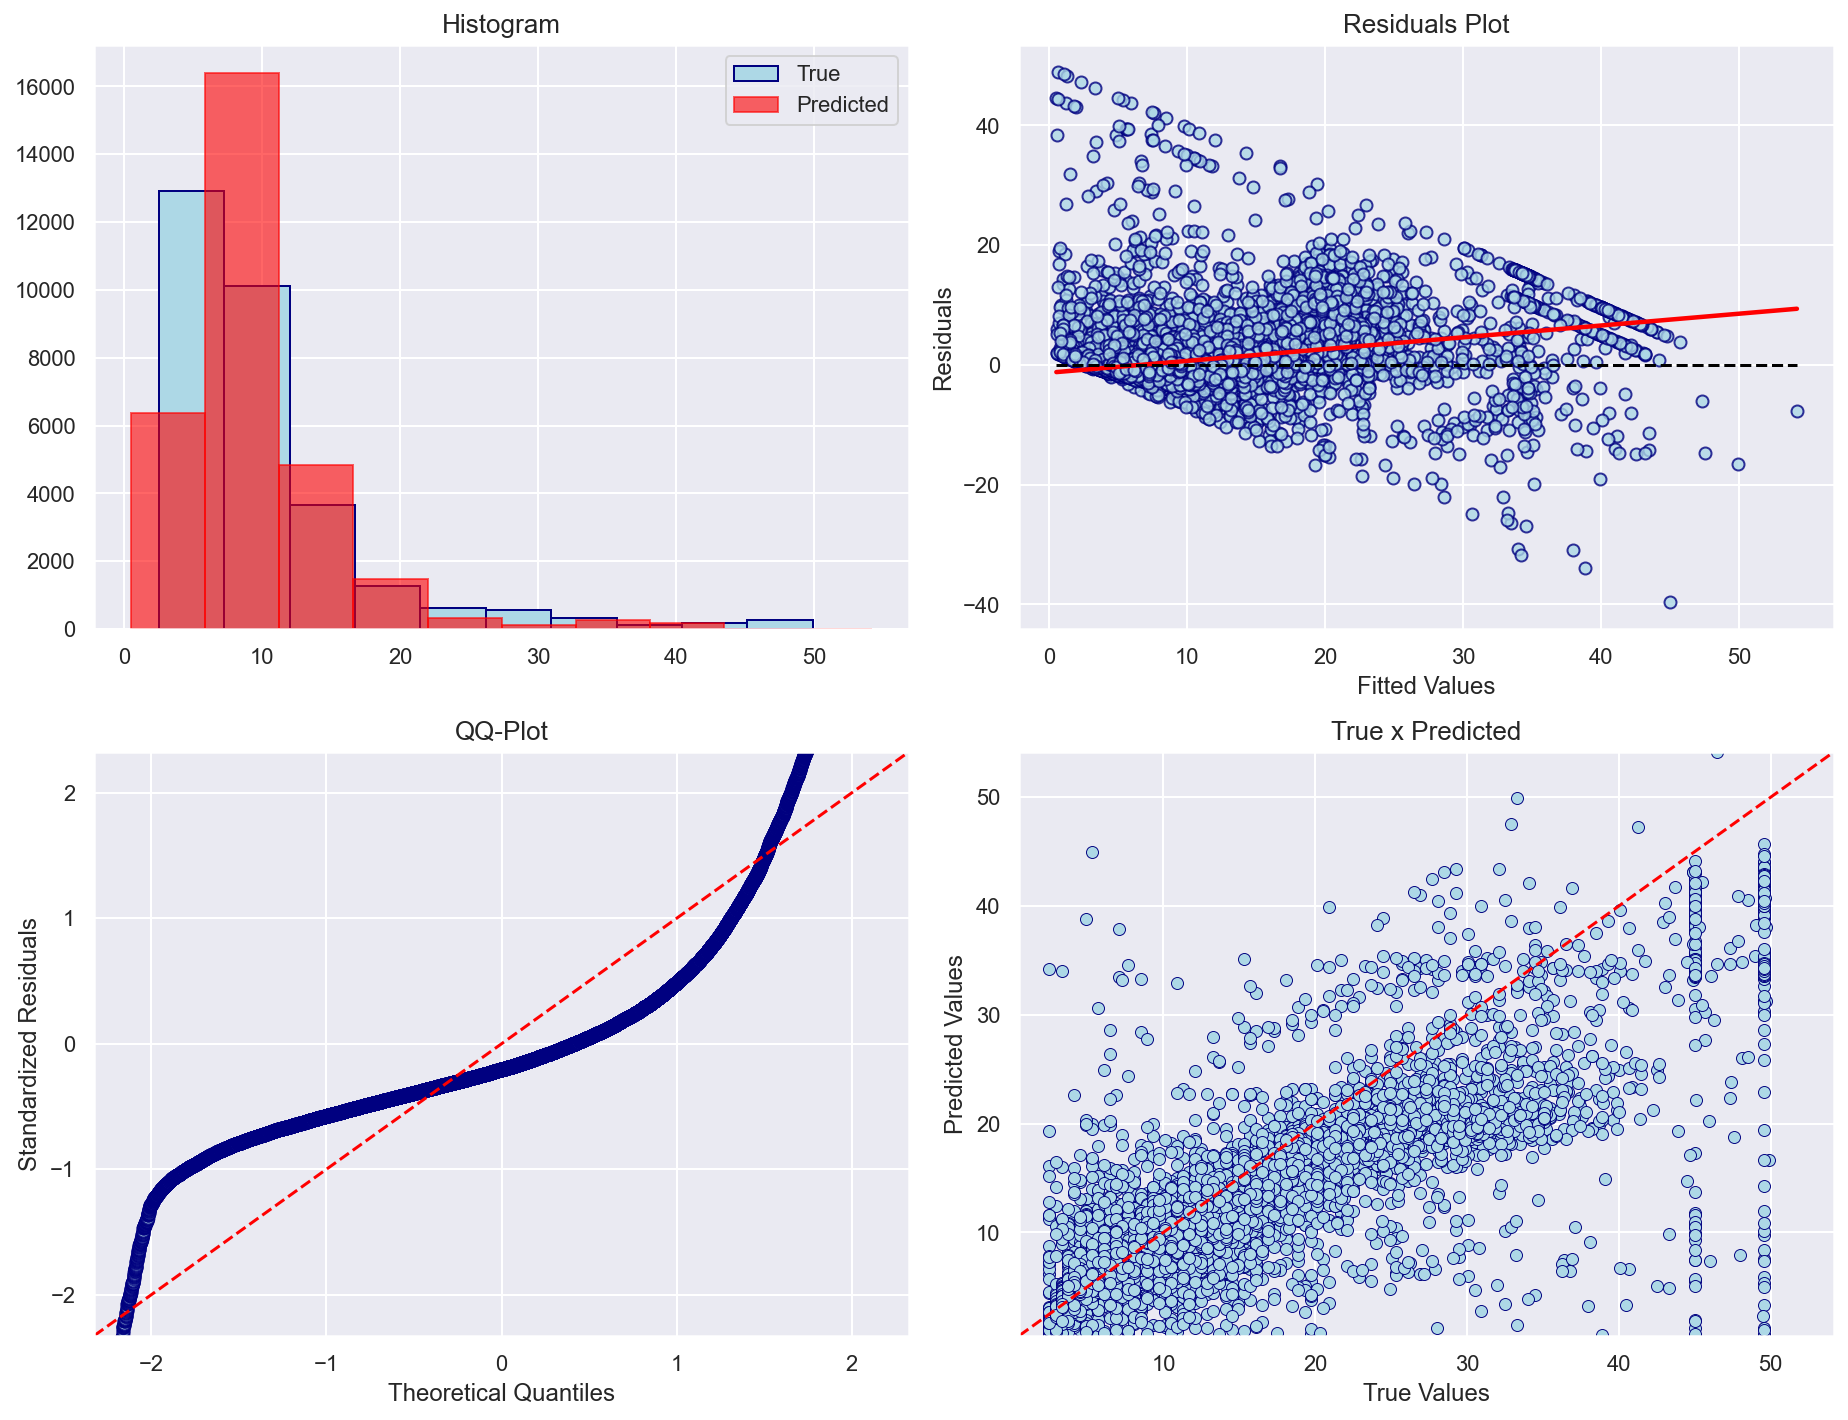

-------------------------------
lasso | RMSE: 3.776 | R2: 0.746
-------------------------------


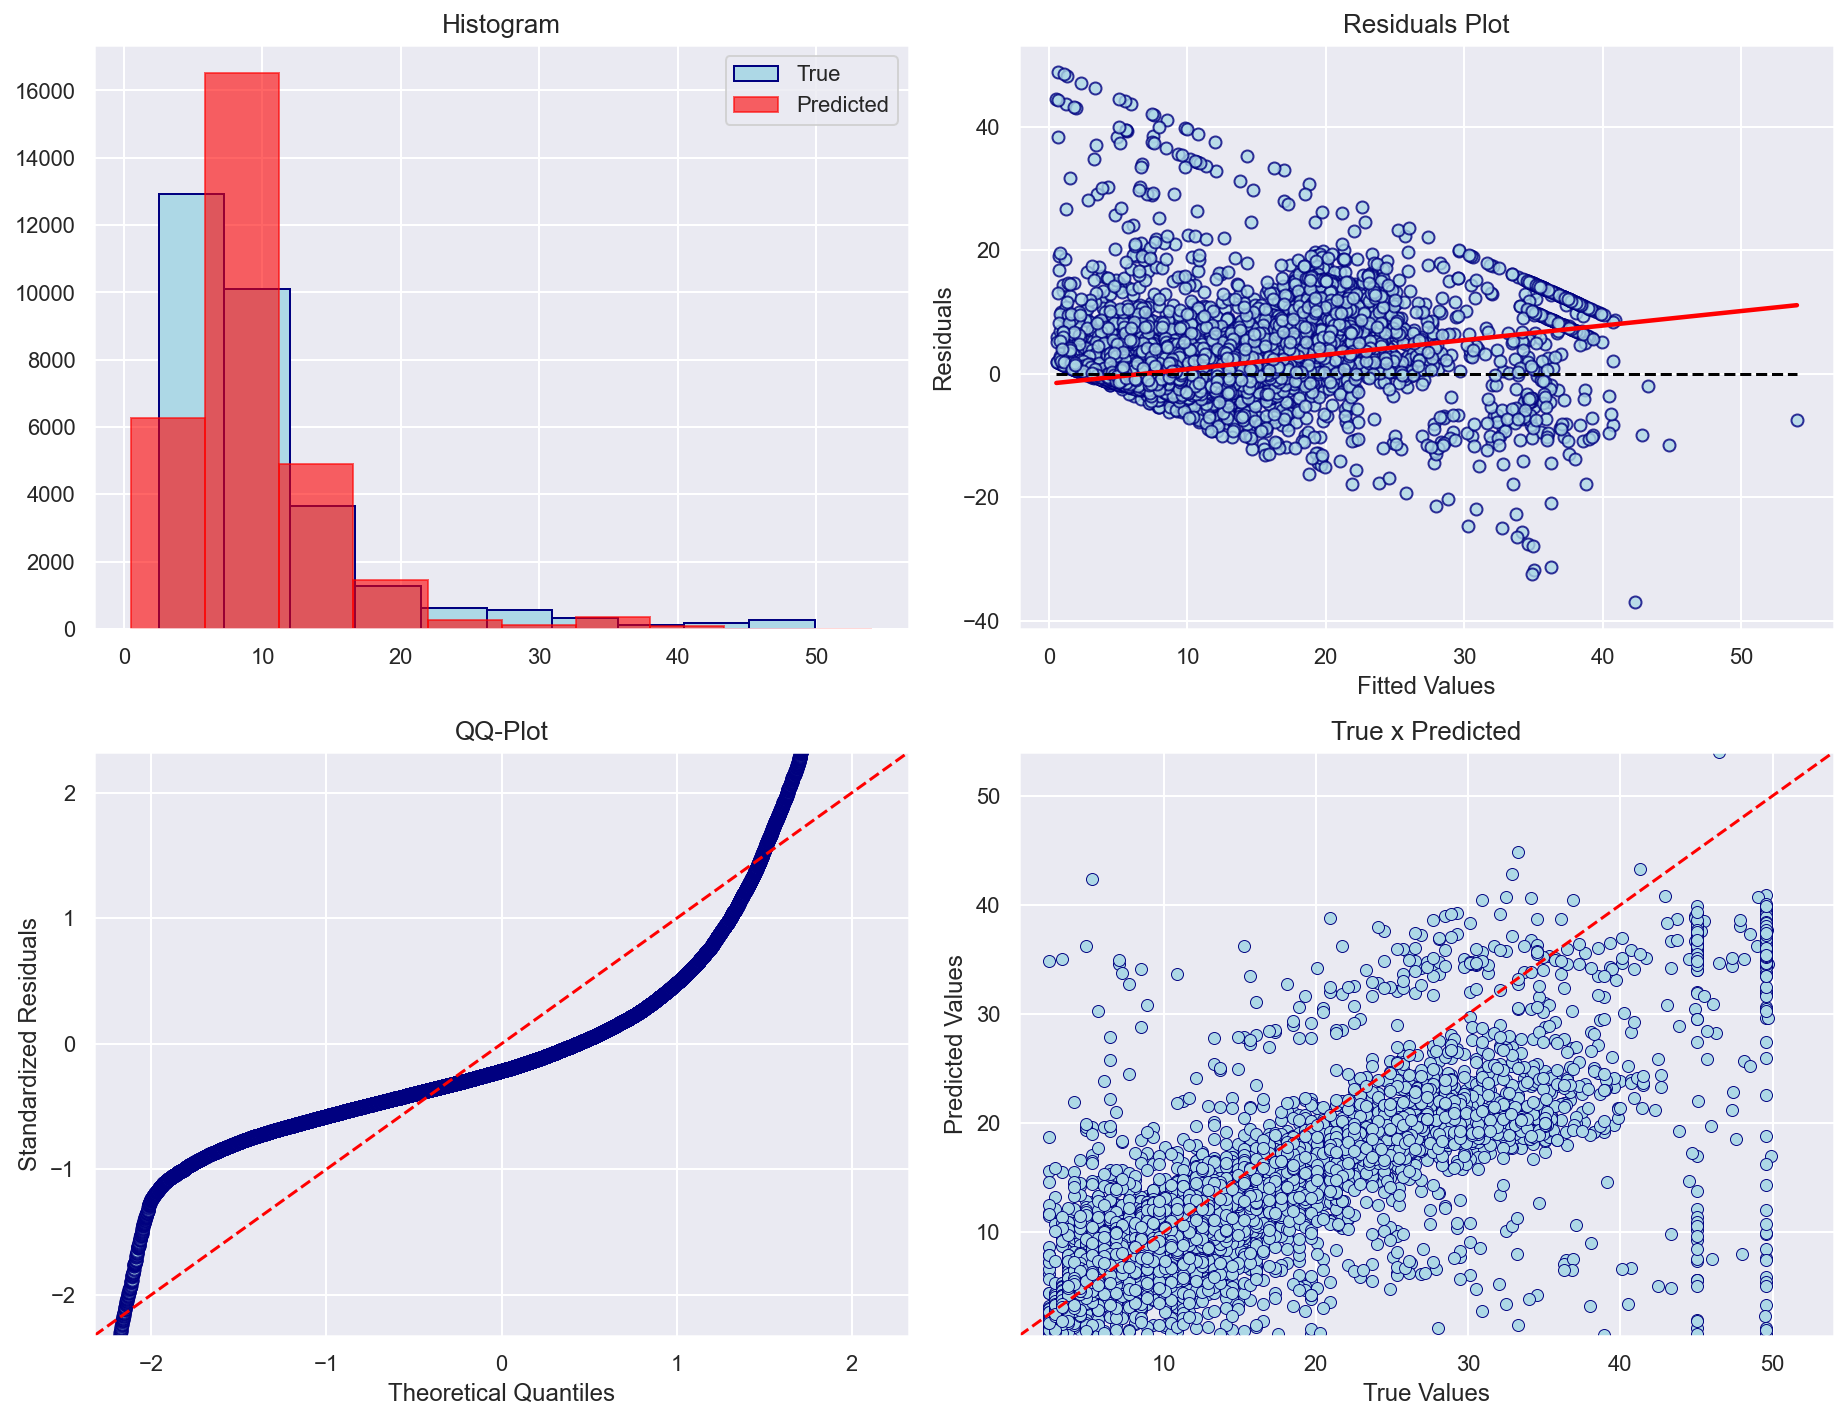

---------------------------------------
random_forest | RMSE: 3.123 | R2: 0.826
---------------------------------------


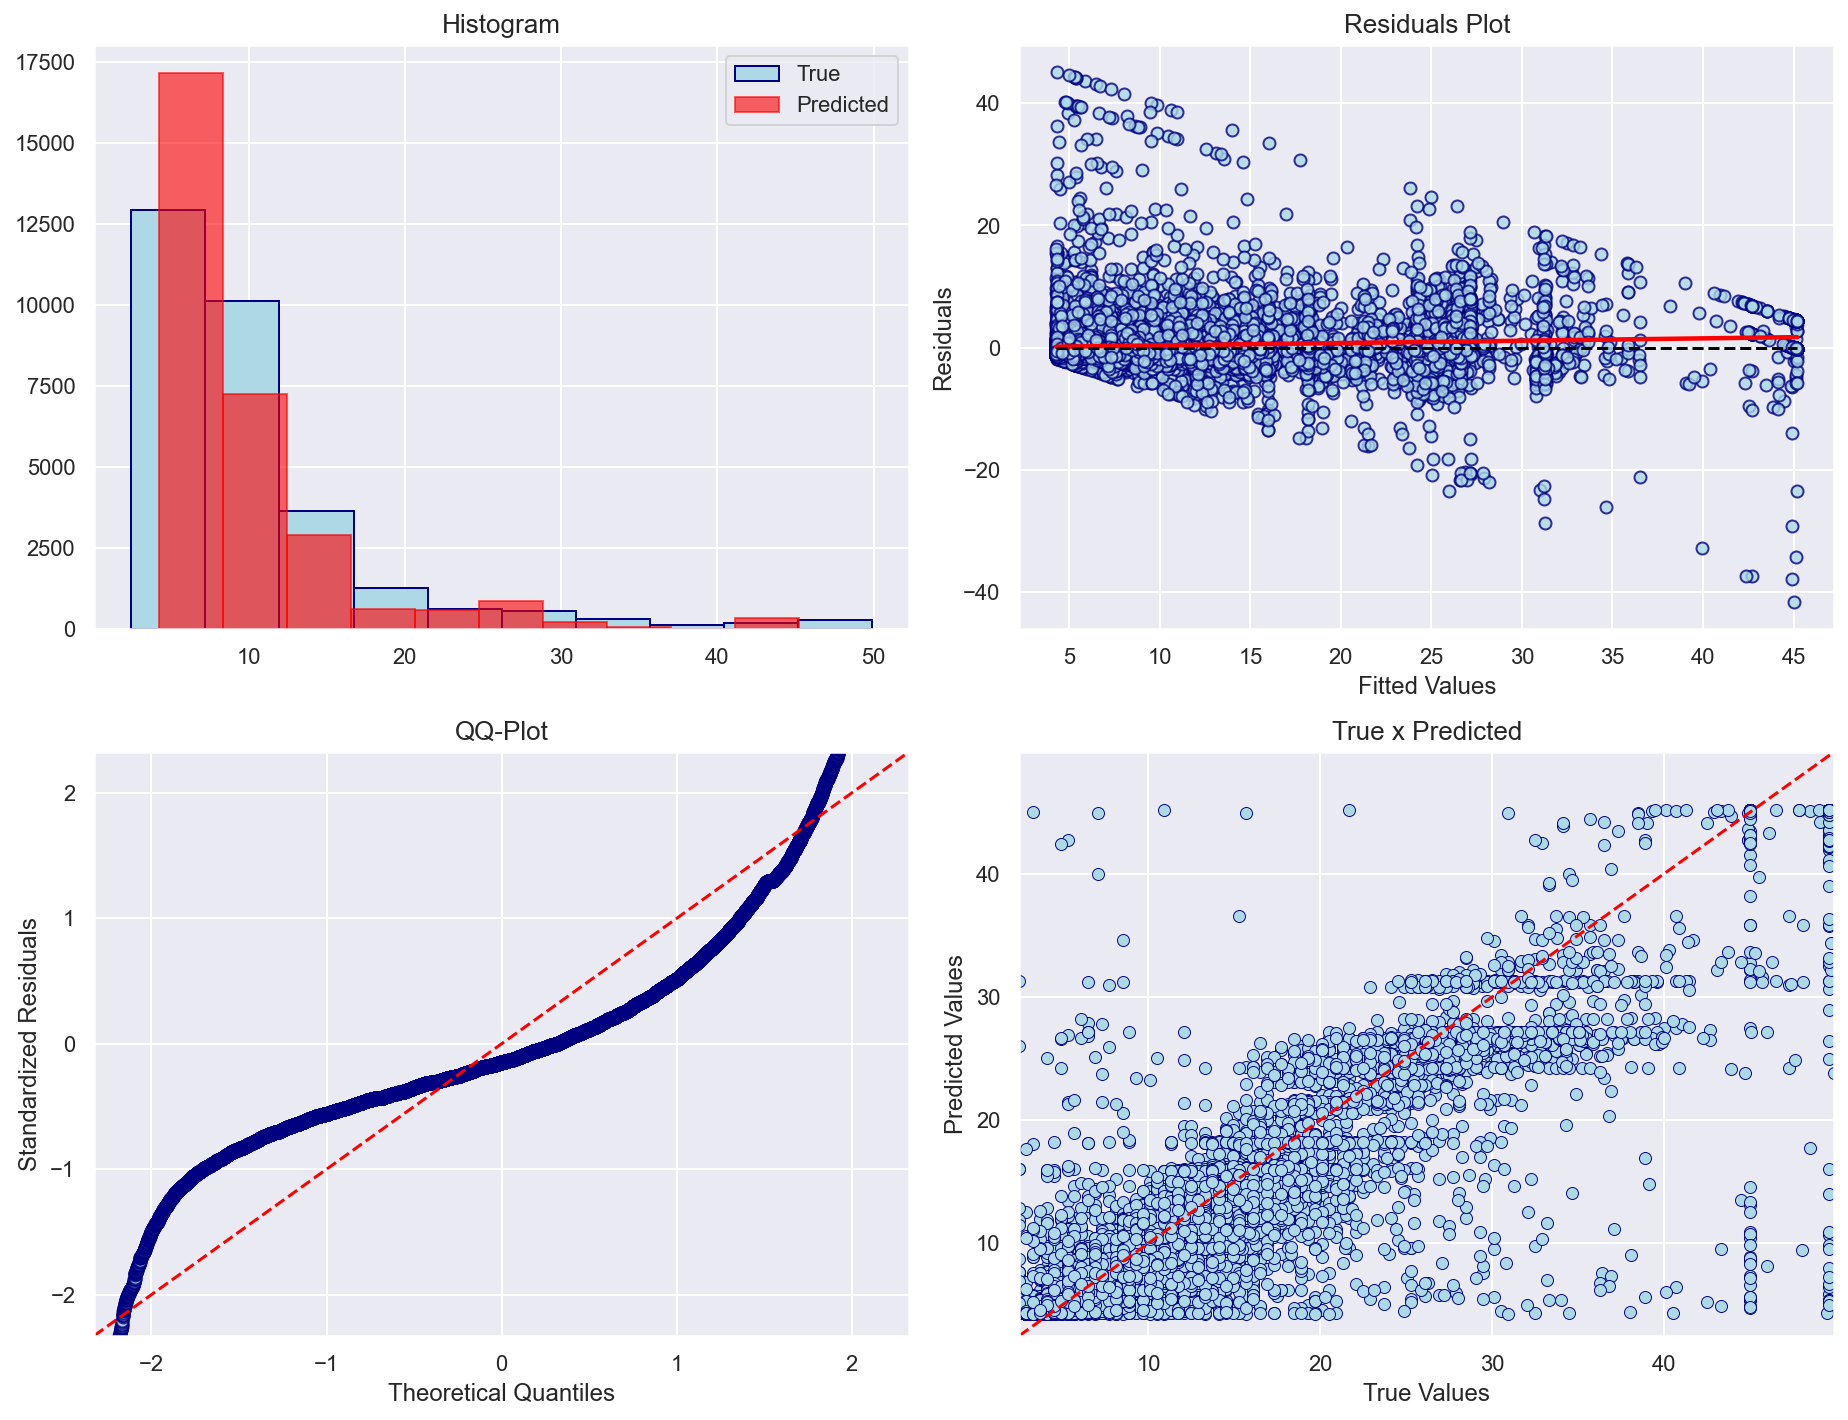

-------------------------------------------
gradient_boosting | RMSE: 3.023 | R2: 0.837
-------------------------------------------


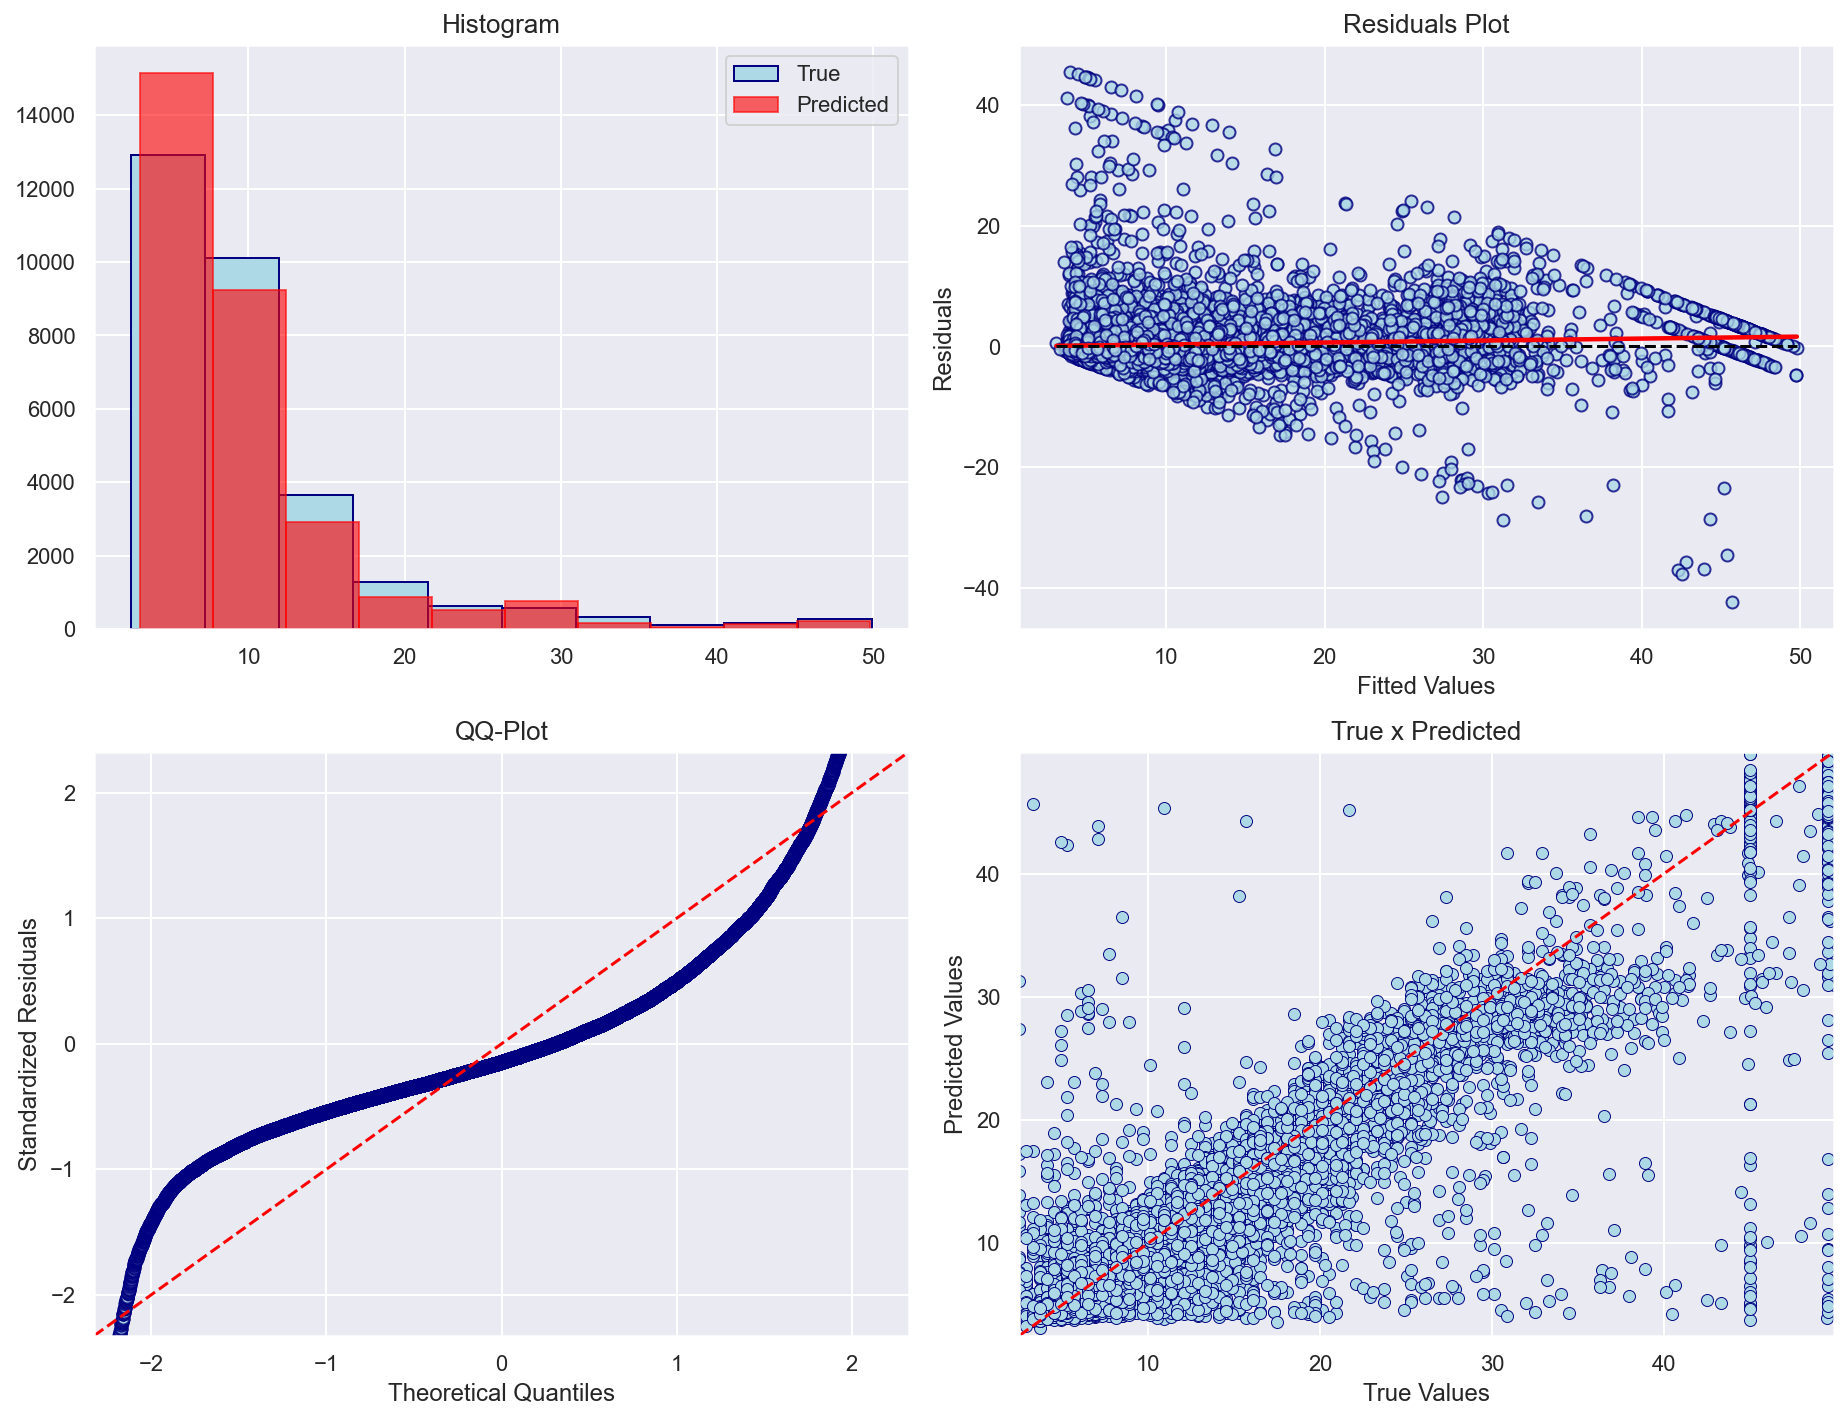

In [106]:
generate_regression_plots(
    models=best_models,
    post_processing=target_transformer,
    X_test=X_test,
    y_test=y_test.values.reshape(-1)
)

### 7. Conclusions

Overall, the best performing model is **Gradient Boosting**, since all of its evaluation metrics are superior in comparison to the ones obtained by the other models. Moreover, we can observe a better behavior of the model's predictions when we analyze the associated plots. Both distributions are similar to one another and a high correlation is observable from the regression plot between predicted and true values. Even though there are some issues with the residuals - the QQ-Plot suggests they are not well normally distributed and there is weak evidence on *homoscedasticity* - the behavior is closer to what we expect in comparison with the other candidate models.

Therefore, when implementing an end-to-end workflow using **AWS Sagemaker**, we will focus on further optimizing and deploying our Gradient Boosting Regressor.